# Part 1. Neuron Network Model


In [1]:
#!pip install brian2

from brian2 import *
from brian2 import start_scope
import brian2 as b2

import numpy as np
from numpy import random
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.animation as animation



import collections
import brian2.devices



INFO       Cache size for target 'cython': 1222 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/hkisic/.cython/brian_extensions' directory. [brian2]


# 1. a) Model

In [5]:
import pandas as pd
from brian2 import *
import numpy as np
from scipy import integrate
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

SimulationResult = collections.namedtuple('SimulationResult', 
    'net, SpikeMon_exc, SpikeMon_inh, StateMon_exc, StateMon_inh, ElecMon, Syn_EE, Syn_EI, Syn_IE, Syn_II')

# Define a function to run your model with a specific connectivity profile
def run_model(connectivity_profile, N, **params):
  """
  Run neural network simulation with specified connectivity profile.
  
  Parameters:
  - profile: String indicating connectivity profile ("Control", "Linear Mutant", "Parabolic Mutant")
  - N: Number of neurons
  - **params: Dictionary containing parameters specific to each profile
  """

  seed_value = params.get('seed', None)
  np.random.seed(seed_value) #sets the numpy random seed for the model
  seed(seed_value) #sets brian's internal random number geenrator seed
    
  start_scope()


  #**Parameters**
  #General setup parameters
  #p_syn = 0.1 #probability of synapse formation between two neurons
  N_exc = int(0.8 * N)
  N_inh = int(0.2 * N)
  W0 = 10 #scaling factor

  #Parameters for tuning
  g_syn_max_exc_value = 0.01 # Masquelier Deco 2013 adaptation related parameters, maximum synaptic conductance before was 0.01 then 0.05
  g_syn_max_inh_value = 0.1 # Valero 2022 Inhibitory conductance controls place field dynamics in the hippocampus before was 0.1

  g_syn_max_exc = g_syn_max_exc_value*uS
  g_syn_max_inh = g_syn_max_inh_value*uS

  #Neuronal parameters
  C_mem = 200*pF  # from https://doi.org/10.1063/1.5087129 membranae capacitnce
  V_L = -70*mV    # '' leak potential (resting potential)
  g_mem = 12*nS   # ''membrane conductance (leak conductance)
  D_T = 2*mV      # ''slope factor for exponential integrate and fire model
  V_T = -50*mV    # ''threshold potential for eif model

  #Synaptic parameters
  V_syn_exc = 0*mV    # ''Excitatorys ynaptic reversal potential
  V_syn_inh = -75 * mV  # Inhibitory reversal potential
  tau_r = 5*ms    # from https://neuronaldynamics.epfl.ch/online/Ch3.S1.html, NMDA synapse time constant of synaptic rise before was 5ms
  tau_d = 50*ms   # '' time constant of synaptic decay before was 50ms
  g_A = 4*nS # Brette&Gerstner adaptation related parameter (used to be 4)
  tau_A = 500*ms # why not 300 ? Brette&Gerstner 500*ms adaptation related parameter
  b = 0.02*nA # Brette&Gerstner adaptationr elated paraeter

  #Noise parameters
  tau_noise = 5 * ms  # correlation time (longer = smoother noise)
  sigma_noise = 0.03* nA  # noise amplitude -> 10% of Imid commonly used, if signal is too noisy, try 0.015nA, if signal is too weak try 0.06nA

  #simulation parameters
  runtime = 10*second #simulation duration
  set_dt = 0.01*ms #timestep of simulation

  #Electrode grid parameters
  gridsize = 0.5 #electrodes arranged on a grid of a size 1mm
  gridunit = mm
  maxsyndist = gridsize #synaptic connection distance
  sigma = 2*siemens/meter   # conductivity of saline medium
  N_elec = 12 #number if electodes for measuring LFP
  border = 0.1
  sqrtN = 4

  Vt = V_T+10*mV    # numerical spike threshold, formally inf in EIF neurons
  Vr = -60*mV     # needs adjustment. See Badel et al for EIF neuron tuning to experiments?
  refPeriod = 10*ms
  #dt_inf = C_mem/g_mem*exp((V_T-Vt)/D_T)


  #**Neuronal grid characteristics & virtual electrodes**
  coor1D = np.atleast_2d(np.linspace(border - gridsize/2, gridsize/2 - border, sqrtN))  # Center around 0
  Xe = np.array([(np.transpose(coor1D) * np.ones([1, sqrtN])).flatten(), (np.ones([sqrtN, 1]) * coor1D).flatten()])
  Xe = np.delete(Xe.T, [0, 3, 12, 15], axis=0)


  # **Model Equations**
  #Neuron model equations (both inhibitory and excitatory)
  eqs_EIF = '''
  dV/dt = 1/C_mem * (I_leak + I_exp - (I_syn_exc + I_syn_inh) + I_noise - A) : volt (unless refractory)
  dA/dt = 1/tau_A*(g_A*(V-V_L)-A) : ampere
  dI_noise/dt = -(I_noise-Imid)/tau_noise + sigma_noise * sqrt(2/tau_noise) * xi : ampere
  Imid :ampere

  s_tot_exc: 1 #summed contribution of excitatory synaptic iputs from all presynaptic neurons
  s_tot_inh: 1 #summed contribution of inhibitory synaptic inputs from all presynaptic neurons

  I_syn_exc = g_syn_max_exc * s_tot_exc * (V - V_syn_exc) : ampere #Excitatory synaptic current
  I_syn_inh = g_syn_max_inh * s_tot_inh * (V - V_syn_inh) : ampere #Inhibitory synaptic current
  I_leak = -g_mem*(V-V_L) : ampere #nA
  I_exp = g_mem*D_T*exp((V-V_T)/D_T) : ampere #nA
  I_sum = I_leak + I_exp - (I_syn_exc + I_syn_inh) + I_noise : ampere

  x1 : 1
  x2 : 1
  '''

  #Synapse model equations
  eqs_synapse_exc = '''
  ds_syn_exc/dt = x_exc : 1 (clock-driven)
  dx_exc/dt = 1/(tau_r*tau_d) *( -(tau_r+tau_d)*x_exc - s_syn_exc ) : Hz (clock-driven)
  s_tot_exc_post = w*s_syn_exc :1 (summed)
  w : 1 #dimensionless
  '''

  eqs_synapse_inh = '''
  ds_syn_inh/dt = x_inh :1 (clock-driven) #since unit of the derivative is 1/s, unit of s_syn_exc is dimensionless
  dx_inh/dt = 1/(tau_r*tau_d) *( -(tau_r+tau_d)*x_inh - s_syn_inh ) : Hz (clock-driven) #order of magnitude 10**3
  s_tot_inh_post = w*s_syn_inh :1 (summed)
  w : 1 #dimensionless
  '''

  eqs_reset = '''
  V=Vr
  A+=b
  '''

  eqs_onpre_exc = '''
  x_exc += 1*Hz
  '''

  eqs_onpre_inh = '''
  x_inh += 1*Hz
  '''


  # **Defining neural populations in brian and their positions**
  #Excitatory Neuron Population
  Pop_exc = NeuronGroup(N_exc, eqs_EIF, threshold='V>Vt', reset=eqs_reset, refractory=refPeriod, method='euler') #population of excitatory neurons
  Pop_exc.V = np.random.uniform(-60, -50, N_exc) * mV
  Pop_exc.A = 0.1*nA  #+ 0.02*nA*np.random.randn(N_exc)
  Pop_exc.I_noise = 0 * nA #noise initialized to zero
  Pop_exc.Imid = 0.3*nA #+ 0.05*nA*np.random.randn(N_exc) #found bifurcation saddle point current via phase plane analysis
  Pop_exc.s_tot_exc = 0
  Pop_exc.s_tot_inh = 0

  #Inhibitory Neuron Population
  Pop_inh = NeuronGroup(N_inh, eqs_EIF, threshold='V>Vt', reset=eqs_reset, refractory=refPeriod, method='euler') #population of inhibitory neurons
  Pop_inh.V = np.random.uniform(-60, -50, N_inh) * mV
  Pop_inh.A = 0.1*nA  #+ 0.02*nA*np.random.randn(N_inh)
  Pop_inh.I_noise = 0 * nA #noise initialized to zero
  Pop_inh.Imid =  0.3*nA #+ 0.05*nA*np.random.randn(N_inh) #found bifurcation saddle point current via phase plane analysis and add heterogeneity 
  Pop_inh.s_tot_exc = 0
  Pop_inh.s_tot_inh = 0



  # **Defining positions of neurons on the circular grid**
  R = gridsize  # radius of the circular grid

  # generate random polar coordinates for excitatory neurons
  r_exc = R * np.sqrt(np.random.rand(N_exc))
  theta_exc = np.random.rand(N_exc) * 2 * np.pi

  # convert polar to Cartesian coordinates
  X_position_exc = np.column_stack((r_exc * np.cos(theta_exc), r_exc * np.sin(theta_exc)))

  # generate random polar coordinates for inhibitory neurons
  r_inh = R * np.sqrt(np.random.rand(N_inh))
  theta_inh = np.random.rand(N_inh) * 2 * np.pi

  # convert polar to Cartesian coordinates
  X_position_inh = np.column_stack((r_inh * np.cos(theta_inh), r_inh * np.sin(theta_inh)))

  # Assign coordinates to NeuronGroups
  Pop_exc.x1, Pop_exc.x2 = X_position_exc[:, 0], X_position_exc[:, 1]
  Pop_inh.x1, Pop_inh.x2 = X_position_inh[:, 0], X_position_inh[:, 1]

  #create the network
  net = Network()
  #add populations to the network
  net.add(Pop_exc, Pop_inh)

  # **Defining Synapse Connections in brian**
  # Conditional synapse setup based on selected profile
  if connectivity_profile == "Control":
    # Control population synapses
    print("Running simulation with Control connectivity profile...")

    c1 = params['c1']
    d_max = params['d_max_c']
    d_mid = params['d_mid_c']
    control_area = params['control_area']

    rho_total = N/(np.pi*R**2) #total density of all neurons on the circular grid

    # This is the principle of the probability formula but it has to be all in one big ugly formula because positions of neurnos only exist in the context of brian objects and cannot be used outside
    # distance = sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)
    # N_syn = c1*(distance/d_max)*(1-distance/d_max)**(d_max/d_mid - 1)))
    # rho = 2*rho_total*np.pi*distance -> density of neurons at given distance 
    # prob_formula = N_syn/rho -> probability of synapse formation between two neurons

    # Excitatory to Excitatory
    Syn_EE = Synapses(Pop_exc, Pop_exc, on_pre=eqs_onpre_exc, model=eqs_synapse_exc, method='rk4')
    Syn_EE.connect(condition=f'(i != j) and sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}', 
                   p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')
    Syn_EE.w = float(W0/control_area)

    # Excitatory to Inhibitory
    Syn_EI = Synapses(Pop_exc, Pop_inh, on_pre=eqs_onpre_exc, model=eqs_synapse_exc, method='rk4')
    Syn_EI.connect(condition=f'sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}', 
                   p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')
    Syn_EI.w = float(2*W0/control_area)

    # Inhibitory to Excitatory
    Syn_IE = Synapses(Pop_inh, Pop_exc, on_pre=eqs_onpre_inh, model=eqs_synapse_inh, method='rk4')
    Syn_IE.connect(condition=f'sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}', 
                   p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')
    Syn_IE.w = -float(4*W0/control_area)

    # Inhibitory to Inhibitory
    Syn_II = Synapses(Pop_inh, Pop_inh, on_pre=eqs_onpre_inh, model=eqs_synapse_inh, method='rk4')
    Syn_II.connect(condition=f'(i != j) and sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}', 
                   p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')
    Syn_II.w = -float(W0/control_area)

    net.add(Syn_EE, Syn_EI, Syn_IE, Syn_II)

  elif connectivity_profile == "Mutant_1":
    # Linear Mutant population synapses
    print("Running simulation with Mutant 1 connectivity profile...")

    c1 = params['c1']
    d_max = params['d_max_m1']
    d_mid = params['d_mid_c']
    mutant_area = params['mutant_area']

    rho_total = N/(np.pi*R**2) #total density of all neurons on the circular grid

    # Excitatory to Excitatory
    Syn_EE = Synapses(Pop_exc, Pop_exc, on_pre=eqs_onpre_exc, model=eqs_synapse_exc, method='rk4')
    Syn_EE.connect(condition =f'(i != j) and sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}',
                   p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')    
    Syn_EE.w = float(W0/mutant_area)

    # Excitatory to Inhibitory
    Syn_EI = Synapses(Pop_exc, Pop_inh, on_pre=eqs_onpre_exc, model=eqs_synapse_exc, method='rk4')
    Syn_EI.connect(condition =f'sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}',
                    p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')    
    Syn_EI.w = float(2*W0/mutant_area)

    # Inhibitory to Excitatory
    Syn_IE = Synapses(Pop_inh, Pop_exc, on_pre=eqs_onpre_inh, model=eqs_synapse_inh, method='rk4')
    Syn_IE.connect(condition =f'sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}',
                    p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')    
    Syn_IE.w = -float(4*W0/mutant_area)

    # Inhibitory to Inhibitory
    Syn_II = Synapses(Pop_inh, Pop_inh, on_pre=eqs_onpre_inh, model=eqs_synapse_inh, method='rk4')
    Syn_II.connect(condition =f'(i != j) and sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}',
                    p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')    
    Syn_II.w = -float(W0/mutant_area)

    net.add(Syn_EE, Syn_EI, Syn_IE, Syn_II)


  elif connectivity_profile == "Mutant_2":
    # Parabolic Mutant population synapses
    print("Running simulation with Mutant 2 connectivity profile...")

    c1 = params['c1']
    d_max = params['d_max_m2']
    d_mid = params['d_mid_m2']
    mutant_area = params['mutant_area']

    rho_total = N/(np.pi*R**2) #total density of all neurons on the circular grid


    # Excitatory to Excitatory
    Syn_EE = Synapses(Pop_exc, Pop_exc, on_pre=eqs_onpre_exc, model=eqs_synapse_exc, method='rk4')
    Syn_EE.connect(condition =f'(i != j) and sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}',
                    p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')    
    Syn_EE.w = float(W0/mutant_area)
   
    # Excitatory to Inhibitory
    Syn_EI = Synapses(Pop_exc, Pop_inh, on_pre=eqs_onpre_exc, model=eqs_synapse_exc, method='rk4')
    Syn_EI.connect(condition =f'sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}',
                    p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')    
    Syn_EI.w = float(2*W0/mutant_area)

    # Inhibitory to Excitatory
    Syn_IE = Synapses(Pop_inh, Pop_exc, on_pre=eqs_onpre_inh, model=eqs_synapse_inh, method='rk4')
    Syn_IE.connect(condition =f'sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}',
                    p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')    
    Syn_IE.w =-float(4*W0/mutant_area)

    # Inhibitory to Inhibitory
    Syn_II = Synapses(Pop_inh, Pop_inh, on_pre=eqs_onpre_inh, model=eqs_synapse_inh, method='rk4')
    Syn_II.connect(condition =f'(i != j) and sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2) <= {d_max}',
                    p=f'({c1}*(sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/{d_max})**({d_max}/{d_mid}-1))/({2}*{rho_total}*pi*sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2))')    
    Syn_II.w =-float(W0/mutant_area)

    net.add(Syn_EE, Syn_EI, Syn_IE, Syn_II)

  # **Setting up monitors in brian**
  SpikeMon_exc = SpikeMonitor(Pop_exc)  #monitors spiking activity of excitatory neuron popultion
  SpikeMon_inh = SpikeMonitor(Pop_inh)  #monitors spiking activity of inhibitory neuron popultion
  StateMon_exc = StateMonitor(Pop_exc, variables=['V','I_syn_exc', 'I_syn_inh', 'I_leak','I_exp','A', 'I_sum', 'Imid', 'I_noise'], record=True, dt=2*ms)
  StateMon_inh = StateMonitor(Pop_inh, variables=['V','I_syn_exc', 'I_syn_inh','I_leak','I_exp','A', 'I_sum', 'Imid', 'I_noise'], record=True, dt=2*ms)

  # Add monitors to network
  net.add(SpikeMon_exc, SpikeMon_inh, StateMon_exc, StateMon_inh)

  # **Counting synapses for both excitatory and inhibitory neurons**
  pre_neurons_exc = Syn_EE.i  # Pre-synaptic indices for Excitatory → Excitatory
  post_neurons_exc = Syn_EE.j  # Post-synaptic indices for Excitatory → Excitatory
  pre_neurons_inh = Syn_IE.i + N_exc  # Pre-synaptic indices for Inhibitory → Excitatory (offset by N_exc)
  post_neurons_inh = Syn_IE.j  # Post-synaptic indices for Inhibitory → Excitatory

  # Combine all synapse indices
  pre_neurons = np.concatenate((pre_neurons_exc, pre_neurons_inh))
  post_neurons = np.concatenate((post_neurons_exc, post_neurons_inh))

  # Count synapses
  unique, counts = np.unique(pre_neurons, return_counts=True)
  synapse_count_per_neuron = dict(zip(unique, counts))  # Map neuron to outgoing synapse count

  # **Set up virtual electrodes**
  # Equations
  eqs_elec = '''
  Imem_w_exc :ampere/meter
  Imem_w_inh :ampere/meter
  LFP = 1/(4*pi*sigma) * (Imem_w_exc + Imem_w_inh) : volt # Sum contributions for LFP
  '''

  eqs_record_exc = '''
  dist : meter
  Imem_w_exc_post = I_sum_pre/dist : ampere/meter (summed) # Update excitatory variable
  '''

  eqs_record_inh = '''
  dist : meter
  Imem_w_inh_post = I_sum_pre/dist : ampere/meter (summed) # Update inhibitory variable
  '''


  # ** Define population of electrodes in brian**
  ELEC = NeuronGroup(N_elec, eqs_elec)  # Virtual electrodes
  Syn_LFP_exc = Synapses(Pop_exc, ELEC, model=eqs_record_exc, method='exact')  # connect excitatory neurons to electrodes
  Syn_LFP_inh = Synapses(Pop_inh, ELEC, model=eqs_record_inh, method='exact')  # connect inhibitory neurons to electrodes

  # Connect electrodes to both populations
  Syn_LFP_exc.connect()
  Syn_LFP_inh.connect()
  net.add(ELEC, Syn_LFP_exc, Syn_LFP_inh)


  # **LFP calcualtion**
  # Compute distances for LFP contributions
  Syn_LFP_exc.dist = np.sqrt(np.sum((np.vstack([Xe for _ in range(N_exc)]) - np.repeat(X_position_exc, N_elec, axis=0))**2, axis=1)) * gridunit
  Syn_LFP_inh.dist = np.sqrt(np.sum((np.vstack([Xe for _ in range(N_inh)]) - np.repeat(X_position_inh, N_elec, axis=0))**2, axis=1)) * gridunit

  # Monitor LFP signals
  ElecMon = StateMonitor(ELEC, variables='LFP', record=True, dt=1*ms)
  net.add(ElecMon)




  # Run simulation for first 2 seconds to get the transient
  defaultclock.dt = set_dt
  #transient_duration = 2 * second
  #net.run(transient_duration)

  # Store network state
  #net.store(name='state_at_2s')
  #print("Network state stored at 2 seconds.")


  # **Continue simulation**
  #net.run(runtime - transient_duration)
  net.run(runtime)


  # Return important results for analysis
  # Inside run_model function, at the end:
# Inside run_model function, right before the return statement
  return SimulationResult(
      net=net, 
      SpikeMon_exc=SpikeMon_exc, 
      SpikeMon_inh=SpikeMon_inh,
      StateMon_exc=StateMon_exc, 
      StateMon_inh=StateMon_inh, 
      ElecMon=ElecMon,
      Syn_EE=Syn_EE, 
      Syn_EI=Syn_EI,
      Syn_IE=Syn_IE,
      Syn_II=Syn_II
  )



In [ ]:
#New protocol with organized saving 

import pickle
import os
import numpy as np
from datetime import datetime
import time
import gc
from scipy import integrate

start_time = time.time()

# Create fixed seeds for each connectivity profile (use same seeds for everything)
control_seed = 12345
mutant_1_seed = 12345
mutant_2_seed = 12345

connectivity_profiles = ["Control", "Mutant_1", "Mutant_2"]

# maximum reach distances based on data
d_n_max_c = np.linspace(0.045, 0.2, 7) # incrementally increasing maximum distance the control population
d_n_max_m1 = np.linspace(0.045, 0.6, 7) # incrementally increasing max distance the mutant with further reach distance
d_n_max_m2 = np.linspace(0.3, 0.6, 7) # incrementally increasing max distance of the mutant with further reach distamce and higher prefered distance
d_n_max_m2_exp_1 = np.linspace(0.3, 0.6, 7)

# distance at which most synapses are created (locations of maxima)
d_mid_c = 0.04
d_mid_m1 = d_mid_c
d_mid_m2 = 0.25

N_syn_max_ctr = 160 # define maximum number of synapses at d_mid
N_syn_max_mut = 240 #define maximum number of synapses at d_mid 

# total number of neurons
N = 1000

# Create a results directory
results_dir = "final_result_batch_33"
os.makedirs(results_dir, exist_ok=True)

# Create subdirectories for each experiment type
experiment_folders = {
    "Control_experiment": os.path.join(results_dir, "Control_experiment"),
    "Mutant_1_exp_1": os.path.join(results_dir, "Mutant_1_exp_1"),
    "Mutant_1_exp_2": os.path.join(results_dir, "Mutant_1_exp_2"),
    "Mutant_1_exp_3": os.path.join(results_dir, "Mutant_1_exp_3"),
    "Mutant_2_exp_1": os.path.join(results_dir, "Mutant_2_exp_1"),
    "Mutant_2_exp_3": os.path.join(results_dir, "Mutant_2_exp_3")
}

# Create all experiment folders
for folder in experiment_folders.values():
    os.makedirs(folder, exist_ok=True)
    print(f"Created directory: {folder}")

# Create a timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save experiment parameters for reference
experiment_params = {
    "control_seed": control_seed,
    "mutant_1_seed": mutant_1_seed,
    "mutant_2_seed": mutant_2_seed,
    "d_n_max_c": d_n_max_c,
    "d_n_max_m1": d_n_max_m1,
    "d_n_max_m2": d_n_max_m2,
    "d_n_max_m2_exp_1": d_n_max_m2_exp_1,
    "N": N,
    "timestamp": timestamp,
    "synapse_formation_modified": True,  # Flag to indicate we've modified synapse formation
}

params_filename = f"{results_dir}/simulation_3_params_{timestamp}.pkl"
with open(params_filename, 'wb') as f:
    pickle.dump(experiment_params, f)
print(f"Experiment parameters saved to {params_filename}")

# Function to save simulation data
def save_simulation_data(result, profile, experiment_name, iteration, params, timestamp, experiment_folders, results_dir):
    """Helper function to save all simulation data consistently"""
    
    # Print synapse count information
    print(f"{experiment_name} simulation {iteration} - Synapses: EE={len(result.Syn_EE.i)}, EI={len(result.Syn_EI.i)}, IE={len(result.Syn_IE.i)}, II={len(result.Syn_II.i)}")
    
    # Save comprehensive data
    print(f"{experiment_name} simulation {iteration} - Saving comprehensive data...")
    
    # Concatenate excitatory and inhibitory data
    V_all = np.concatenate((result.StateMon_exc.V, result.StateMon_inh.V), axis=0)
    Imid_all = np.concatenate((result.StateMon_exc.Imid, result.StateMon_inh.Imid))
    neuron_type = np.concatenate((np.zeros(len(result.StateMon_exc.V)), np.ones(len(result.StateMon_inh.V))))
    
    data_to_save = {
        # LFP data
        'LFP': np.array(result.ElecMon.LFP),
        'LFP_time': np.array(result.ElecMon.t),
        
        # Voltage traces (separate and concatenated)
        'V_exc': np.array(result.StateMon_exc.V),
        'V_inh': np.array(result.StateMon_inh.V),
        'V_all': V_all,
        'V_time': np.array(result.StateMon_exc.t),
        
        # Intrinsic currents (separate and concatenated)
        'Imid_exc': np.array(result.StateMon_exc.Imid),
        'Imid_inh': np.array(result.StateMon_inh.Imid),
        'Imid_all': Imid_all,
        'neuron_type': neuron_type,  # 0=exc, 1=inh
        
        # Connectivity information
        'connectivity': {
            'Syn_EE': {
                'i': np.array(result.Syn_EE.i),  # pre-synaptic indices
                'j': np.array(result.Syn_EE.j),  # post-synaptic indices
                'w': np.array(result.Syn_EE.w),  # synaptic weights
                'n_synapses': len(result.Syn_EE.i)
            },
            'Syn_EI': {
                'i': np.array(result.Syn_EI.i),
                'j': np.array(result.Syn_EI.j),
                'w': np.array(result.Syn_EI.w),
                'n_synapses': len(result.Syn_EI.i)
            },
            'Syn_IE': {
                'i': np.array(result.Syn_IE.i),
                'j': np.array(result.Syn_IE.j),
                'w': np.array(result.Syn_IE.w),
                'n_synapses': len(result.Syn_IE.i)
            },
            'Syn_II': {
                'i': np.array(result.Syn_II.i),
                'j': np.array(result.Syn_II.j),
                'w': np.array(result.Syn_II.w),
                'n_synapses': len(result.Syn_II.i)
            }
        },
        
        # Simulation parameters
        'params': params
    }
    
    # Save all data in a single file
    experiment_folder = experiment_folders[experiment_name]
    complete_filename = f"{experiment_folder}/{experiment_name}_data_{iteration}_{timestamp}.pkl"
    with open(complete_filename, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"{experiment_name} simulation {iteration} complete data saved to {complete_filename}")
    
    # Also save LFP separately in .npy format for backward compatibility
    lfp_filename = f"{experiment_folder}/LFP_{experiment_name}_{iteration}_{timestamp}.npy"
    np.save(lfp_filename, np.array(result.ElecMon.LFP))


# control profile
for profile in connectivity_profiles:
    if profile == "Control":
        seed_value = control_seed
        control_areas = np.zeros(len(d_n_max_c)) #intialize array to store control area

        for distance in range(len(d_n_max_c)): # going through developmental stages
            d_max_c = d_n_max_c[distance]

            #calcualte constant c1 at d_mid and N_syn_max
            c1_control = N_syn_max_ctr/((d_mid_c/d_max_c)*(1-d_mid_c/d_max_c)**(d_max_c/d_mid_c-1)) #constant which determines the height of the curve

            # calculate the area under the curve of the control population with this equation obtained from explicit integration
            control_areas[distance] = c1_control *((d_mid_c**2)/(d_max_c+d_mid_c)) #explicitly calculated 

            params = {
                'd_max_c': d_n_max_c[distance],
                'd_mid_c': d_mid_c,
                'c1': c1_control,
                'control_area': control_areas[distance],
                'seed': seed_value
            }

            try:
                result = run_model(profile, N, **params)
                
                # Save data using helper function
                save_simulation_data(result, profile, "Control_experiment", distance, params, timestamp, experiment_folders, results_dir)

            except Exception as e:
                # Handle the error
                print(f"ERROR in {profile} simulation {distance}: {str(e)}")
                # log the error
                with open(f"{results_dir}/error_log_{timestamp}.txt", "a") as error_file:
                    error_file.write(f"Error in {profile} simulation {distance}: {str(e)}\n")
                    error_file.write(f"Parameters: {params}\n\n") 
                # Continue to next iteration
                continue
        
            finally:
                # Clean up whether successful or not
                if 'result' in locals():
                    del result
                    gc.collect()


    elif profile == "Mutant_1":
        seed_value = mutant_1_seed
        # Experiment 1 -> Long projection mutant -> this mutant has the same d_mid, but increased reach distance d_n_max_m1
        mut_1_exp_1_areas = control_areas  #keep areas of control and mutant from corresponding developmental stages the same
        for k in range(len(d_n_max_m1)):
            d_max_m1_exp_1 = d_n_max_m1[k]

            # caluclate the appropriate scaling factor for keepig area the same
            c1_mut_1_exp_1 = mut_1_exp_1_areas[k]*((d_max_m1_exp_1+d_mid_c)/(d_mid_c**2))
        
            params = {
                'd_max_m1': d_max_m1_exp_1,
                'd_mid_c': d_mid_c,
                'c1': c1_mut_1_exp_1,
                'mutant_area': mut_1_exp_1_areas[k],
                'seed': seed_value
            }

            try:
                result = run_model(profile, N, **params)
                
                # Save data using helper function
                save_simulation_data(result, profile, "Mutant_1_exp_1", k, params, timestamp, experiment_folders, results_dir)
                
            except Exception as e:
                # Handle the error
                print(f"ERROR in {profile} simulation {k}: {str(e)}")
                # log the error
                with open(f"{results_dir}/error_log_{timestamp}.txt", "a") as error_file:
                    error_file.write(f"Error in {profile} simulation {k}: {str(e)}\n")
                    error_file.write(f"Parameters: {params}\n\n") 
                # Continue to next iteration
                continue

            finally:
                # Clean up whether successful or not
                if 'result' in locals():
                    del result
                    gc.collect()


        # Experiment 2 -> Synaptic number mutant
        mut_1_exp_2_areas = np.zeros(len(d_n_max_c))
        for l in range(len(d_n_max_c)): 
            d_max_m1 = d_n_max_c[l]

            #Calculating the area under the curve of the mutant population with increased synaptic density
            #calcualte constant c1 at d_mid and N_syn_max_mut
            c1_mut_1_exp_2 = N_syn_max_mut/((d_mid_c/d_max_m1)*(1-d_mid_c/d_max_m1)**(d_max_m1/d_mid_c-1)) #constant which determines the height of the curve

            # store the area in an array
            mut_1_exp_2_areas[l] = c1_mut_1_exp_2 *((d_mid_c**2)/(d_max_m1+d_mid_c)) #explicitly calculated 

            params = {
                'd_max_m1': d_n_max_c[l],
                'd_mid_c': d_mid_c,
                'c1': c1_mut_1_exp_2,
                'mutant_area': mut_1_exp_2_areas[l],
                'seed': seed_value
            }

            try:
                result = run_model(profile, N, **params)
                
                # Save data using helper function
                save_simulation_data(result, profile, "Mutant_1_exp_2", l, params, timestamp, experiment_folders, results_dir)

            except Exception as e:
                # Handle the error
                print(f"ERROR in {profile} simulation {l}: {str(e)}")
                # log the error
                with open(f"{results_dir}/error_log_{timestamp}.txt", "a") as error_file:
                    error_file.write(f"Error in {profile} simulation {l}: {str(e)}\n")
                    error_file.write(f"Parameters: {params}\n\n") 
                # Continue to next iteration
                continue
        
            finally:
                # Clean up whether successful or not
                if 'result' in locals():
                    del result
                    gc.collect()
            
        #Experiment 3 -> Synaptic density and long projection mutant
        mut_1_exp_3_areas = np.zeros(len(d_n_max_m1))
        for m in range(len(d_n_max_m1)):
            d_max_m1_exp_3 = d_n_max_m1[m]

            #calcualte constant c1 at d_mid and N_syn_max_mut
            c1_mut_1_exp_3 = N_syn_max_mut/((d_mid_c/d_max_m1_exp_3)*(1-d_mid_c/d_max_m1_exp_3)**(d_max_m1_exp_3/d_mid_c-1)) #constant which determines the height of the curve

            # calculate the area under the curve of the control population with this equation obtained from explicit integration
            mut_1_exp_3_areas[m] = c1_mut_1_exp_3*((d_mid_c**2)/(d_max_m1_exp_3+d_mid_c)) #explicitly calculated 

            params = {
                'd_max_m1': d_n_max_m1[m],
                'd_mid_c': d_mid_c,
                'c1': c1_mut_1_exp_3,
                'mutant_area': mut_1_exp_3_areas[m],
                'seed': seed_value
            }

            try: 
                result = run_model(profile, N, **params)
                
                # Save data using helper function
                save_simulation_data(result, profile, "Mutant_1_exp_3", m, params, timestamp, experiment_folders, results_dir)

            except Exception as e:
                # Handle the error
                print(f"ERROR in {profile} simulation {m}: {str(e)}")
                # log the error
                with open(f"{results_dir}/error_log_{timestamp}.txt", "a") as error_file:
                    error_file.write(f"Error in {profile} simulation {m}: {str(e)}\n")
                    error_file.write(f"Parameters: {params}\n\n") 
                # Continue to next iteration
                continue
        
            finally:
                # Clean up whether successful or not
                if 'result' in locals():
                    del result
                    gc.collect()


    elif profile == "Mutant_2":
        seed_value = mutant_2_seed
        # Experiment 1 -> long projection mutant
        mut_2_exp_1_areas = control_areas
        for n in range(len(d_n_max_c)):  # Using d_n_max_c for experiment 1 because here we want to look at only the effect of the preference for longer projections
            d_max_m2_exp_1 = d_n_max_m2_exp_1[n]
        
            # caluclate the scaling factor
            c1_mut_2_exp_1 = mut_2_exp_1_areas[n] *((d_max_m2_exp_1+d_mid_m2)/(d_mid_m2**2))

            params = {
                'd_max_m2': d_n_max_m2_exp_1[n],
                'd_mid_m2': d_mid_m2,
                'c1': c1_mut_2_exp_1,
                'mutant_area': mut_2_exp_1_areas[n],
                'seed': seed_value
            }

            try:
                result = run_model(profile, N, **params)
                
                # Save data using helper function
                save_simulation_data(result, profile, "Mutant_2_exp_1", n, params, timestamp, experiment_folders, results_dir)

            except Exception as e:
                # Handle the error
                print(f"ERROR in {profile} simulation {n}: {str(e)}")
                # log the error
                with open(f"{results_dir}/error_log_{timestamp}.txt", "a") as error_file:
                    error_file.write(f"Error in {profile} simulation {n}: {str(e)}\n")
                    error_file.write(f"Parameters: {params}\n\n") 
                # Continue to next iteration
                continue
        
            finally:
                # Clean up whether successful or not
                if 'result' in locals():
                    del result
                    gc.collect()


        #Experiment 3 -> Synaptic density and long projection mutant
        mut_2_exp_3_areas = mut_1_exp_3_areas
        for p in range(len(d_n_max_m2)):
            d_max_m2_exp_3 = d_n_max_m2[p]

            #calculate scaling factor
            c1_mut_2_exp_3 = mut_2_exp_3_areas[p] * ((d_max_m2_exp_3 + d_mid_m2)/(d_mid_m2**2))

            params = {
                'd_max_m2': d_max_m2_exp_3,
                'd_mid_m2': d_mid_m2,
                'c1': c1_mut_2_exp_3,
                'mutant_area': mut_2_exp_3_areas[p],
                'seed': seed_value
            }

            try:
                result = run_model(profile, N, **params)
                
                # Save data using helper function
                save_simulation_data(result, profile, "Mutant_2_exp_3", p, params, timestamp, experiment_folders, results_dir)

            except Exception as e:
                # Handle the error
                print(f"ERROR in {profile} simulation {p}: {str(e)}")
                # log the error
                with open(f"{results_dir}/error_log_{timestamp}.txt", "a") as error_file:
                    error_file.write(f"Error in {profile} simulation {p}: {str(e)}\n")
                    error_file.write(f"Parameters: {params}\n\n") 
                # Continue to next iteration
                continue
        
            finally:
                # Clean up whether successful or not
                if 'result' in locals():
                    del result
                    gc.collect()

# Create a summary file with experiment information
summary_info = {
    "experiments": {
        "Control_experiment": {"d_max_range": "0.045-0.2", "files": len(os.listdir(experiment_folders['Control_experiment']))},
        "Mutant_1_exp_1": {"d_max_range": "0.045-0.6", "files": len(os.listdir(experiment_folders['Mutant_1_exp_1']))},
        "Mutant_1_exp_2": {"d_max_range": "0.045-0.2", "files": len(os.listdir(experiment_folders['Mutant_1_exp_2']))},
        "Mutant_1_exp_3": {"d_max_range": "0.045-0.6", "files": len(os.listdir(experiment_folders['Mutant_1_exp_3']))},
        "Mutant_2_exp_1": {"d_max_range": "0.065-0.2", "files": len(os.listdir(experiment_folders['Mutant_2_exp_1']))},
        "Mutant_2_exp_3": {"d_max_range": "0.065-0.6", "files": len(os.listdir(experiment_folders['Mutant_2_exp_3']))}
    },
    "timestamp": timestamp,
    "N": N,
    "synapse_formation_modified": True,
    "data_saved": {
        "LFP": True,
        "voltage_traces": True,
        "voltage_concatenated": True,
        "intrinsic_current_concatenated": True,
        "connectivity": True,
        "neuron_type_labels": True
    }
}

with open(f"{results_dir}/experiment_summary_{timestamp}.pkl", 'wb') as f:
    pickle.dump(summary_info, f)

end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")
# Or in minutes
print(f"Total execution time: {execution_time/60:.2f} minutes")

# To load and analyze the saved data later:
def load_simulation_data(filepath):
    """
    Helper function to load and access the saved simulation data
    """
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data



# Part 2. Visualizing Unerlying Network Model Behavior

# 2. a) Connectivity in the Network

In [ ]:
# PLOTTING THE CONNECTIVITY
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Files to analyze
files = [
    "final_result_batch_1/Mutant_1_exp_3/Mutant_1_exp_3_data_3_20250501_154634.pkl",
    "final_result_batch_1/Mutant_2_exp_1/Mutant_2_exp_1_data_3_20250501_154634.pkl"
]

# Function to load data
def load_simulation_data(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data

# Function to get neuron positions
def get_neuron_positions(data, N_exc, N_inh):
    """Extract neuron positions from data if available, or generate based on coordinates"""
    print("\nAttempting to extract neuron positions...")
    
    # Try to find positions in StateMon objects
    if 'StateMon_exc' in data and 'StateMon_inh' in data:
        try:
            # Check if these have x1/x2 properties
            if hasattr(data['StateMon_exc'], 'x1') and hasattr(data['StateMon_exc'], 'x2'):
                x1_exc = np.array(data['StateMon_exc'].x1)
                x2_exc = np.array(data['StateMon_exc'].x2)
                x1_inh = np.array(data['StateMon_inh'].x1)
                x2_inh = np.array(data['StateMon_inh'].x2)
                
                print("Found positions in StateMon objects!")
                return np.vstack([
                    np.column_stack((x1_exc, x2_exc)),
                    np.column_stack((x1_inh, x2_inh))
                ])
        except:
            pass
    
    # If no positions found, create random positions as in your model
    print("Creating circular random positions for neurons")
    R = 0.5  # Radius of the circular grid
    
    # Generate random polar coordinates for excitatory neurons
    r_exc = R * np.sqrt(np.random.rand(N_exc))
    theta_exc = np.random.rand(N_exc) * 2 * np.pi
    
    # Convert polar to Cartesian coordinates
    X_position_exc = np.column_stack((r_exc * np.cos(theta_exc), r_exc * np.sin(theta_exc)))
    
    # Generate random polar coordinates for inhibitory neurons
    r_inh = R * np.sqrt(np.random.rand(N_inh))
    theta_inh = np.random.rand(N_inh) * 2 * np.pi
    
    # Convert polar to Cartesian coordinates
    X_position_inh = np.column_stack((r_inh * np.cos(theta_inh), r_inh * np.sin(theta_inh)))
    
    # Combine positions
    positions = np.vstack([X_position_exc, X_position_inh])
    return positions

# Function to plot density heatmap
def plot_density_heatmap(conn_matrix, N_exc, N_inh, bin_size=10, experiment_name=""):
    """Create a density heatmap of the entire connectivity matrix"""
    print("Generating density heatmap for", experiment_name)
    
    N_total = N_exc + N_inh
    n_bins_x = N_total // bin_size + (1 if N_total % bin_size > 0 else 0)
    n_bins_y = n_bins_x
    
    # Initialize density matrix
    density = np.zeros((n_bins_y, n_bins_x))
    
    # Calculate connection density for each bin
    for i in range(n_bins_y):
        for j in range(n_bins_x):
            start_i = i * bin_size
            end_i = min(start_i + bin_size, N_total)
            start_j = j * bin_size
            end_j = min(start_j + bin_size, N_total)
            
            # Count connections in this bin
            bin_conns = np.sum(conn_matrix[start_i:end_i, start_j:end_j])
            max_possible = (end_i - start_i) * (end_j - start_j)
            density[i, j] = bin_conns / max_possible
    
    # Create a custom colormap from black to bright colors
    cmap = LinearSegmentedColormap.from_list('connection_density', 
                                           ['black', 'navy', 'blue', 'cyan', 'yellow', 'red'])
    
    plt.figure(figsize=(12, 10))
    im = plt.imshow(density, cmap=cmap, interpolation='nearest')
    plt.colorbar(im, label='Connection Density')
    
    # Add lines to separate E and I populations
    plt.axhline(y=N_exc/bin_size - 0.5, color='white', linestyle='-', linewidth=1)
    plt.axvline(x=N_exc/bin_size - 0.5, color='white', linestyle='-', linewidth=1)
    
    # Add labels for each quadrant
    exc_mid = N_exc / (2 * bin_size)
    inh_mid = N_exc/bin_size + N_inh/(2 * bin_size)
    
    plt.text(exc_mid, exc_mid, 'EE', color='white', ha='center', va='center', fontsize=20)
    plt.text(inh_mid, exc_mid, 'EI', color='white', ha='center', va='center', fontsize=20)
    plt.text(exc_mid, inh_mid, 'IE', color='white', ha='center', va='center', fontsize=20)
    plt.text(inh_mid, inh_mid, 'II', color='white', ha='center', va='center', fontsize=20)
    
    plt.title(f'Neural Connection Density ({experiment_name})')
    plt.xlabel('Post-synaptic Neuron Bins')
    plt.ylabel('Pre-synaptic Neuron Bins')
    
    plt.tight_layout()
    plt.savefig(f'{experiment_name}_connectivity_density_heatmap.png', dpi=300)
    plt.close()

# Function to plot spatial connection density
def plot_spatial_connection_density(connectivity, positions, N_exc, N_inh, experiment_name=""):
    """Create a visualization showing the spatial distribution of connections"""
    print("Generating spatial connection density for", experiment_name)
    
    # Create a 2D histogram of neuron positions
    grid_size = 20
    spatial_density = np.zeros((grid_size, grid_size, 4))  # EE, EI, IE, II
    
    # Get min/max coordinates for binning
    x_min, x_max = np.min(positions[:, 0]), np.max(positions[:, 0])
    y_min, y_max = np.min(positions[:, 1]), np.max(positions[:, 1])
    x_bins = np.linspace(x_min, x_max, grid_size + 1)
    y_bins = np.linspace(y_min, y_max, grid_size + 1)
    
    # Function to get bin indices for a neuron position
    def get_bin_indices(pos_x, pos_y):
        x_idx = np.digitize(pos_x, x_bins) - 1
        y_idx = np.digitize(pos_y, y_bins) - 1
        return min(x_idx, grid_size-1), min(y_idx, grid_size-1)
    
    # Count connections originating from each spatial bin
    for i, j in zip(connectivity['Syn_EE']['i'], connectivity['Syn_EE']['j']):
        x_idx, y_idx = get_bin_indices(positions[i, 0], positions[i, 1])
        spatial_density[y_idx, x_idx, 0] += 1
    
    for i, j in zip(connectivity['Syn_EI']['i'], connectivity['Syn_EI']['j']):
        x_idx, y_idx = get_bin_indices(positions[i, 0], positions[i, 1])
        spatial_density[y_idx, x_idx, 1] += 1
    
    for i, j in zip(connectivity['Syn_IE']['i'], connectivity['Syn_IE']['j']):
        x_idx, y_idx = get_bin_indices(positions[i + N_exc, 0], positions[i + N_exc, 1])
        spatial_density[y_idx, x_idx, 2] += 1
    
    for i, j in zip(connectivity['Syn_II']['i'], connectivity['Syn_II']['j']):
        x_idx, y_idx = get_bin_indices(positions[i + N_exc, 0], positions[i + N_exc, 1])
        spatial_density[y_idx, x_idx, 3] += 1
    
    # Create a 2x2 plot for different connection types
    fig, axs = plt.subplots(2, 2, figsize=(16, 14), sharex=True, sharey=True)
    titles = ['EE Connection Density', 'EI Connection Density', 
              'IE Connection Density', 'II Connection Density']
    
    for idx, ax in enumerate(axs.flat):
        im = ax.imshow(spatial_density[:, :, idx], origin='lower', cmap='hot',
                      extent=[x_min, x_max, y_min, y_max])
        ax.set_title(titles[idx])
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        fig.colorbar(im, ax=ax, label='Connection Count')
    
    plt.suptitle(f'Spatial Connection Density ({experiment_name})', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{experiment_name}_spatial_connection_density.png', dpi=300)
    plt.close()

# Function to analyze connectivity statistics
def analyze_connectivity_statistics(connectivity, N_exc, N_inh, experiment_name=""):
    """Calculate detailed statistics about connectivity"""
    print("\nCalculating connectivity statistics for", experiment_name)
    
    N_total = N_exc + N_inh
    
    # Initialize arrays for inputs and outputs per neuron
    e_inputs = np.zeros(N_total)  # excitatory inputs
    i_inputs = np.zeros(N_total)  # inhibitory inputs
    e_outputs = np.zeros(N_total)  # excitatory outputs
    i_outputs = np.zeros(N_total)  # inhibitory outputs
    
    # Excitatory to excitatory (input and output count)
    for i, j in zip(connectivity['Syn_EE']['i'], connectivity['Syn_EE']['j']):
        e_inputs[j] += 1       # Neuron j receives excitatory input
        e_outputs[i] += 1      # Neuron i sends excitatory output
    
    # Excitatory to inhibitory (input and output count)
    for i, j in zip(connectivity['Syn_EI']['i'], connectivity['Syn_EI']['j']):
        e_inputs[j + N_exc] += 1  # Inhibitory neuron j receives excitatory input
        e_outputs[i] += 1         # Neuron i sends excitatory output
    
    # Inhibitory to excitatory (input and output count)
    for i, j in zip(connectivity['Syn_IE']['i'], connectivity['Syn_IE']['j']):
        i_inputs[j] += 1          # Neuron j receives inhibitory input
        i_outputs[i + N_exc] += 1 # Neuron i sends inhibitory output
    
    # Inhibitory to inhibitory (input and output count)
    for i, j in zip(connectivity['Syn_II']['i'], connectivity['Syn_II']['j']):
        i_inputs[j + N_exc] += 1  # Inhibitory neuron j receives inhibitory input
        i_outputs[i + N_exc] += 1 # Inhibitory neuron i sends inhibitory output
    
    # Calculate total inputs and outputs
    total_inputs = e_inputs + i_inputs
    total_outputs = e_outputs + i_outputs
    
    # Calculate statistics
    e_to_e_inputs_avg = np.mean(e_inputs[:N_exc])
    i_to_e_inputs_avg = np.mean(i_inputs[:N_exc])
    e_to_i_inputs_avg = np.mean(e_inputs[N_exc:])
    i_to_i_inputs_avg = np.mean(i_inputs[N_exc:])
    
    e_from_e_outputs_avg = np.mean(e_outputs[:N_exc])
    e_from_i_outputs_avg = np.mean(e_outputs[N_exc:])
    i_from_e_outputs_avg = np.mean(i_outputs[:N_exc])
    i_from_i_outputs_avg = np.mean(i_outputs[N_exc:])
    
    # Print statistics
    print("\nAverage Connectivity Statistics:")
    print("\nInputs received per neuron:")
    print(f"  E neurons receive: {e_to_e_inputs_avg:.2f} E inputs, {i_to_e_inputs_avg:.2f} I inputs")
    print(f"  I neurons receive: {e_to_i_inputs_avg:.2f} E inputs, {i_to_i_inputs_avg:.2f} I inputs")
    
    print("\nOutputs sent per neuron:")
    print(f"  E neurons send: {e_from_e_outputs_avg:.2f} E outputs, {i_from_e_outputs_avg:.2f} I outputs")
    print(f"  I neurons send: {e_from_i_outputs_avg:.2f} E outputs, {i_from_i_outputs_avg:.2f} I outputs")
    
    print("\nAverage EI balance (E/I ratio):")
    print(f"  E neurons ratio: {e_to_e_inputs_avg/max(i_to_e_inputs_avg, 1e-10):.2f}")
    print(f"  I neurons ratio: {e_to_i_inputs_avg/max(i_to_i_inputs_avg, 1e-10):.2f}")
    
    # Plot input distribution - this is the most informative one
    plt.figure(figsize=(15, 10))
    
    # Excitatory neuron inputs
    plt.subplot(2, 2, 1)
    plt.hist(e_inputs[:N_exc], bins=30, alpha=0.7, color='blue', label='E inputs')
    plt.hist(i_inputs[:N_exc], bins=30, alpha=0.7, color='red', label='I inputs')
    plt.title('Inputs to Excitatory Neurons')
    plt.xlabel('Number of Inputs')
    plt.ylabel('Neuron Count')
    plt.legend()
    
    # Inhibitory neuron inputs
    plt.subplot(2, 2, 2)
    plt.hist(e_inputs[N_exc:], bins=30, alpha=0.7, color='blue', label='E inputs')
    plt.hist(i_inputs[N_exc:], bins=30, alpha=0.7, color='red', label='I inputs')
    plt.title('Inputs to Inhibitory Neurons')
    plt.xlabel('Number of Inputs')
    plt.legend()
    
    # Excitatory neuron outputs
    plt.subplot(2, 2, 3)
    plt.hist(e_outputs[:N_exc], bins=30, alpha=0.7, color='blue', label='E outputs')
    plt.hist(i_outputs[:N_exc], bins=30, alpha=0.7, color='red', label='I outputs')
    plt.title('Outputs from Excitatory Neurons')
    plt.xlabel('Number of Outputs')
    plt.ylabel('Neuron Count')
    plt.legend()
    
    # Inhibitory neuron outputs
    plt.subplot(2, 2, 4)
    plt.hist(e_outputs[N_exc:], bins=30, alpha=0.7, color='blue', label='E outputs')
    plt.hist(i_outputs[N_exc:], bins=30, alpha=0.7, color='red', label='I outputs')
    plt.title('Outputs from Inhibitory Neurons')
    plt.xlabel('Number of Outputs')
    plt.legend()
    
    plt.suptitle(f'Synaptic Input-Output Distribution ({experiment_name})', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{experiment_name}_synaptic_input_output_distribution.png', dpi=300)
    plt.close()
    
    return {
        'e_inputs': e_inputs,
        'i_inputs': i_inputs,
        'e_outputs': e_outputs,
        'i_outputs': i_outputs,
        'total_inputs': total_inputs,
        'total_outputs': total_outputs,
    }

# Create summary table
def create_summary_table(data, connectivity, N_exc, N_inh, experiment_name=""):
    """Create a summary table of key statistics"""
    
    # Calculate total connections
    total_connections = len(connectivity['Syn_EE']['i']) + len(connectivity['Syn_EI']['i']) + \
                        len(connectivity['Syn_IE']['i']) + len(connectivity['Syn_II']['i'])
    
    # Calculate connection probabilities
    ee_prob = len(connectivity['Syn_EE']['i']) / (N_exc * (N_exc - 1))  # Excluding self-connections
    ei_prob = len(connectivity['Syn_EI']['i']) / (N_exc * N_inh)
    ie_prob = len(connectivity['Syn_IE']['i']) / (N_inh * N_exc)
    ii_prob = len(connectivity['Syn_II']['i']) / (N_inh * (N_inh - 1))  # Excluding self-connections
    
    # Create a summary dictionary
    summary = {
        "Total Neurons": N_exc + N_inh,
        "Excitatory Neurons": N_exc,
        "Inhibitory Neurons": N_inh,
        "Total Connections": total_connections,
        "EE Connections": len(connectivity['Syn_EE']['i']),
        "EI Connections": len(connectivity['Syn_EI']['i']),
        "IE Connections": len(connectivity['Syn_IE']['i']),
        "II Connections": len(connectivity['Syn_II']['i']),
        "EE Connection Probability": ee_prob,
        "EI Connection Probability": ei_prob,
        "IE Connection Probability": ie_prob,
        "II Connection Probability": ii_prob,
    }
    
    # Print the summary table
    print("\nSummary Statistics for", experiment_name)
    print("=" * 60)
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"{key:30s}: {value:.6f}")
        else:
            print(f"{key:30s}: {value}")
    print("=" * 60)
    
    return summary

# Main processing loop
for file_path in files:
    try:
        # Extract experiment name from the file path
        experiment_name = file_path.split('/')[-1].replace('.pkl', '')
        print(f"\nProcessing {experiment_name}...")
        
        # Load the data
        data = load_simulation_data(file_path)
        print("Data loaded successfully!")
        
        # Extract connectivity information
        connectivity = data['connectivity']
        
        # Get neuron counts
        max_exc_idx = max(np.max(connectivity['Syn_EE']['j']), np.max(connectivity['Syn_EE']['i']))
        N_exc = max_exc_idx + 1  # Add 1 because indices are 0-based
        
        max_inh_idx = max(np.max(connectivity['Syn_II']['j']), np.max(connectivity['Syn_II']['i']))
        N_inh = max_inh_idx + 1
        
        N_total = N_exc + N_inh
        print(f"Total neurons: {N_total} (Excitatory: {N_exc}, Inhibitory: {N_inh})")
        
        # Connection counts
        ee_conns = len(connectivity['Syn_EE']['i'])
        ei_conns = len(connectivity['Syn_EI']['i'])
        ie_conns = len(connectivity['Syn_IE']['i'])
        ii_conns = len(connectivity['Syn_II']['i'])
        
        print(f"EE connections: {ee_conns}")
        print(f"EI connections: {ei_conns}")
        print(f"IE connections: {ie_conns}")
        print(f"II connections: {ii_conns}")
        print(f"Total connections: {ee_conns + ei_conns + ie_conns + ii_conns}")
        
        # Create connectivity matrix
        conn_matrix = np.zeros((N_total, N_total), dtype=int)
        
        # Fill in connectivity matrix
        conn_matrix[connectivity['Syn_EE']['i'], connectivity['Syn_EE']['j']] = 1
        conn_matrix[connectivity['Syn_EI']['i'], connectivity['Syn_EI']['j'] + N_exc] = 1
        conn_matrix[connectivity['Syn_IE']['i'] + N_exc, connectivity['Syn_IE']['j']] = 1
        conn_matrix[connectivity['Syn_II']['i'] + N_exc, connectivity['Syn_II']['j'] + N_exc] = 1
        
        # Find neuron positions
        positions = get_neuron_positions(data, N_exc, N_inh)
        print(f"Position data shape: {positions.shape}")
        
        # Run the selected visualizations and analysis
        plot_density_heatmap(conn_matrix, N_exc, N_inh, bin_size=10, experiment_name=experiment_name)
        plot_spatial_connection_density(connectivity, positions, N_exc, N_inh, experiment_name=experiment_name)
        connectivity_stats = analyze_connectivity_statistics(connectivity, N_exc, N_inh, experiment_name=experiment_name)
        summary = create_summary_table(data, connectivity, N_exc, N_inh, experiment_name=experiment_name)
        
        print(f"Analysis complete for {experiment_name}!")
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("\nAll analyses complete!")

Are all excitatory neurons receiving inhibitory connections?

# Part 4. Local Field Potential Experiments

# 4. a) Experimental Setup - 2D MEA and Neuronal Grid

In [ ]:
import matplotlib.pyplot as plt

# Accessing results from the previous simulation
if simulation_results:  # Make sure simulation has been run

    # Get the Synapses objects from simulation_results dictionary
    Syn_EE = simulation_results['Syn_EE']
    Syn_EI = simulation_results['Syn_EI']
    Syn_IE = simulation_results['Syn_IE']
    Syn_II = simulation_results['Syn_II']

    # Get positions from simulation_results dictionary
    X_position_exc = simulation_results['X_position_exc']
    X_position_inh = simulation_results['X_position_inh']
    Xe = simulation_results['Xe']
    gridsize = simulation_results['gridsize']

else:
    print("Error: Please run the simulation using the 'Run Simulation' button first.")

# The rest of the code remains the same...
# Get synapse connections
pre_indices_EE = Syn_EE.i[:]
post_indices_EE = Syn_EE.j[:]

pre_indices_EI = Syn_EI.i[:]
post_indices_EI = Syn_EI.j[:]

pre_indices_IE = Syn_IE.i[:]
post_indices_IE = Syn_IE.j[:]

pre_indices_II = Syn_II.i[:]
post_indices_II = Syn_II.j[:]

X_exc = X_position_exc
X_inh = X_position_inh

# Create the plot
plt.figure(figsize=(10, 10))

# Plot excitatory neurons
plt.scatter(X_exc[:, 0], X_exc[:, 1], color='blue', label='Excitatory Neurons')

# Plot inhibitory neurons
plt.scatter(X_inh[:, 0], X_inh[:, 1], color='red', label='Inhibitory Neurons')

# Plot synapses
# EE synapses
for pre_idx, post_idx in zip(pre_indices_EE, post_indices_EE):
    plt.plot([X_exc[pre_idx, 0], X_exc[post_idx, 0]],
             [X_exc[pre_idx, 1], X_exc[post_idx, 1]],
             color='gray', linewidth=0.5, alpha=0.5)

# EI synapses
for pre_idx, post_idx in zip(pre_indices_EI, post_indices_EI):
    plt.plot([X_exc[pre_idx, 0], X_inh[post_idx, 0]],
             [X_exc[pre_idx, 1], X_inh[post_idx, 1]],
             color='green', linewidth=0.5, alpha=0.5)

# IE synapses
for pre_idx, post_idx in zip(pre_indices_IE, post_indices_IE):
    plt.plot([X_inh[pre_idx, 0], X_exc[post_idx, 0]],
             [X_inh[pre_idx, 1], X_exc[post_idx, 1]],
             color='purple', linewidth=0.5, alpha=0.5)

# II synapses
for pre_idx, post_idx in zip(pre_indices_II, post_indices_II):
    plt.plot([X_inh[pre_idx, 0], X_inh[post_idx, 0]],
             [X_inh[pre_idx, 1], X_inh[post_idx, 1]],
             color='orange', linewidth=0.5, alpha=0.5)

# Add circle representing grid edges
circle = plt.Circle((0, 0), gridsize, fill=False, edgecolor='black', linestyle='--')
plt.gca().add_artist(circle)

# Add empty circles for electrodes
plt.scatter(Xe[:, 0], Xe[:, 1], s=100, facecolors='none', edgecolors='black', label="Electrode Positions")

plt.xlim([-gridsize, gridsize])  # Set x-axis limits
plt.ylim([-gridsize, gridsize])  # Set y-axis limits

plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Neuron Grid Visualization')
plt.legend()
plt.gca().set_aspect('equal')  # Ensure equal aspect ratio for circular grid
plt.show()

# 4. c) Signal Pre-Processing and LFP Time Series (as seen by each electrode) -> fix this

# Part 5. Data Analysis - LFP Metrics

# 5. a) Synchronicity and rythmicity measures

In [ ]:
!pip install matplotlib-venn

In [ ]:
# LFP processing + calculation of initial network metrics
import numpy as np
import pandas as pd
import os
from scipy.signal import butter, filtfilt, welch, find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime

def analyze_lfp_data(batch_folder, save_plots=True):
    """
    Analyze LFP data with improved thresholding, layout, and spectral analysis.
    
    Parameters:
    -----------
    batch_folder : str
        Path to the batch folder containing experiment subfolders
    save_plots : bool
        Whether to save visualization plots
        
    Returns:
    --------
    DataFrame with analysis results
    """
    # Analysis parameters
    fs = 1000  # Sampling frequency Hz
    cutoff_frequency = 0.5  # High-pass filter cutoff
    transient_cutoff = 2 * fs  # Skip first 2 seconds for transient
    runtime = 10  # Total runtime in seconds
    empty_indices = [0, 3, 12, 15]  # Empty electrode indices
    
    # BURST DETECTION PARAMETERS
    min_spikes_for_burst = 5  # Minimum 5 spikes for a burst
    min_burst_duration = 0.020  # 20ms minimum duration
    max_interval_to_end = 0.020  # 20ms maximum interval to end
    min_interval_between_bursts = 0.025  # 25ms (midpoint of 20-30ms range)
    
    # NETWORK BURST PARAMETERS
    network_burst_window = 0.300  # 300ms window for network burst detection
    network_participation_threshold = 2/3  # At least 2/3 of channels must participate
    
    # FREQUENCY ANALYSIS PARAMETERS
    freq_bands = {
        'delta': (0.5, 4),    # 0.5-4 Hz
        'theta': (4, 8),      # 4-8 Hz
        'alpha': (8, 13),     # 8-13 Hz
        'beta': (13, 30),     # 13-30 Hz
        'gamma': (30, 100)    # 30-100 Hz
    }
    
    # Create output directory for results
    results_dir = os.path.join(batch_folder, 'analysis_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Find all experiment folders
    experiment_folders = [f for f in os.listdir(batch_folder) 
                         if os.path.isdir(os.path.join(batch_folder, f)) and 
                         ('Control' in f or 'Mutant' in f)]
    
    results = []
    
    # Process each experiment folder
    for exp_folder in experiment_folders:
        folder_path = os.path.join(batch_folder, exp_folder)
        
        print(f"\nProcessing experiment folder: {exp_folder}")
        
        # Extract experiment type and number
        if 'Control' in exp_folder:
            experiment_type = 'Control'
            exp_number = 0
        else:
            # Extract mutant number
            if 'Mutant_1' in exp_folder:
                experiment_type = 'Mutant_1'
            elif 'Mutant_2' in exp_folder:
                experiment_type = 'Mutant_2'
            else:
                experiment_type = 'Unknown'
            
            # Extract experiment number
            if 'exp_' in exp_folder:
                parts = exp_folder.split('exp_')
                if len(parts) > 1 and parts[1][0].isdigit():
                    exp_number = int(parts[1][0])
                else:
                    exp_number = 0
            else:
                exp_number = 0
        
        # Get all LFP files
        lfp_files = [f for f in os.listdir(folder_path) if f.endswith('.npy') and 'LFP_' in f]
        lfp_files.sort()  # Ensure consistent ordering
        
        for lfp_file in lfp_files:
            # Extract development stage from filename
            filename_parts = lfp_file.split('_')
            dev_stage = None
            
            # Find the index in the filename
            for i, part in enumerate(filename_parts):
                if part == experiment_type or part == "experiment" or part.startswith("exp"):
                    if i+1 < len(filename_parts) and filename_parts[i+1].isdigit():
                        dev_stage = int(filename_parts[i+1])
                        break
            
            # If we couldn't find dev stage, try another approach
            if dev_stage is None:
                for i, part in enumerate(filename_parts):
                    if i > 0 and part.isdigit():
                        dev_stage = int(part)
                        break
            
            file_path = os.path.join(folder_path, lfp_file)
            print(f"Analyzing {lfp_file} (Dev Stage: {dev_stage})...")
            
            # Load data
            lfp_data = np.load(file_path)
            
            # Process each electrode
            all_spikes = []
            all_electrode_spikes = []
            all_bursts = []
            all_burst_times = []
            
            # Store for visualization
            filtered_signals = []
            thresholds = []
            spike_indices_list = []
            
            # Frequency analysis results
            psd_results = []
            dominant_frequencies = []
            band_powers = []
            
            # Function to apply high-pass filter
            def highpass_filter(signal):
                nyquist = 0.5 * fs
                normalized_cutoff = cutoff_frequency / nyquist
                b, a = butter(4, normalized_cutoff, btype='high', analog=False)
                return filtfilt(b, a, signal)
            
            # Process each electrode
            elec_index = 0
            for i in range(16):
                if i not in empty_indices:
                    # Filter signal
                    filtered_signal = highpass_filter(lfp_data[elec_index])
                    
                    # Skip transient period for analysis
                    signal_clean = filtered_signal[transient_cutoff:]
                    
                    # IMPROVED THRESHOLD CALCULATION
                    # For oscillatory signals, use peak detection to find local maxima
                    # then set threshold at a percentile of these peaks
                    peaks, _ = find_peaks(signal_clean, distance=int(0.05*fs))  # Min 50ms between peaks
                    if len(peaks) > 5:  # If we have enough peaks
                        peak_values = signal_clean[peaks]
                        threshold = np.percentile(peak_values, 50)  # Use 50th percentile of peaks
                    else:
                        # Fallback to a more conservative approach if peak detection fails
                        baseline = np.median(signal_clean)
                        threshold = baseline + 2 * np.median(np.abs(signal_clean - baseline))
                    
                    # Detect spikes (using improved threshold)
                    spike_indices = np.where(filtered_signal[transient_cutoff:] > threshold)[0] + transient_cutoff
                    
                    # FREQUENCY ANALYSIS
                    # Calculate power spectral density
                    freqs, psd = welch(signal_clean, fs=fs, nperseg=4*fs)
                    
                    # Find dominant frequency (peak in PSD)
                    mask = (freqs >= 0.5) & (freqs <= 100)  # Focus on 0.5-100 Hz range
                    dominant_freq = freqs[mask][np.argmax(psd[mask])]
                    
                    # Calculate power in each frequency band
                    band_power = {}
                    for band, (low, high) in freq_bands.items():
                        mask = (freqs >= low) & (freqs <= high)
                        if np.any(mask):  # Check if there are frequencies in this band
                            band_power[band] = np.mean(psd[mask])
                        else:
                            band_power[band] = 0
                    
                    # Store frequency analysis results
                    psd_results.append((freqs, psd))
                    dominant_frequencies.append(dominant_freq)
                    band_powers.append(band_power)
                    
                    # Store for visualization
                    filtered_signals.append(filtered_signal)
                    thresholds.append(threshold)
                    spike_indices_list.append(spike_indices)
                    
                    # Detect bursts
                    bursts = []
                    burst_start_times = []
                    
                    if len(spike_indices) >= min_spikes_for_burst:
                        # Convert spike indices to time in seconds
                        spike_times_sec = spike_indices / fs
                        
                        current_burst = []
                        current_burst_start = None
                        
                        # Process spikes for burst detection
                        for i_spike, time in enumerate(spike_times_sec):
                            if not current_burst:
                                # Start a new potential burst
                                current_burst = [spike_indices[i_spike]]
                                current_burst_start = time
                            else:
                                # Check if this spike belongs to current burst
                                prev_time = spike_times_sec[i_spike-1]
                                interval = time - prev_time
                                
                                if interval <= max_interval_to_end:
                                    # Add to current burst
                                    current_burst.append(spike_indices[i_spike])
                                else:
                                    # Check if current_burst qualifies as a burst
                                    if len(current_burst) >= min_spikes_for_burst:
                                        try:
                                            burst_duration = spike_times_sec[spike_indices.tolist().index(current_burst[-1])] - current_burst_start
                                            if burst_duration >= min_burst_duration:
                                                # Valid burst
                                                bursts.append(current_burst)
                                                burst_start_times.append(current_burst_start)
                                        except ValueError:
                                            # Handle case where spike index isn't found
                                            pass
                                    
                                    # Start a new potential burst
                                    current_burst = [spike_indices[i_spike]]
                                    current_burst_start = time
                        
                        # Check last burst
                        if current_burst and len(current_burst) >= min_spikes_for_burst:
                            try:
                                burst_duration = spike_times_sec[spike_indices.tolist().index(current_burst[-1])] - current_burst_start
                                if burst_duration >= min_burst_duration:
                                    bursts.append(current_burst)
                                    burst_start_times.append(current_burst_start)
                            except ValueError:
                                # Handle case where spike index isn't found
                                pass
                    
                    # Store results
                    all_spikes.extend(spike_indices)
                    all_electrode_spikes.append(spike_indices)
                    all_bursts.extend(bursts)
                    all_burst_times.append(burst_start_times)
                    
                    elec_index += 1
                else:
                    all_electrode_spikes.append([])
                    all_burst_times.append([])  # Empty for missing electrodes
                    psd_results.append((None, None))
                    dominant_frequencies.append(None)
                    band_powers.append({})
            
            # Calculate average spectral properties across electrodes
            avg_band_powers = {}
            for band in freq_bands.keys():
                values = [bp[band] for bp in band_powers if band in bp]
                avg_band_powers[band] = np.mean(values) if values else 0
            
            valid_dom_freqs = [f for f in dominant_frequencies if f is not None]
            avg_dominant_freq = np.mean(valid_dom_freqs) if valid_dom_freqs else 0
            
            # Calculate network metrics
            total_spikes = len(all_spikes)
            spike_frequency = total_spikes / runtime if runtime > 0 else 0
            
            # Calculate total bursts
            total_bursts = sum(len(bursts) for bursts in all_bursts)
            burst_rate = total_bursts / runtime if runtime > 0 else 0
            
            # Calculate network bursts and other metrics
            network_bursts, network_burst_rate, mean_network_ibi, cv_network_ibi, random_spikes_pct, mean_network_burst_duration = calculate_network_metrics(
                all_electrode_spikes, all_burst_times, all_bursts, all_spikes, 
                network_participation_threshold, network_burst_window, fs, runtime
            )
            
            # Create visualization plots if requested
            if save_plots:
                plot_paths = create_visualization_plots(
                    file_path, filtered_signals, thresholds, spike_indices_list,
                    psd_results, freq_bands, dominant_frequencies,
                    exp_folder, dev_stage, fs, runtime, transient_cutoff, empty_indices
                )
                lfp_plot_path, spectral_plot_path, raster_plot_path = plot_paths
            else:
                lfp_plot_path = None
                spectral_plot_path = None
                raster_plot_path = None
            
            # Compile results
            result = {
                'Batch': os.path.basename(batch_folder),
                'Experiment_Type': experiment_type,
                'Experiment_Number': exp_number,
                'Development_Stage': dev_stage,
                'Filename': os.path.basename(file_path),
                'Total_Spikes': total_spikes,
                'Spike_Frequency_Hz': spike_frequency,
                'Total_Bursts': total_bursts,
                'Burst_Rate_Hz': burst_rate,
                'Network_Bursts': network_bursts,
                'Network_Burst_Rate_Hz': network_burst_rate,
                'Mean_Network_IBI_sec': mean_network_ibi,
                'CV_Network_IBI': cv_network_ibi,
                'Mean_Network_Burst_Duration_sec': mean_network_burst_duration,
                'Random_Spikes_Pct': random_spikes_pct,
                'Dominant_Frequency_Hz': avg_dominant_freq,
                'Delta_Power': avg_band_powers['delta'],
                'Theta_Power': avg_band_powers['theta'],
                'Alpha_Power': avg_band_powers['alpha'],
                'Beta_Power': avg_band_powers['beta'],
                'Gamma_Power': avg_band_powers['gamma'],
                'LFP_Plot_Path': lfp_plot_path,
                'Spectral_Plot_Path': spectral_plot_path,
                'Raster_Plot_Path': raster_plot_path
                
            }
            
            results.append(result)
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Save to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = os.path.join(results_dir, f"lfp_analysis_{timestamp}.csv")
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")
    
    # Also save to Excel
    excel_file = os.path.join(results_dir, f"lfp_analysis_{timestamp}.xlsx")
    results_df.to_excel(excel_file, index=False)
    
    return results_df

def calculate_network_metrics(all_electrode_spikes, all_burst_times, all_bursts, all_spikes, 
                             network_participation_threshold, network_burst_window, fs, runtime):
    """
    Calculate network-level metrics including network bursts, IBI, and random spikes percentage
    with sensitive detection for neural recordings
    """
    # Count active electrodes (those with at least one spike)
    active_electrodes = sum(1 for spikes in all_electrode_spikes if len(spikes) > 0)
    
    if active_electrodes == 0:
        return 0, 0, np.nan, np.nan, 0, np.nan
    
    # More sensitive participation threshold - only 1/4 of active electrodes needed
    required_electrodes = max(2, int(np.ceil(active_electrodes * 0.25)))  # At least 2 electrodes
    
    # Create time bins to detect synchrony directly from spikes
    bin_size_ms = 50  # 50ms time bins (increased from 20ms)
    bin_size_samples = int(bin_size_ms * fs / 1000)
    n_bins = int(runtime * fs / bin_size_samples)
    
    # Count spikes in each bin for each electrode
    electrode_bin_counts = np.zeros((len(all_electrode_spikes), n_bins), dtype=int)
    
    for elec_idx, spikes in enumerate(all_electrode_spikes):
        if len(spikes) > 0:
            for spike in spikes:
                if spike < runtime * fs:  # Ensure spike is within range
                    bin_idx = min(n_bins - 1, spike // bin_size_samples)
                    electrode_bin_counts[elec_idx, bin_idx] += 1
    
    # Count active electrodes in each bin (electrodes with at least 1 spike)
    active_electrodes_per_bin = np.sum(electrode_bin_counts > 0, axis=0)
    
    # Find candidate network burst bins where sufficient electrodes fired
    network_burst_bins = np.where(active_electrodes_per_bin >= required_electrodes)[0]
    
    # Skip if no candidate bursts found
    if len(network_burst_bins) == 0:
        return 0, 0, np.nan, np.nan, 0, np.nan
    
    # Group adjacent candidate bins into network bursts
    network_bursts = []
    if len(network_burst_bins) > 0:
        current_burst = [network_burst_bins[0]]
        
        for i in range(1, len(network_burst_bins)):
            # If the next bin is adjacent or within 2 bins (100ms), consider it part of the same burst
            if network_burst_bins[i] - network_burst_bins[i-1] <= 2:
                current_burst.append(network_burst_bins[i])
            else:
                # Complete current burst and start a new one
                network_bursts.append(current_burst)
                current_burst = [network_burst_bins[i]]
        
        # Add the last burst
        if current_burst:
            network_bursts.append(current_burst)
    
    # Count network bursts and calculate rate
    network_burst_count = len(network_bursts)
    network_burst_rate = network_burst_count / runtime
    
    # Calculate mean network burst duration in seconds
    if network_burst_count > 0:
        burst_durations = []
        for burst in network_bursts:
            start_bin = burst[0]
            end_bin = burst[-1]
            # Add 1 to include the final bin
            duration_bins = (end_bin - start_bin + 1)
            duration_sec = duration_bins * bin_size_samples / fs
            burst_durations.append(duration_sec)
        mean_burst_duration = np.mean(burst_durations)
    else:
        mean_burst_duration = np.nan
    
    # Calculate IBI metrics if we have at least 2 bursts
    if network_burst_count >= 2:
        # Convert bin indices to time in seconds
        burst_times = [(burst[0] * bin_size_samples) / fs for burst in network_bursts]
        ibis = np.diff(burst_times)
        mean_network_ibi = np.mean(ibis)
        std_network_ibi = np.std(ibis)
        cv_network_ibi = std_network_ibi / mean_network_ibi if mean_network_ibi > 0 else np.nan
    else:
        mean_network_ibi = np.nan
        cv_network_ibi = np.nan
    
    # Calculate random spikes percentage
    if len(all_spikes) > 0:
        # Identify all spikes that occur during network bursts
        network_burst_spike_mask = np.zeros(runtime * fs, dtype=bool)
        
        for burst in network_bursts:
            start_bin = burst[0]
            end_bin = burst[-1]
            start_sample = start_bin * bin_size_samples
            end_sample = min((end_bin + 1) * bin_size_samples, runtime * fs)
            if start_sample < len(network_burst_spike_mask) and end_sample <= len(network_burst_spike_mask):
                network_burst_spike_mask[start_sample:end_sample] = True
        
        # Count spikes that are not in any network burst
        non_burst_spikes = sum(1 for spike in all_spikes if spike < len(network_burst_spike_mask) and not network_burst_spike_mask[spike])
        
        # Calculate percentage
        random_spikes_pct = (non_burst_spikes / len(all_spikes)) * 100
    else:
        random_spikes_pct = 0
    
    return network_burst_count, network_burst_rate, mean_network_ibi, cv_network_ibi, random_spikes_pct, mean_burst_duration
def create_visualization_plots(file_path, filtered_signals, thresholds, spike_indices_list,
                              psd_results, freq_bands, dominant_frequencies,
                              exp_folder, dev_stage, fs, runtime, transient_cutoff, empty_indices):
    """
    Create visualization plots split into three figures:
    1. LFP time series 
    2. Spectral analysis plots
    3. Separate, larger raster plot
    """
    # Create output directory for plots
    plots_dir = os.path.join(os.path.dirname(file_path), 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    file_name = os.path.basename(file_path)
    file_name_no_ext = os.path.splitext(file_name)[0]
    
    # Define band colors for consistent visualization
    band_colors = {'delta': 'blue', 'theta': 'green', 'alpha': 'red', 
                  'beta': 'purple', 'gamma': 'orange'}
    
    # Time vector for plotting (2-10 seconds)
    start_time = 2  # seconds
    start_idx = start_time * fs
    end_idx = runtime * fs
    time = np.linspace(start_time, runtime, end_idx - start_idx)
    
    # FIGURE 1: LFP Time Series (without raster plot)
    fig_lfp = plt.figure(figsize=(18, 14))
    
    # Create GridSpec for LFP time series
    gs_lfp = GridSpec(4, 4, figure=fig_lfp)
    
    # Plot time series for each electrode
    elec_index = 0
    for i in range(4):
        for j in range(4):
            grid_idx = i * 4 + j
            if grid_idx not in empty_indices:
                ax = fig_lfp.add_subplot(gs_lfp[i, j])
                
                # Plot LFP signal
                ax.plot(time, filtered_signals[elec_index][start_idx:end_idx], 
                      label="LFP Signal", linewidth=0.9, color='blue')
                
                # Plot threshold
                ax.axhline(y=thresholds[elec_index], color='r', linestyle='--', linewidth=0.9,
                        label=f"Threshold")
                
                # Plot detected spikes
                spikes = spike_indices_list[elec_index]
                visible_spikes = spikes[(spikes >= start_idx) & (spikes < end_idx)]
                
                if len(visible_spikes) > 0:
                    adjusted_indices = visible_spikes - start_idx
                    ax.scatter(time[adjusted_indices], 
                            filtered_signals[elec_index][visible_spikes], 
                            color='g', marker='o', s=20, zorder=3,
                            label=f"Spikes: {len(spikes)}")
                
                ax.set_xlabel("Time (s)" if i == 3 else "")
                ax.set_ylabel("LFP (V)")
                ax.grid(True, alpha=0.3)
                if i == 0 and j == 0:  # Only show legend for first plot
                    ax.legend(loc='upper right', fontsize=8)
                ax.set_title(f"Electrode {grid_idx}")
                
                elec_index += 1
            else:
                # Empty subplot for unused electrodes
                ax = fig_lfp.add_subplot(gs_lfp[i, j])
                ax.set_visible(False)
    
    # Add figure title
    fig_lfp.suptitle(f"LFP Time Series: {exp_folder} - Dev Stage {dev_stage}", fontsize=16)
    plt.tight_layout()
    
    # Save LFP plot
    lfp_plot_path = os.path.join(plots_dir, f"{file_name_no_ext}_lfp_analysis.png")
    plt.savefig(lfp_plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig_lfp)
    
    # FIGURE 2: Spectral Analysis Plot
    fig_spectral = plt.figure(figsize=(18, 14))
    
    # Create GridSpec for spectral plots - 2x2 grid
    gs_spectral = GridSpec(2, 2, figure=fig_spectral)
    
    # 1. Average PSD with frequency bands highlighted
    ax_psd = fig_spectral.add_subplot(gs_spectral[0, 0])
    valid_psd = [(freqs, psd) for freqs, psd in psd_results if freqs is not None]
    
    if valid_psd:
        # Use first frequency array for x-axis
        avg_freqs = valid_psd[0][0]
        # Calculate average PSD across electrodes
        avg_psd = np.mean([psd for _, psd in valid_psd], axis=0)
        
        # Plot PSD with log scale on y-axis
        ax_psd.semilogy(avg_freqs, avg_psd, 'k-', linewidth=1.5, label='Average PSD')
        
        # Highlight frequency bands
        for band, (low, high) in freq_bands.items():
            mask = (avg_freqs >= low) & (avg_freqs <= high)
            if np.any(mask):
                ax_psd.fill_between(avg_freqs[mask], avg_psd[mask], alpha=0.3, 
                                   color=band_colors[band], label=f"{band} ({low}-{high} Hz)")
        
        ax_psd.set_xlabel('Frequency (Hz)')
        ax_psd.set_ylabel('Power Spectral Density')
        ax_psd.set_title('Average Power Spectral Density with Frequency Bands')
        ax_psd.set_xlim(0, 50)  # Focus on 0-50 Hz range
        ax_psd.legend(loc='upper right')
        ax_psd.grid(True, alpha=0.3)
    
    # 2. Relative power distribution by band
    ax_bands = fig_spectral.add_subplot(gs_spectral[0, 1])
    
    # Calculate average power in each band across electrodes
    band_powers_avg = {}
    for band in freq_bands.keys():
        values = []
        for i, (freqs, psd) in enumerate(psd_results):
            if freqs is not None:
                low, high = freq_bands[band]
                mask = (freqs >= low) & (freqs <= high)
                if np.any(mask):
                    values.append(np.mean(psd[mask]))
        
        if values:
            band_powers_avg[band] = np.mean(values)
        else:
            band_powers_avg[band] = 0
    
    # Calculate relative power (percentage)
    total_power = sum(band_powers_avg.values())
    relative_powers = {band: (power/total_power)*100 if total_power > 0 else 0 
                      for band, power in band_powers_avg.items()}
    
    # Plot relative powers as a pie chart
    bands = list(relative_powers.keys())
    powers = [relative_powers[band] for band in bands]
    
    ax_bands.pie(powers, labels=bands, autopct='%1.1f%%', colors=[band_colors[band] for band in bands])
    ax_bands.set_title('Relative Power Distribution by Frequency Band')
    
    # 3. Band power comparison as bar chart
    ax_bars = fig_spectral.add_subplot(gs_spectral[1, 0])
    
    # Plot band powers as a bar chart (log scale)
    bands = list(band_powers_avg.keys())
    powers = [band_powers_avg[band] for band in bands]
    
    ax_bars.bar(bands, powers, color=[band_colors[band] for band in bands])
    ax_bars.set_ylabel('Power (log scale)')
    ax_bars.set_title('Average Power by Frequency Band')
    ax_bars.set_yscale('log')
    ax_bars.grid(True, axis='y', alpha=0.3)
    
    # 4. Single-channel spectral analysis for a representative electrode
    ax_single = fig_spectral.add_subplot(gs_spectral[1, 1])
    
    # Find electrode with most pronounced rhythmic activity (highest dominant freq power)
    best_idx = 0
    max_power = 0
    
    for i, (freqs, psd) in enumerate(psd_results):
        if i not in empty_indices and freqs is not None and dominant_frequencies[i] is not None:
            dom_freq = dominant_frequencies[i]
            # Find power at dominant frequency
            freq_idx = np.argmin(np.abs(freqs - dom_freq))
            if psd[freq_idx] > max_power:
                max_power = psd[freq_idx]
                best_idx = i
    
    if max_power > 0:
        # Label which electrode we're showing
        electrode_map = {}
        elec_index = 0
        for i in range(16):
            if i not in empty_indices:
                electrode_map[elec_index] = i
                elec_index += 1
        
        electrode_num = electrode_map.get(best_idx, best_idx)
        ax_single.text(0.5, 0.95, f"Electrode {electrode_num}", horizontalalignment='center',
               transform=ax_single.transAxes, fontsize=12)
        
        # We'll create a pseudo-spectrogram by showing the PSD
        freqs, psd = psd_results[best_idx]
        ax_single.semilogy(freqs, psd, 'k-', linewidth=1.5)
        
        # Highlight the dominant frequency
        dom_freq = dominant_frequencies[best_idx]
        ax_single.axvline(x=dom_freq, color='r', linestyle='--', 
                  label=f'Dominant: {dom_freq:.2f} Hz')
        
        # Add band markers
        for band, (low, high) in freq_bands.items():
            ax_single.axvspan(low, high, alpha=0.2, color=band_colors[band], label=band)
        
        ax_single.set_xlabel('Frequency (Hz)')
        ax_single.set_ylabel('Power')
        ax_single.set_title('Representative Electrode Spectral Profile')
        ax_single.set_xlim(0, 50)
        ax_single.legend(loc='upper right')
        ax_single.grid(True, alpha=0.3)
    
    # Add figure title
    fig_spectral.suptitle(f"Spectral Analysis: {exp_folder} - Dev Stage {dev_stage}", fontsize=16)
    plt.tight_layout()
    
    # Save spectral analysis plot
    spectral_plot_path = os.path.join(plots_dir, f"{file_name_no_ext}_spectral_analysis.png")
    plt.savefig(spectral_plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig_spectral)
    
    # FIGURE 3: DEDICATED RASTER PLOT (much larger)
    fig_raster = plt.figure(figsize=(20, 10))  # Wide and tall figure just for raster
    ax_raster = fig_raster.add_subplot(111)  # Use the entire figure

    # Prepare data for raster plot
    valid_electrodes = []
    spike_times_by_electrode = []
    electrode_labels = []  # For y-axis labels

    elec_index = 0
    for i in range(16):
        if i not in empty_indices:
            spikes = spike_indices_list[elec_index]
            visible_spikes = spikes[(spikes >= start_idx) & (spikes < end_idx)]
            
            if len(visible_spikes) > 0:
                valid_electrodes.append(elec_index)  # Use sequential index rather than electrode number
                electrode_labels.append(str(i))  # Store original electrode number as label
                adjusted_times = (visible_spikes - start_idx) / fs + start_time
                spike_times_by_electrode.append(adjusted_times)
            
            elec_index += 1

    if valid_electrodes:
        # Use larger markers and thicker lines for better visibility
        # Note we're using positions 0, 1, 2... instead of actual electrode numbers
        ax_raster.eventplot(spike_times_by_electrode, 
                    lineoffsets=range(len(valid_electrodes)),  # Sequential positions without gaps
                    linelengths=1.0, linewidths=1.5, colors='black')

    # Add detailed labels and styling
    ax_raster.set_xlabel('Time (s)', fontsize=14)
    ax_raster.set_ylabel('Electrode', fontsize=14)
    ax_raster.set_title(f"LFP Spike Raster Plot - {exp_folder} - Dev Stage {dev_stage}", 
                    fontsize=16)
    ax_raster.set_xlim(start_time, runtime)

    # Set y-ticks with the actual electrode numbers as labels
    ax_raster.set_yticks(range(len(electrode_labels)))
    ax_raster.set_yticklabels(electrode_labels)

    # Add timestamps at the top with one-second intervals
    ax_raster.set_xticks(np.arange(start_time, runtime+1, 1))

    # Improve grid visibility
    ax_raster.grid(True, alpha=0.5)
    ax_raster.xaxis.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
    ax_raster.yaxis.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    
    # Save the standalone raster plot
    raster_plot_path = os.path.join(plots_dir, f"{file_name_no_ext}_raster_plot.png")
    plt.savefig(raster_plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig_raster)
    
    # Also create a detailed spectral analysis figure
    create_detailed_spectral_plot(psd_results, freq_bands, dominant_frequencies, 
                                 empty_indices, file_name_no_ext, plots_dir, exp_folder, dev_stage)
    
    return lfp_plot_path, spectral_plot_path, raster_plot_path


if __name__ == "__main__":
    # Process a single batch
    batch_folder = "final_result_batch_1"  # Use your actual batch folder name
    results = analyze_lfp_data(batch_folder)
    
    # Display summary
    print("\nAnalysis Summary:")
    summary = results.groupby(['Experiment_Type', 'Experiment_Number', 'Development_Stage']).agg({
        'Spike_Frequency_Hz': ['mean', 'std'],
        'Network_Burst_Rate_Hz': ['mean', 'std'],
        'Mean_Network_IBI_sec': ['mean', 'std'],
        'CV_Network_IBI': ['mean', 'std'],
        'Dominant_Frequency_Hz': ['mean', 'std'],
        'Delta_Power': ['mean', 'std'],
        'Theta_Power': ['mean', 'std'],
    })
    print(summary)

In [ ]:
# Recalculating network metrics with less stringent criteria
import numpy as np
import pandas as pd
import os
import glob
from scipy.signal import butter, filtfilt, find_peaks
from datetime import datetime

def recalculate_metrics(batch_folder):
    """
    Recalculate network metrics for existing data files using improved algorithms
    
    Parameters:
    -----------
    batch_folder : str
        Path to the batch folder containing experiment subfolders
    """
    # Basic parameters
    fs = 1000  # Sampling frequency Hz
    cutoff_frequency = 0.5  # High-pass filter cutoff
    transient_cutoff = 2 * fs  # Skip first 2 seconds for transient
    runtime = 10  # Total runtime in seconds
    empty_indices = [0, 3, 12, 15]  # Empty electrode indices
    
    # IMPROVED BURST DETECTION PARAMETERS
    min_spikes_for_burst = 3  # Reduced from 5
    min_burst_duration = 0.010  # 10ms minimum duration (reduced from 20ms)
    max_interval_to_end = 0.030  # 30ms maximum interval (increased from 20ms)
    
    # Define results directory
    results_dir = os.path.join(batch_folder, 'analysis_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Find all experiment folders
    experiment_folders = [f for f in os.listdir(batch_folder) 
                         if os.path.isdir(os.path.join(batch_folder, f)) and 
                         ('Control' in f or 'Mutant' in f)]
    
    results = []
    
    # Process each experiment folder
    for exp_folder in experiment_folders:
        folder_path = os.path.join(batch_folder, exp_folder)
        
        print(f"\nProcessing experiment folder: {exp_folder}")
        
        # Extract experiment type and number
        if 'Control' in exp_folder:
            experiment_type = 'Control'
            exp_number = 0
        else:
            # Extract mutant number
            if 'Mutant_1' in exp_folder:
                experiment_type = 'Mutant_1'
            elif 'Mutant_2' in exp_folder:
                experiment_type = 'Mutant_2'
            else:
                experiment_type = 'Unknown'
            
            # Extract experiment number
            if 'exp_' in exp_folder:
                parts = exp_folder.split('exp_')
                if len(parts) > 1 and parts[1][0].isdigit():
                    exp_number = int(parts[1][0])
                else:
                    exp_number = 0
            else:
                exp_number = 0
        
        # Get all LFP files
        lfp_files = [f for f in os.listdir(folder_path) if f.endswith('.npy') and 'LFP_' in f]
        lfp_files.sort()  # Ensure consistent ordering
        
        for lfp_file in lfp_files:
            # Extract development stage from filename
            filename_parts = lfp_file.split('_')
            dev_stage = None
            
            # Find the index in the filename
            for i, part in enumerate(filename_parts):
                if part == experiment_type or part == "experiment" or part.startswith("exp"):
                    if i+1 < len(filename_parts) and filename_parts[i+1].isdigit():
                        dev_stage = int(filename_parts[i+1])
                        break
            
            # If we couldn't find dev stage, try another approach
            if dev_stage is None:
                for i, part in enumerate(filename_parts):
                    if i > 0 and part.isdigit():
                        dev_stage = int(part)
                        break
            
            file_path = os.path.join(folder_path, lfp_file)
            print(f"Recalculating metrics for {lfp_file} (Dev Stage: {dev_stage})...")
            
            # Load data
            lfp_data = np.load(file_path)
            
            # Process each electrode
            all_spikes = []
            all_electrode_spikes = []
            all_bursts = []
            all_burst_times = []
            
            # Function to apply high-pass filter
            def highpass_filter(signal):
                nyquist = 0.5 * fs
                normalized_cutoff = cutoff_frequency / nyquist
                b, a = butter(4, normalized_cutoff, btype='high', analog=False)
                return filtfilt(b, a, signal)
            
            # Process each electrode
            elec_index = 0
            for i in range(16):
                if i not in empty_indices:
                    # Filter signal
                    filtered_signal = highpass_filter(lfp_data[elec_index])
                    
                    # Skip transient period for analysis
                    signal_clean = filtered_signal[transient_cutoff:]
                    
                    # THRESHOLD CALCULATION
                    peaks, _ = find_peaks(signal_clean, distance=int(0.05*fs))
                    if len(peaks) > 5:
                        peak_values = signal_clean[peaks]
                        threshold = np.percentile(peak_values, 50)
                    else:
                        baseline = np.median(signal_clean)
                        threshold = baseline + 2 * np.median(np.abs(signal_clean - baseline))
                    
                    # Detect spikes
                    spike_indices = np.where(filtered_signal[transient_cutoff:] > threshold)[0] + transient_cutoff
                    
                    # Detect bursts with IMPROVED PARAMETERS
                    bursts = []
                    burst_start_times = []
                    
                    if len(spike_indices) >= min_spikes_for_burst:
                        # Convert spike indices to time in seconds
                        spike_times_sec = spike_indices / fs
                        
                        current_burst = []
                        current_burst_start = None
                        
                        # Process spikes for burst detection
                        for i_spike, time in enumerate(spike_times_sec):
                            if not current_burst:
                                # Start a new potential burst
                                current_burst = [spike_indices[i_spike]]
                                current_burst_start = time
                            else:
                                # Check if this spike belongs to current burst
                                prev_time = spike_times_sec[i_spike-1]
                                interval = time - prev_time
                                
                                if interval <= max_interval_to_end:
                                    # Add to current burst
                                    current_burst.append(spike_indices[i_spike])
                                else:
                                    # Check if current_burst qualifies as a burst
                                    if len(current_burst) >= min_spikes_for_burst:
                                        try:
                                            burst_duration = spike_times_sec[spike_indices.tolist().index(current_burst[-1])] - current_burst_start
                                            if burst_duration >= min_burst_duration:
                                                # Valid burst
                                                bursts.append(current_burst)
                                                burst_start_times.append(current_burst_start)
                                        except ValueError:
                                            pass
                                    
                                    # Start a new potential burst
                                    current_burst = [spike_indices[i_spike]]
                                    current_burst_start = time
                        
                        # Check last burst
                        if current_burst and len(current_burst) >= min_spikes_for_burst:
                            try:
                                burst_duration = spike_times_sec[spike_indices.tolist().index(current_burst[-1])] - current_burst_start
                                if burst_duration >= min_burst_duration:
                                    bursts.append(current_burst)
                                    burst_start_times.append(current_burst_start)
                            except ValueError:
                                pass
                    
                    # Store results
                    all_spikes.extend(spike_indices)
                    all_electrode_spikes.append(spike_indices)
                    all_bursts.extend(bursts)
                    all_burst_times.append(burst_start_times)
                    
                    elec_index += 1
                else:
                    all_electrode_spikes.append([])
                    all_burst_times.append([])  # Empty for missing electrodes
            
            # Calculate network metrics
            total_spikes = len(all_spikes)
            spike_frequency = total_spikes / runtime if runtime > 0 else 0
            
            # Calculate total bursts
            total_bursts = sum(len(bursts) for bursts in all_bursts)
            burst_rate = total_bursts / runtime if runtime > 0 else 0
            
            # Calculate network bursts and other metrics with NEW CALCULATION METHOD
            network_bursts, network_burst_rate, mean_network_ibi, cv_network_ibi, random_spikes_pct, mean_network_burst_duration = calculate_network_metrics(
                all_electrode_spikes, all_burst_times, all_bursts, all_spikes, fs, runtime
            )
            
            # Get plot paths from existing data files (since we're not changing those)
            plots_dir = os.path.join(os.path.dirname(file_path), 'plots')
            file_name_no_ext = os.path.splitext(os.path.basename(file_path))[0]
            lfp_plot_path = os.path.join(plots_dir, f"{file_name_no_ext}_lfp_analysis.png")
            spectral_plot_path = os.path.join(plots_dir, f"{file_name_no_ext}_spectral_analysis.png")
            raster_plot_path = os.path.join(plots_dir, f"{file_name_no_ext}_raster_plot.png")
            
            # Reuse dominant frequency and power values from existing results (not recalculating these)
            existing_results = find_existing_results(batch_folder, experiment_type, exp_number, dev_stage, lfp_file)
            
            # Compile results
            result = {
                'Batch': os.path.basename(batch_folder),
                'Experiment_Type': experiment_type,
                'Experiment_Number': exp_number,
                'Development_Stage': dev_stage,
                'Filename': os.path.basename(file_path),
                'Total_Spikes': total_spikes,
                'Spike_Frequency_Hz': spike_frequency,
                'Total_Bursts': total_bursts,
                'Burst_Rate_Hz': burst_rate,
                'Network_Bursts': network_bursts,
                'Network_Burst_Rate_Hz': network_burst_rate,
                'Mean_Network_IBI_sec': mean_network_ibi,
                'CV_Network_IBI': cv_network_ibi,
                'Mean_Network_Burst_Duration_sec': mean_network_burst_duration,
                'Random_Spikes_Pct': random_spikes_pct
            }
            
            # Add spectral data from existing results
            if existing_results is not None:
                result['Dominant_Frequency_Hz'] = existing_results.get('Dominant_Frequency_Hz', 0)
                result['Delta_Power'] = existing_results.get('Delta_Power', 0)
                result['Theta_Power'] = existing_results.get('Theta_Power', 0)
                result['Alpha_Power'] = existing_results.get('Alpha_Power', 0)
                result['Beta_Power'] = existing_results.get('Beta_Power', 0)
                result['Gamma_Power'] = existing_results.get('Gamma_Power', 0)
            else:
                # Default values if existing results not found
                result['Dominant_Frequency_Hz'] = 0
                result['Delta_Power'] = 0
                result['Theta_Power'] = 0
                result['Alpha_Power'] = 0
                result['Beta_Power'] = 0
                result['Gamma_Power'] = 0
            
            # Add plot paths
            result['LFP_Plot_Path'] = lfp_plot_path
            result['Spectral_Plot_Path'] = spectral_plot_path
            result['Raster_Plot_Path'] = raster_plot_path
            
            results.append(result)
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Get latest existing results file if any
    existing_results_files = glob.glob(os.path.join(results_dir, "lfp_analysis_*.csv"))
    if existing_results_files:
        # Sort by modification time (newest first)
        existing_files_with_time = [(f, os.path.getmtime(f)) for f in existing_results_files]
        existing_files_with_time.sort(key=lambda x: x[1], reverse=True)
        latest_file = existing_files_with_time[0][0]
        
        # Create backup of existing file
        backup_file = os.path.join(results_dir, "backup_" + os.path.basename(latest_file))
        import shutil
        shutil.copy2(latest_file, backup_file)
        print(f"Created backup of existing results file: {backup_file}")
        
        # Use same filename for new results
        output_file = latest_file
        excel_file = os.path.splitext(latest_file)[0] + ".xlsx"
    else:
        # No existing file, create with current timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = os.path.join(results_dir, f"lfp_analysis_{timestamp}.csv")
        excel_file = os.path.join(results_dir, f"lfp_analysis_{timestamp}.xlsx")
    
    # Save to CSV
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")
    
    # Also save to Excel
    results_df.to_excel(excel_file, index=False)
    print(f"Excel results saved to: {excel_file}")
    
    return results_df

def calculate_network_metrics(all_electrode_spikes, all_burst_times, all_bursts, all_spikes, fs, runtime):
    """
    Calculate network-level metrics including network bursts, IBI, and random spikes percentage
    with more sensitive detection for neural recordings
    """
    # Count active electrodes (those with at least one spike)
    active_electrodes = sum(1 for spikes in all_electrode_spikes if len(spikes) > 0)
    
    if active_electrodes == 0:
        return 0, 0, np.nan, np.nan, 0, np.nan
    
    # More sensitive participation threshold - only 1/4 of active electrodes needed
    required_electrodes = max(2, int(np.ceil(active_electrodes * 0.25)))  # At least 2 electrodes
    
    # Create time bins to detect synchrony directly from spikes
    bin_size_ms = 50  # 50ms time bins (increased from 20ms)
    bin_size_samples = int(bin_size_ms * fs / 1000)
    n_bins = int(runtime * fs / bin_size_samples)
    
    # Count spikes in each bin for each electrode
    electrode_bin_counts = np.zeros((len(all_electrode_spikes), n_bins), dtype=int)
    
    for elec_idx, spikes in enumerate(all_electrode_spikes):
        if len(spikes) > 0:
            for spike in spikes:
                if spike < runtime * fs:  # Ensure spike is within range
                    bin_idx = min(n_bins - 1, spike // bin_size_samples)
                    electrode_bin_counts[elec_idx, bin_idx] += 1
    
    # Count active electrodes in each bin (electrodes with at least 1 spike)
    active_electrodes_per_bin = np.sum(electrode_bin_counts > 0, axis=0)
    
    # Find candidate network burst bins where sufficient electrodes fired
    network_burst_bins = np.where(active_electrodes_per_bin >= required_electrodes)[0]
    
    # Skip if no candidate bursts found
    if len(network_burst_bins) == 0:
        return 0, 0, np.nan, np.nan, 0, np.nan
    
    # Group adjacent candidate bins into network bursts
    network_bursts = []
    if len(network_burst_bins) > 0:
        current_burst = [network_burst_bins[0]]
        
        for i in range(1, len(network_burst_bins)):
            # If the next bin is adjacent or within 2 bins (100ms), consider it part of the same burst
            if network_burst_bins[i] - network_burst_bins[i-1] <= 2:
                current_burst.append(network_burst_bins[i])
            else:
                # Complete current burst and start a new one
                network_bursts.append(current_burst)
                current_burst = [network_burst_bins[i]]
        
        # Add the last burst
        if current_burst:
            network_bursts.append(current_burst)
    
    # Count network bursts and calculate rate
    network_burst_count = len(network_bursts)
    network_burst_rate = network_burst_count / runtime
    
    # Calculate mean network burst duration in seconds
    if network_burst_count > 0:
        burst_durations = []
        for burst in network_bursts:
            start_bin = burst[0]
            end_bin = burst[-1]
            # Add 1 to include the final bin
            duration_bins = (end_bin - start_bin + 1)
            duration_sec = duration_bins * bin_size_samples / fs
            burst_durations.append(duration_sec)
        mean_burst_duration = np.mean(burst_durations)
    else:
        mean_burst_duration = np.nan
    
    # Calculate IBI metrics if we have at least 2 bursts
    if network_burst_count >= 2:
        # Convert bin indices to time in seconds
        burst_times = [(burst[0] * bin_size_samples) / fs for burst in network_bursts]
        ibis = np.diff(burst_times)
        mean_network_ibi = np.mean(ibis)
        std_network_ibi = np.std(ibis)
        cv_network_ibi = std_network_ibi / mean_network_ibi if mean_network_ibi > 0 else np.nan
    else:
        mean_network_ibi = np.nan
        cv_network_ibi = np.nan
    
    # Calculate random spikes percentage
    if len(all_spikes) > 0:
        # Identify all spikes that occur during network bursts
        network_burst_spike_mask = np.zeros(runtime * fs, dtype=bool)
        
        for burst in network_bursts:
            start_bin = burst[0]
            end_bin = burst[-1]
            start_sample = start_bin * bin_size_samples
            end_sample = min((end_bin + 1) * bin_size_samples, runtime * fs)
            if start_sample < len(network_burst_spike_mask) and end_sample <= len(network_burst_spike_mask):
                network_burst_spike_mask[start_sample:end_sample] = True
        
        # Count spikes that are not in any network burst
        non_burst_spikes = sum(1 for spike in all_spikes if spike < len(network_burst_spike_mask) and not network_burst_spike_mask[spike])
        
        # Calculate percentage
        random_spikes_pct = (non_burst_spikes / len(all_spikes)) * 100
    else:
        random_spikes_pct = 0
    
    return network_burst_count, network_burst_rate, mean_network_ibi, cv_network_ibi, random_spikes_pct, mean_burst_duration

def find_existing_results(batch_folder, experiment_type, exp_number, dev_stage, filename):
    """
    Find existing results in previous analysis files to get spectral data
    """
    results_dir = os.path.join(batch_folder, 'analysis_results')
    existing_files = glob.glob(os.path.join(results_dir, "lfp_analysis_*.csv"))
    
    if not existing_files:
        return None
    
    # Try each file, starting with the most recent
    existing_files_with_time = [(f, os.path.getmtime(f)) for f in existing_files]
    existing_files_with_time.sort(key=lambda x: x[1], reverse=True)
    
    for file_path, _ in existing_files_with_time:
        try:
            df = pd.read_csv(file_path)
            # Look for matching row
            matching_rows = df[(df['Experiment_Type'] == experiment_type) & 
                              (df['Experiment_Number'] == exp_number) &
                              (df['Development_Stage'] == dev_stage) &
                              (df['Filename'] == filename)]
            
            if not matching_rows.empty:
                return matching_rows.iloc[0].to_dict()
        except:
            continue
    
    return None

if __name__ == "__main__":
    # Process a batch folder - update with your batch folder path
    batch_folder = "/home/hkisic/projects/BEP/final_result_batch_5"  
    results = recalculate_metrics(batch_folder)
    
    print("\nRecalculation complete!")

In [ ]:
pip install pandas numpy matplotlib seaborn

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# File paths for the CSV files
csv_paths = [
    '/home/hkisic/projects/BEP/final_result_batch_1/analysis_results/lfp_analysis_20250505_143903.csv',
    '/home/hkisic/projects/BEP/final_result_batch_2/analysis_results/lfp_analysis_20250505_150211.csv',
    '/home/hkisic/projects/BEP/final_result_batch_3/analysis_results/lfp_analysis_20250505_151054.csv',
    '/home/hkisic/projects/BEP/final_result_batch_4/analysis_results/lfp_analysis_20250505_151858.csv',
    '/home/hkisic/projects/BEP/final_result_batch_5/analysis_results/lfp_analysis_20250505_152430.csv'
]

# Function to load and combine all CSV files
def load_all_data(csv_paths):
    all_data = []
    for path in csv_paths:
        try:
            # Read the CSV file
            df = pd.read_csv(path)
            # Add the batch number based on the file path
            batch_num = int(path.split('batch_')[1][0])
            df['Batch'] = batch_num
            all_data.append(df)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    # Combine all the dataframes
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        print("No data could be loaded.")
        return None

# Load all the data
all_data = load_all_data(csv_paths)

# Check if data was loaded successfully
if all_data is None:
    print("No data to analyze.")
else:
    # Create a unique profile identifier by combining Experiment_Type and Experiment_Number
    all_data['Profile'] = all_data['Experiment_Type'] + '_exp_' + all_data['Experiment_Number'].astype(str)
    # Replace 'Control_exp_0' with just 'Control' for better readability
    all_data['Profile'] = all_data['Profile'].str.replace('Control_exp_0', 'Control')
    
    # Display basic information about the dataset
    print(f"Total number of samples: {len(all_data)}")
    print(f"Number of batches: {all_data['Batch'].nunique()}")
    print(f"Profiles in the dataset: {all_data['Profile'].unique()}")
    print(f"Development stages: {sorted(all_data['Development_Stage'].unique())}")

    # Define key metrics for developmental analysis
    dev_metrics = [
        'Spike_Frequency_Hz',
        'Network_Burst_Rate_Hz',
        'Mean_Network_Burst_Duration_sec', 
        'Mean_Network_IBI_sec',
        'Random_Spikes_Pct',
        'CV_Network_IBI'
    ]
    
    # Function to calculate summary statistics for each profile
    def calculate_profile_stats(data, metrics):
        profiles = data['Profile'].unique()
        stats_df = pd.DataFrame()

        for profile in profiles:
            profile_data = data[data['Profile'] == profile]
            profile_stats = {}
            profile_stats['Profile'] = profile
            profile_stats['Count'] = len(profile_data)
            
            for metric in metrics:
                values = profile_data[metric]
                profile_stats[f'{metric}_Mean'] = values.mean()
                profile_stats[f'{metric}_StdDev'] = values.std()
                profile_stats[f'{metric}_StdErr'] = values.std() / np.sqrt(len(values))
                profile_stats[f'{metric}_Min'] = values.min()
                profile_stats[f'{metric}_Max'] = values.max()
            
            stats_df = pd.concat([stats_df, pd.DataFrame([profile_stats])], ignore_index=True)
        
        return stats_df

    # Calculate summary statistics for each profile
    profile_stats = calculate_profile_stats(all_data, dev_metrics)
    
    # Print summary statistics for each profile
    print("\n=== Summary Statistics by Profile ===")
    for _, row in profile_stats.iterrows():
        profile = row['Profile']
        count = int(row['Count'])
        print(f"\n--- {profile} (n={count}) ---")
        
        for metric in dev_metrics:
            mean = row[f'{metric}_Mean']
            se = row[f'{metric}_StdErr']
            min_val = row[f'{metric}_Min']
            max_val = row[f'{metric}_Max']
            print(f"{metric}: {mean:.2f} ± {se:.2f} (mean ± SE), range: [{min_val:.2f} - {max_val:.2f}]")
    
    # Function to perform two-way ANOVA for development stage and profile
    def two_way_anova(data, metric, profiles):
        # Filter data for selected profiles
        filtered_data = data[data['Profile'].isin(profiles)].copy()
        
        # Convert to categorical for analysis
        filtered_data['Profile'] = pd.Categorical(filtered_data['Profile'])
        filtered_data['Development_Stage'] = pd.Categorical(filtered_data['Development_Stage'])
        
        # Fit the two-way ANOVA model
        model = ols(f'{metric} ~ C(Profile) + C(Development_Stage) + C(Profile):C(Development_Stage)', data=filtered_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        
        return anova_table, model, filtered_data
    
    # Function to perform Tukey HSD post-hoc test
    def perform_tukey_hsd(data, metric, group_col='Profile'):
        try:
            # Create a dataframe for tukey test
            tukey_data = pd.DataFrame({
                'value': data[metric],
                'group': data[group_col]
            })
            
            # Perform Tukey HSD test
            tukey = pairwise_tukeyhsd(tukey_data['value'], tukey_data['group'], alpha=0.05)
            
            # Convert results to dataframe
            tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
            tukey_df['Metric'] = metric
            
            return tukey, tukey_df
        except Exception as e:
            print(f"Error performing Tukey HSD test: {e}")
            return None, None
    
    # Function to create development stage plots
    # Function to create development stage plots
    def plot_development_stages(data, metrics, profiles_to_plot, title_prefix, filename_prefix):
        stages = sorted(data['Development_Stage'].unique())
        
        # Map metric names to nicer display names
        metric_display_names = {
            'Spike_Frequency_Hz': 'Spike Frequency (Hz)',
            'Network_Burst_Rate_Hz': 'Network Burst Rate (Hz)',
            'Mean_Network_Burst_Duration_sec': 'Network Burst Duration (sec)',
            'Mean_Network_IBI_sec': 'Network Inter-Burst Interval (sec)',
            'Random_Spikes_Pct': 'Random Spikes (%)',
            'CV_Network_IBI': 'CV of Network IBI'
        }
        
        # Set up the figure with a clean, professional style
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.rcParams.update({'font.size': 14})  # Increase base font size globally
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), dpi=100)  # Slightly larger figure
        axes = axes.flatten()
        
        # Set up a color palette with professional colors
        profile_colors = {
            'Control': '#1F4E79',      # dark blue
            'Mutant_1_exp_1': '#2D7D46',  # medium green
            'Mutant_1_exp_2': '#F6921E',  # orange
            'Mutant_1_exp_3': '#5B2C6F',  # dark purple
            'Mutant_2_exp_1': '#4AA4E3',  # light blue
            'Mutant_2_exp_3': '#C0392B'   # red
        }
        
        # Set up marker styles for consistent visualization
        profile_markers = {
            'Control': 'o',  # circle
            'Mutant_1_exp_1': 's',  # square
            'Mutant_1_exp_2': 'd',  # diamond
            'Mutant_1_exp_3': '^',  # triangle up
            'Mutant_2_exp_1': 'v',  # triangle down
            'Mutant_2_exp_3': 'p'   # pentagon
        }
        
        # Modified: Using solid lines for all profiles
        profile_linestyles = {
            'Control': '-',  # solid
            'Mutant_1_exp_1': '-',  # solid
            'Mutant_1_exp_2': '-',  # solid
            'Mutant_1_exp_3': '-',  # solid
            'Mutant_2_exp_1': '-',  # solid
            'Mutant_2_exp_3': '-'   # solid
        }
        
        for i, metric in enumerate(metrics):
            if i < len(axes):  # Make sure we don't exceed the number of subplots
                ax = axes[i]
                
                # Calculate means and standard errors by profile and stage
                grouped = data[data['Profile'].isin(profiles_to_plot)].groupby(['Profile', 'Development_Stage'])[metric].agg(['mean', 'std', 'count'])
                grouped['se'] = grouped['std'] / np.sqrt(grouped['count'])
                
                # Plot each profile
                for profile in profiles_to_plot:
                    if profile in grouped.index.get_level_values(0):
                        profile_data = grouped.loc[profile]
                        means = [profile_data.loc[stage, 'mean'] if stage in profile_data.index else np.nan for stage in stages]
                        errors = [profile_data.loc[stage, 'se'] if stage in profile_data.index else np.nan for stage in stages]
                        
                        # Modified: Thinner error bars, solid lines for all profiles
                        ax.errorbar(
                            stages, means, yerr=errors, 
                            marker=profile_markers.get(profile, 'o'),
                            linestyle=profile_linestyles.get(profile, '-'),
                            color=profile_colors.get(profile, None),
                            markersize=8, capsize=4, elinewidth=1.0, linewidth=2.0,  # Increased marker size and line width
                            label=profile
                        )
                
                # Set title and labels with improved typography and larger fonts
                display_name = metric_display_names.get(metric, metric.replace('_', ' '))
                ax.set_title(display_name, fontsize=18, fontweight='bold', pad=12)  # Increased font size and padding
                ax.set_xlabel('Development Stage', fontsize=16, fontweight='semibold')  # Increased font size
                ax.set_ylabel(display_name, fontsize=16, fontweight='semibold')  # Increased font size
                
                # Modified: Set y-axis to start from 0
                ax.set_ylim(bottom=0)
                
                # Improve x-axis - ensure all stages are shown with larger tick labels
                ax.set_xticks(stages)
                ax.tick_params(axis='both', which='major', labelsize=14)  # Increased tick label size
                
                # Enhance grid appearance
                ax.grid(True, linestyle='--', alpha=0.4, color='#CCCCCC')  # Lighter grid
                
                # Add a light background to highlight the plot area
                ax.set_facecolor('#FAFAFA')  # Even lighter background
                
                # Add legend with better positioning and appearance
                leg = ax.legend(loc='best', frameon=True, framealpha=0.9, fontsize=14)  # Increased legend font size
                leg.get_frame().set_edgecolor('#CCCCCC')
                
                # Add a subtle border around the plot
                for spine in ax.spines.values():
                    spine.set_color('#DDDDDD')
                    spine.set_linewidth(0.8)
        
        # Add an overall title with improved styling and larger font
        plt.suptitle(f"{title_prefix} - Development Progression", 
                    fontsize=22, fontweight='bold', y=0.98)  # Increased title font size
        
        # Improve overall figure appearance
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        fig.patch.set_facecolor('white')
        
        # Use a simple filename that will show up in the file explorer
        output_filename = f"{filename_prefix}_development_progression.png"
        
        # Save the figure with higher quality
        plt.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved as: {output_filename}")
        
        # Display the plot
        plt.show()
        
        return fig
    # Function to analyze and summarize stage-specific effects
    def analyze_stage_specific_effects(data, profiles, metrics):
        print("\n=== Stage-Specific Effects Analysis ===")
        
        # Get Control profile and stages
        control_profile = 'Control'
        stages = sorted(data['Development_Stage'].unique())
        
        # Create a dataframe to store stage-specific results
        stage_results = pd.DataFrame(columns=[
            'Metric', 'Profile', 'Stage', 'Control_Mean', 'Mutant_Mean', 
            'Percent_Change', 'T_Stat', 'P_Value', 'Significant'
        ])
        
        # Analyze each non-control profile
        mutant_profiles = [p for p in profiles if p != control_profile]
        
        for mutant_profile in mutant_profiles:
            print(f"\n-- Stage-specific effects for {mutant_profile} --")
            
            for metric in metrics:
                print(f"\n{metric}:")
                
                # Summary for stages with significant differences
                sig_stages = []
                max_change_stage = None
                max_change_pct = 0
                
                for stage in stages:
                    # Get data for this stage
                    control_data = data[(data['Profile'] == control_profile) & 
                                        (data['Development_Stage'] == stage)][metric]
                    mutant_data = data[(data['Profile'] == mutant_profile) & 
                                      (data['Development_Stage'] == stage)][metric]
                    
                    if not control_data.empty and not mutant_data.empty:
                        control_mean = control_data.mean()
                        mutant_mean = mutant_data.mean()
                        percent_change = ((mutant_mean - control_mean) / control_mean) * 100
                        
                        # Track stage with maximum change
                        if abs(percent_change) > abs(max_change_pct):
                            max_change_pct = percent_change
                            max_change_stage = stage
                        
                        # Perform t-test
                        t_stat, p_val = stats.ttest_ind(control_data, mutant_data, equal_var=False)
                        is_significant = p_val < 0.05
                        
                        if is_significant:
                            sig_stages.append(stage)
                        
                        # Add result to dataframe
                        stage_results = pd.concat([stage_results, pd.DataFrame({
                            'Metric': [metric],
                            'Profile': [mutant_profile],
                            'Stage': [stage],
                            'Control_Mean': [control_mean],
                            'Mutant_Mean': [mutant_mean],
                            'Percent_Change': [percent_change],
                            'T_Stat': [t_stat],
                            'P_Value': [p_val],
                            'Significant': [is_significant]
                        })], ignore_index=True)
                
                # Print summary
                if sig_stages:
                    sig_stages_str = ', '.join([str(s) for s in sig_stages])
                    print(f"  Significant differences at stages: {sig_stages_str}")
                else:
                    print(f"  No significant stage-specific differences")
                
                if max_change_stage is not None:
                    direction = "increase" if max_change_pct > 0 else "decrease"
                    print(f"  Maximum {direction} of {abs(max_change_pct):.1f}% at stage {max_change_stage}")
        
        # Save stage results to CSV
        stage_results.to_csv("stage_specific_effects.csv", index=False)
        print("\nStage-specific results saved to: stage_specific_effects.csv")
        
        return stage_results
    
    # Function to create profile correlation matrix
    def create_profile_metric_correlation(data, metrics):
        """
        Create a correlation matrix showing how each profile correlates with
        each other profile for each metric.
        """
        # Get unique profiles
        profiles = sorted(data['Profile'].unique())
        
        # Create results storage
        correlation_results = []
        
        # For each metric, calculate correlation matrix between profiles
        for metric in metrics:
            print(f"\nCreating correlation matrix for {metric}...")
            
            # Create a wide-format dataframe with profiles in columns and development stages in rows
            profile_stage_matrix = pd.DataFrame(index=sorted(data['Development_Stage'].unique()))
            
            # Fill in the matrix with mean values for each profile at each stage
            for profile in profiles:
                profile_data = data[data['Profile'] == profile].groupby('Development_Stage')[metric].mean()
                profile_stage_matrix[profile] = profile_data
            
            # Calculate correlation matrix between profiles for this metric
            try:
                corr_matrix = profile_stage_matrix.corr(method='pearson')
                
                # Save correlation matrix
                corr_matrix.to_csv(f"profile_correlation_{metric.lower().replace('_', '')}.csv")
                
                # Plot correlation matrix
                plt.figure(figsize=(10, 8))
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
                plt.title(f'Profile Correlation Matrix: {metric}', fontsize=16)
                plt.tight_layout()
                plt.savefig(f"profile_correlation_{metric.lower().replace('_', '')}.png", dpi=300, bbox_inches='tight')
                plt.show()
                
                # Store results for the combined matrix
                correlation_results.append({
                    'metric': metric,
                    'matrix': corr_matrix
                })
                
                print(f"Correlation matrix for {metric} saved.")
            except Exception as e:
                print(f"Error creating correlation matrix for {metric}: {e}")
        
        # Create combined heatmap for all metrics
        try:
            # Prepare data for a combined visualization
            combined_data = pd.DataFrame(columns=['Metric', 'Profile1', 'Profile2', 'Correlation'])
            
            for result in correlation_results:
                metric = result['metric']
                matrix = result['matrix']
                
                for profile1 in profiles:
                    for profile2 in profiles:
                        if profile1 != profile2:  # Skip self-correlations
                            combined_data = pd.concat([combined_data, pd.DataFrame({
                                'Metric': [metric],
                                'Profile1': [profile1],
                                'Profile2': [profile2],
                                'Correlation': [matrix.loc[profile1, profile2]]
                            })], ignore_index=True)
            
            # Save the combined data
            combined_data.to_csv("all_profile_correlations.csv")
            
            # Create a pivot table for visualization
            pivot_data = combined_data.pivot_table(
                index=['Profile1', 'Profile2'], 
                columns='Metric', 
                values='Correlation'
            ).reset_index()
            
            # Save the pivot table
            pivot_data.to_csv("all_profile_correlations_pivot.csv")
            
            print("Combined correlation data saved to all_profile_correlations.csv")
        except Exception as e:
            print(f"Error creating combined correlation data: {e}")
        
        return correlation_results
    
    # =================== MAIN ANALYSIS WORKFLOW ===================
    
    # Get all profiles
    all_profiles = sorted(all_data['Profile'].unique())
    
    # Dataframe to store all analysis results
    anova_results = pd.DataFrame(columns=[
        'Metric', 'Comparison', 'Effect', 'F_Statistic', 'P_Value', 'Significant'
    ])
    
    tukey_results = []
    
    # 1. Compare Mutant 1 experiments with Control
    print("\n=== Mutant 1 vs Control: Two-way ANOVA Results ===")
    mutant1_profiles = ['Control'] + [p for p in all_profiles if 'Mutant_1' in p]
    
    for metric in dev_metrics:
        print(f"\n--- {metric} ---")
        
        # Perform two-way ANOVA
        anova_table, model, filtered_data = two_way_anova(all_data, metric, mutant1_profiles)
        print(anova_table)
        
        # Extract p-values
        p_val_profile = anova_table.loc['C(Profile)', 'PR(>F)']
        p_val_stage = anova_table.loc['C(Development_Stage)', 'PR(>F)']
        p_val_interaction = anova_table.loc['C(Profile):C(Development_Stage)', 'PR(>F)']
        
        # Store ANOVA results
        for effect, p_val, f_stat in [
            ('Profile', p_val_profile, anova_table.loc['C(Profile)', 'F']),
            ('Development', p_val_stage, anova_table.loc['C(Development_Stage)', 'F']),
            ('Interaction', p_val_interaction, anova_table.loc['C(Profile):C(Development_Stage)', 'F'])
        ]:
            anova_results = pd.concat([anova_results, pd.DataFrame({
                'Metric': [metric],
                'Comparison': ['Mutant_1_vs_Control'],
                'Effect': [effect],
                'F_Statistic': [f_stat],
                'P_Value': [p_val],
                'Significant': [p_val < 0.05]
            })], ignore_index=True)
        
        # Perform Tukey HSD post-hoc test if Profile effect is significant
        if p_val_profile < 0.05:
            tukey, tukey_df = perform_tukey_hsd(filtered_data, metric)
            if tukey is not None:
                print("\nTukey HSD post-hoc test:")
                print(tukey)
                tukey_df['Comparison'] = 'Mutant_1_vs_Control'
                tukey_results.append(tukey_df)
        
        # Report significance
        if p_val_profile < 0.05:
            print(f"Significant main effect of Profile (p={p_val_profile:.4f})")
        else:
            print(f"No significant main effect of Profile (p={p_val_profile:.4f})")
            
        if p_val_stage < 0.05:
            print(f"Significant main effect of Development Stage (p={p_val_stage:.4f})")
        else:
            print(f"No significant main effect of Development Stage (p={p_val_stage:.4f})")
            
        if p_val_interaction < 0.05:
            print(f"Significant interaction between Profile and Development Stage (p={p_val_interaction:.4f})")
        else:
            print(f"No significant interaction between Profile and Development Stage (p={p_val_interaction:.4f})")
    
    # Plot developmental progression for Mutant 1 vs Control
    print("\nCreating plot for Mutant 1 vs Control...")
    mutant1_fig = plot_development_stages(all_data, dev_metrics, mutant1_profiles, 
                                        "Mutant 1 vs Control", "mutant1_vs_control")
    
    # 2. Compare Mutant 2 experiments with Control
    print("\n=== Mutant 2 vs Control: Two-way ANOVA Results ===")
    mutant2_profiles = ['Control'] + [p for p in all_profiles if 'Mutant_2' in p]
    
    for metric in dev_metrics:
        print(f"\n--- {metric} ---")
        
        # Perform two-way ANOVA
        anova_table, model, filtered_data = two_way_anova(all_data, metric, mutant2_profiles)
        print(anova_table)
        
        # Extract p-values
        p_val_profile = anova_table.loc['C(Profile)', 'PR(>F)']
        p_val_stage = anova_table.loc['C(Development_Stage)', 'PR(>F)']
        p_val_interaction = anova_table.loc['C(Profile):C(Development_Stage)', 'PR(>F)']
        
        # Store ANOVA results
        for effect, p_val, f_stat in [
            ('Profile', p_val_profile, anova_table.loc['C(Profile)', 'F']),
            ('Development', p_val_stage, anova_table.loc['C(Development_Stage)', 'F']),
            ('Interaction', p_val_interaction, anova_table.loc['C(Profile):C(Development_Stage)', 'F'])
        ]:
            anova_results = pd.concat([anova_results, pd.DataFrame({
                'Metric': [metric],
                'Comparison': ['Mutant_2_vs_Control'],
                'Effect': [effect],
                'F_Statistic': [f_stat],
                'P_Value': [p_val],
                'Significant': [p_val < 0.05]
            })], ignore_index=True)
        
        # Perform Tukey HSD post-hoc test if Profile effect is significant
        if p_val_profile < 0.05:
            tukey, tukey_df = perform_tukey_hsd(filtered_data, metric)
            if tukey is not None:
                print("\nTukey HSD post-hoc test:")
                print(tukey)
                tukey_df['Comparison'] = 'Mutant_2_vs_Control'
                tukey_results.append(tukey_df)
        
        # Report significance
        if p_val_profile < 0.05:
            print(f"Significant main effect of Profile (p={p_val_profile:.4f})")
        else:
            print(f"No significant main effect of Profile (p={p_val_profile:.4f})")
            
        if p_val_stage < 0.05:
            print(f"Significant main effect of Development Stage (p={p_val_stage:.4f})")
        else:
            print(f"No significant main effect of Development Stage (p={p_val_stage:.4f})")
            
        if p_val_interaction < 0.05:
            print(f"Significant interaction between Profile and Development Stage (p={p_val_interaction:.4f})")
        else:
            print(f"No significant interaction between Profile and Development Stage (p={p_val_interaction:.4f})")
    
    # Plot developmental progression for Mutant 2 vs Control
    print("\nCreating plot for Mutant 2 vs Control...")
    mutant2_fig = plot_development_stages(all_data, dev_metrics, mutant2_profiles, 
                                        "Mutant 2 vs Control", "mutant2_vs_control")
    
    # 3. Analyze stage-specific effects
    stage_results = analyze_stage_specific_effects(all_data, all_profiles, dev_metrics)
    
    # 4. Create profile correlation matrices
    print("\n=== Creating Profile Correlation Matrices ===")
    profile_correlations = create_profile_metric_correlation(all_data, dev_metrics)
    
    # 5. Calculate correlations between metrics
    print("\n=== Metric Correlations ===")
    correlation_matrix = all_data[dev_metrics].corr()
    print("Correlation matrix of developmental metrics:")
    print(correlation_matrix)
    correlation_matrix.to_csv("metric_correlations.csv")
    
    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
    plt.title('Correlation Matrix of Neural Activity Metrics', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("metric_correlations.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Export summarized data
    print("\n=== Exporting Results ===")
    
    # Save ANOVA results
    anova_results.to_csv("anova_results.csv", index=False)
    print("ANOVA results saved to: anova_results.csv")
    
    # Save Tukey results if available
    if tukey_results:
        all_tukey = pd.concat(tukey_results, ignore_index=True)
        all_tukey.to_csv("tukey_posthoc_results.csv", index=False)
        print("Tukey post-hoc results saved to: tukey_posthoc_results.csv")
    
    # Export summarized profile data
    summarized_data = all_data.groupby(['Profile', 'Development_Stage'])[dev_metrics].agg(['mean', 'std', 'sem']).reset_index()
    summarized_data_file = "developmental_metrics_summary.csv"
    summarized_data.to_csv(summarized_data_file)
    print(f"Summarized developmental data saved to: {summarized_data_file}")
    
    # 7. Generate summary report
    print("\n=== Generating Summary Report ===")
    
    with open("neural_activity_analysis_summary.txt", "w") as f:
        f.write("=== NEURAL ACTIVITY ANALYSIS SUMMARY ===\n\n")
        
        # Write summary statistics by profile
        f.write("SUMMARY STATISTICS BY PROFILE\n")
        f.write("-----------------------------\n")
        for _, row in profile_stats.iterrows():
            profile = row['Profile']
            count = int(row['Count'])
            f.write(f"\n{profile} (n={count}):\n")
            
            for metric in dev_metrics:
                mean = row[f'{metric}_Mean']
                se = row[f'{metric}_StdErr']
                f.write(f"  {metric}: {mean:.2f} ± {se:.2f} (mean ± SE)\n")
        
        # Write key ANOVA findings
        f.write("\n\nKEY ANOVA RESULTS\n")

        # Write key ANOVA findings
        f.write("\n\nKEY ANOVA RESULTS\n")
        f.write("-----------------\n")
        
        # Mutant 1 vs Control
        f.write("\nMutant 1 vs Control:\n")
        for metric in dev_metrics:
            metric_results = anova_results[(anova_results['Metric'] == metric) & 
                                          (anova_results['Comparison'] == 'Mutant_1_vs_Control')]
            
            if not metric_results.empty:
                f.write(f"\n{metric}:\n")
                
                for _, row in metric_results.iterrows():
                    effect = row['Effect']
                    p_val = row['P_Value']
                    significant = row['Significant']
                    
                    if significant:
                        f.write(f"  Significant {effect} effect (p={p_val:.4f})\n")
                    else:
                        f.write(f"  No significant {effect} effect (p={p_val:.4f})\n")
        
        # Mutant 2 vs Control
        f.write("\nMutant 2 vs Control:\n")
        for metric in dev_metrics:
            metric_results = anova_results[(anova_results['Metric'] == metric) & 
                                          (anova_results['Comparison'] == 'Mutant_2_vs_Control')]
            
            if not metric_results.empty:
                f.write(f"\n{metric}:\n")
                
                for _, row in metric_results.iterrows():
                    effect = row['Effect']
                    p_val = row['P_Value']
                    significant = row['Significant']
                    
                    if significant:
                        f.write(f"  Significant {effect} effect (p={p_val:.4f})\n")
                    else:
                        f.write(f"  No significant {effect} effect (p={p_val:.4f})\n")
        
        # Write stage-specific findings
        f.write("\n\nSTAGE-SPECIFIC EFFECTS\n")
        f.write("---------------------\n")
        for metric in dev_metrics:
            f.write(f"\n{metric}:\n")
            
            # Get significant stage effects
            sig_results = stage_results[(stage_results['Metric'] == metric) & 
                                       (stage_results['Significant'])]
            
            if not sig_results.empty:
                for profile in sig_results['Profile'].unique():
                    profile_results = sig_results[sig_results['Profile'] == profile]
                    stages = profile_results['Stage'].tolist()
                    stages_str = ', '.join([str(s) for s in stages])
                    
                    # Find max effect
                    max_idx = profile_results['Percent_Change'].abs().idxmax()
                    max_row = profile_results.loc[max_idx]
                    max_stage = max_row['Stage']
                    max_change = max_row['Percent_Change']
                    direction = "increase" if max_change > 0 else "decrease"
                    
                    f.write(f"  {profile}: Significant differences at stages {stages_str}\n")
                    f.write(f"    Maximum {direction} of {abs(max_change):.1f}% at stage {max_stage}\n")
            else:
                f.write("  No significant stage-specific effects found\n")
        
        # Write correlation findings
        f.write("\n\nPROFILE CORRELATIONS\n")
        f.write("-------------------\n")
        f.write("Correlation analysis showing how profiles relate to each other across development stages:\n")
        for metric in dev_metrics:
            f.write(f"\n{metric}:\n")
            f.write(f"  See profile_correlation_{metric.lower().replace('_', '')}.png for details\n")
        
        # List of created files
        f.write("\n\nFILES CREATED BY THIS ANALYSIS\n")
        f.write("-----------------------------\n")
        f.write("1. mutant1_vs_control_development_progression.png - Plot comparing Control and Mutant_1 profiles\n")
        f.write("2. mutant2_vs_control_development_progression.png - Plot comparing Control and Mutant_2 profiles\n")
        f.write("3. anova_results.csv - Results of all two-way ANOVA tests\n")
        f.write("4. tukey_posthoc_results.csv - Results of Tukey HSD post-hoc tests\n")
        f.write("5. stage_specific_effects.csv - Stage-specific changes and significance tests\n")
        f.write("6. metric_correlations.csv - Correlation matrix between metrics\n")
        f.write("7. metric_correlations.png - Heatmap visualization of metric correlations\n")
        f.write("8. profile_correlation_*.png - Correlation matrices showing relationships between profiles\n")
        f.write("9. all_profile_correlations.csv - Combined profile correlation data\n")
        f.write("10. developmental_metrics_summary.csv - Summary statistics for all profiles and stages\n")
    
    print("\nAnalysis complete. Summary report saved to: neural_activity_analysis_summary.txt")

Creating specific profile comparison plots using the original plotting function...

1. Creating Control vs Mutant_1_exp_3 plot...
Plot saved as: control_vs_mutant1exp3_development_progression.png


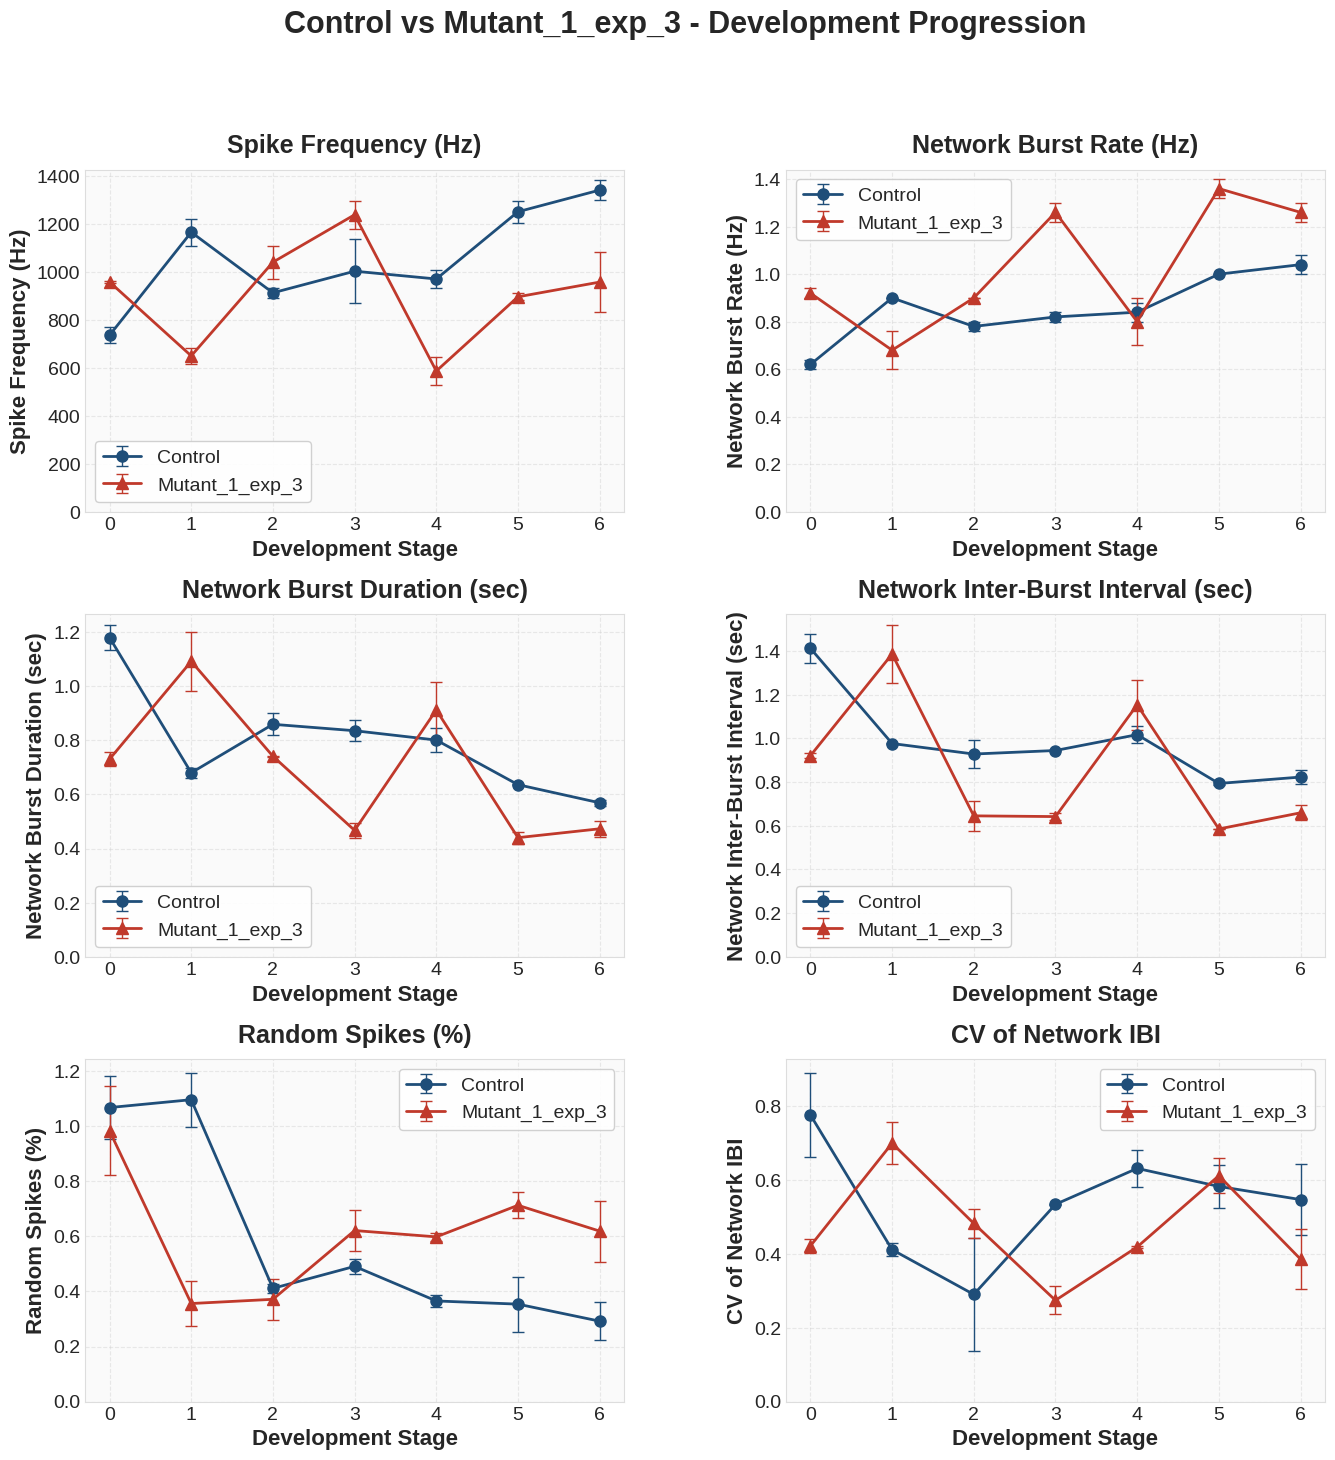


2. Creating Control vs Mutant_2_exp_1 plot...
Plot saved as: control_vs_mutant2exp1_development_progression.png


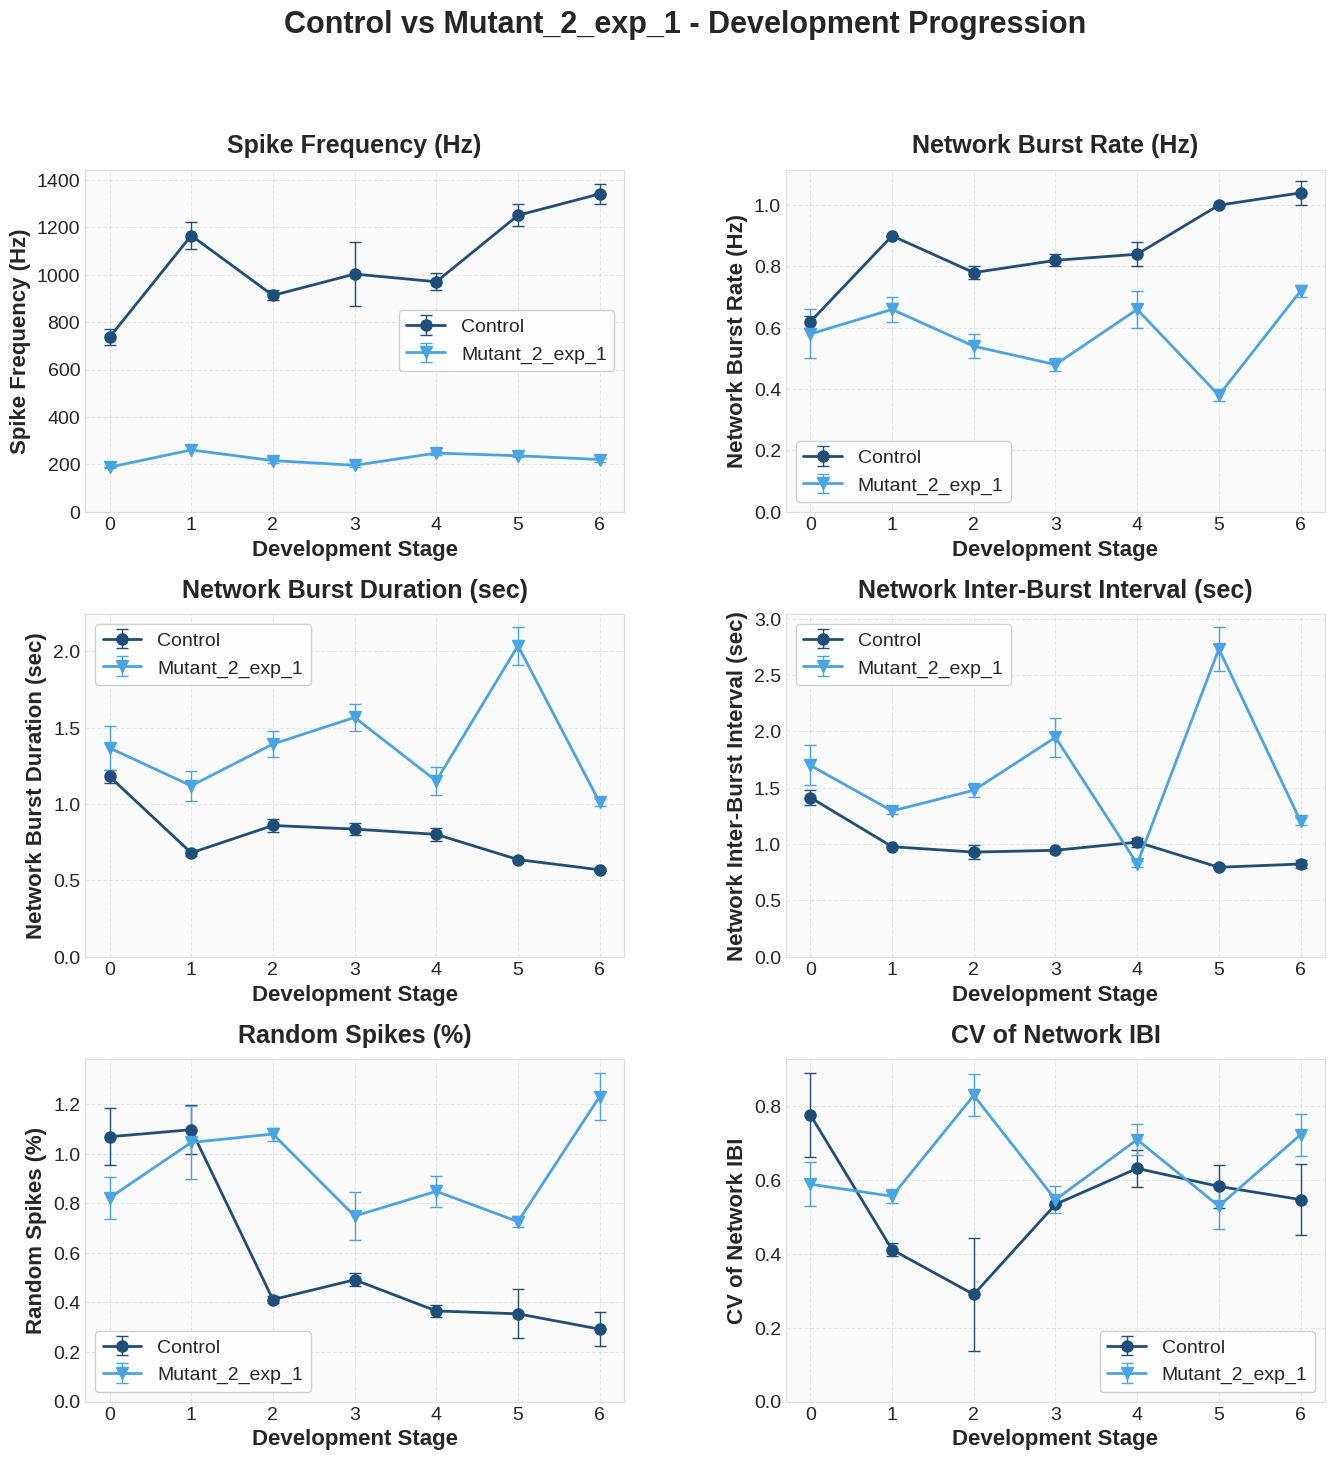


All plots created successfully using the exact same plotting function from your original code!
Note: Each plot shows all 6 metrics, so you can see your requested metrics within the complete context.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use the exact same plotting function from your original code, just with filtered profiles
def plot_development_stages(data, metrics, profiles_to_plot, title_prefix, filename_prefix):
    stages = sorted(data['Development_Stage'].unique())
    
    # Map metric names to nicer display names
    metric_display_names = {
        'Spike_Frequency_Hz': 'Spike Frequency (Hz)',
        'Network_Burst_Rate_Hz': 'Network Burst Rate (Hz)',
        'Mean_Network_Burst_Duration_sec': 'Network Burst Duration (sec)',
        'Mean_Network_IBI_sec': 'Network Inter-Burst Interval (sec)',
        'Random_Spikes_Pct': 'Random Spikes (%)',
        'CV_Network_IBI': 'CV of Network IBI'
    }
    
    # Set up the figure with a clean, professional style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 14})  # Increase base font size globally
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), dpi=100)  # Slightly larger figure
    axes = axes.flatten()
    
    # Set up a color palette with professional colors
    profile_colors = {
        'Control': '#1F4E79',      # dark blue
        'Mutant_1_exp_1': '#2D7D46',  # medium green
        'Mutant_1_exp_2': '#F6921E',  # orange
        'Mutant_1_exp_3': '#C0392B',  # dark purple
        'Mutant_2_exp_1': '#4AA4E3',  # light blue
        'Mutant_2_exp_3': '#C0392B'   # red
    }
    
    # Set up marker styles for consistent visualization
    profile_markers = {
        'Control': 'o',  # circle
        'Mutant_1_exp_1': 's',  # square
        'Mutant_1_exp_2': 'd',  # diamond
        'Mutant_1_exp_3': '^',  # triangle up
        'Mutant_2_exp_1': 'v',  # triangle down
        'Mutant_2_exp_3': 'p'   # pentagon
    }
    
    # Modified: Using solid lines for all profiles
    profile_linestyles = {
        'Control': '-',  # solid
        'Mutant_1_exp_1': '-',  # solid
        'Mutant_1_exp_2': '-',  # solid
        'Mutant_1_exp_3': '-',  # solid
        'Mutant_2_exp_1': '-',  # solid
        'Mutant_2_exp_3': '-'   # solid
    }
    
    for i, metric in enumerate(metrics):
        if i < len(axes):  # Make sure we don't exceed the number of subplots
            ax = axes[i]
            
            # Calculate means and standard errors by profile and stage
            grouped = data[data['Profile'].isin(profiles_to_plot)].groupby(['Profile', 'Development_Stage'])[metric].agg(['mean', 'std', 'count'])
            grouped['se'] = grouped['std'] / np.sqrt(grouped['count'])
            
            # Plot each profile
            for profile in profiles_to_plot:
                if profile in grouped.index.get_level_values(0):
                    profile_data = grouped.loc[profile]
                    means = [profile_data.loc[stage, 'mean'] if stage in profile_data.index else np.nan for stage in stages]
                    errors = [profile_data.loc[stage, 'se'] if stage in profile_data.index else np.nan for stage in stages]
                    
                    # Modified: Thinner error bars, solid lines for all profiles
                    ax.errorbar(
                        stages, means, yerr=errors, 
                        marker=profile_markers.get(profile, 'o'),
                        linestyle=profile_linestyles.get(profile, '-'),
                        color=profile_colors.get(profile, None),
                        markersize=8, capsize=4, elinewidth=1.0, linewidth=2.0,  # Increased marker size and line width
                        label=profile
                    )
            
            # Set title and labels with improved typography and larger fonts
            display_name = metric_display_names.get(metric, metric.replace('_', ' '))
            ax.set_title(display_name, fontsize=18, fontweight='bold', pad=12)  # Increased font size and padding
            ax.set_xlabel('Development Stage', fontsize=16, fontweight='semibold')  # Increased font size
            ax.set_ylabel(display_name, fontsize=16, fontweight='semibold')  # Increased font size
            
            # Modified: Set y-axis to start from 0
            ax.set_ylim(bottom=0)
            
            # Improve x-axis - ensure all stages are shown with larger tick labels
            ax.set_xticks(stages)
            ax.tick_params(axis='both', which='major', labelsize=14)  # Increased tick label size
            
            # Enhance grid appearance
            ax.grid(True, linestyle='--', alpha=0.4, color='#CCCCCC')  # Lighter grid
            
            # Add a light background to highlight the plot area
            ax.set_facecolor('#FAFAFA')  # Even lighter background
            
            # Add legend with better positioning and appearance
            leg = ax.legend(loc='best', frameon=True, framealpha=0.9, fontsize=14)  # Increased legend font size
            leg.get_frame().set_edgecolor('#CCCCCC')
            
            # Add a subtle border around the plot
            for spine in ax.spines.values():
                spine.set_color('#DDDDDD')
                spine.set_linewidth(0.8)
    
    # Add an overall title with improved styling and larger font
    plt.suptitle(f"{title_prefix} - Development Progression", 
                fontsize=22, fontweight='bold', y=0.98)  # Increased title font size
    
    # Improve overall figure appearance
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.patch.set_facecolor('white')
    
    # Use a simple filename that will show up in the file explorer
    output_filename = f"{filename_prefix}_development_progression.png"
    
    # Save the figure with higher quality
    plt.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Plot saved as: {output_filename}")
    
    # Display the plot
    plt.show()
    
    return fig

# Define the exact same metrics from your original code
dev_metrics = [
    'Spike_Frequency_Hz',
    'Network_Burst_Rate_Hz',
    'Mean_Network_Burst_Duration_sec', 
    'Mean_Network_IBI_sec',
    'Random_Spikes_Pct',
    'CV_Network_IBI'
]

# File paths for the CSV files
csv_paths = [
    '/home/hkisic/projects/BEP/final_result_batch_1/analysis_results/lfp_analysis_20250505_143903.csv',
    '/home/hkisic/projects/BEP/final_result_batch_2/analysis_results/lfp_analysis_20250505_150211.csv',
    '/home/hkisic/projects/BEP/final_result_batch_3/analysis_results/lfp_analysis_20250505_151054.csv',
    '/home/hkisic/projects/BEP/final_result_batch_4/analysis_results/lfp_analysis_20250505_151858.csv',
    '/home/hkisic/projects/BEP/final_result_batch_5/analysis_results/lfp_analysis_20250505_152430.csv'
]

# Function to load and combine all CSV files
def load_all_data(csv_paths):
    all_data = []
    for path in csv_paths:
        try:
            # Read the CSV file
            df = pd.read_csv(path)
            # Add the batch number based on the file path
            batch_num = int(path.split('batch_')[1][0])
            df['Batch'] = batch_num
            all_data.append(df)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    # Combine all the dataframes
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        print("No data could be loaded.")
        return None

# Load all the data
all_data = load_all_data(csv_paths)

# Check if data was loaded successfully
if all_data is None:
    print("No data to analyze.")
else:
    # Create a unique profile identifier by combining Experiment_Type and Experiment_Number
    all_data['Profile'] = all_data['Experiment_Type'] + '_exp_' + all_data['Experiment_Number'].astype(str)
    # Replace 'Control_exp_0' with just 'Control' for better readability
    all_data['Profile'] = all_data['Profile'].str.replace('Control_exp_0', 'Control')
    
    print("Creating specific profile comparison plots using the original plotting function...")
    
    # Plot 1: Control and Mutant_1_exp_3 (for spike rate, network burst rate, random spike percentage)
    control_mutant1exp3_profiles = ['Control', 'Mutant_1_exp_3']
    print("\n1. Creating Control vs Mutant_1_exp_3 plot...")
    fig1 = plot_development_stages(all_data, dev_metrics, control_mutant1exp3_profiles, 
                                 "Control vs Mutant_1_exp_3", "control_vs_mutant1exp3")
    
    # Plot 2: Control and Mutant_2_exp_1 (for network interburst interval)
    control_mutant2exp1_profiles = ['Control', 'Mutant_2_exp_1']
    print("\n2. Creating Control vs Mutant_2_exp_1 plot...")
    fig2 = plot_development_stages(all_data, dev_metrics, control_mutant2exp1_profiles, 
                                 "Control vs Mutant_2_exp_1", "control_vs_mutant2exp1")
    
    print("\nAll plots created successfully using the exact same plotting function from your original code!")
    print("Note: Each plot shows all 6 metrics, so you can see your requested metrics within the complete context.")

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

# File paths
mutant1_path = '/home/hkisic/projects/BEP/final_result_batch_1/Mutant_1_exp_3/Mutant_1_exp_3_data_3_20250501_154634.pkl'
mutant2_path = '/home/hkisic/projects/BEP/final_result_batch_1/Mutant_2_exp_1/Mutant_2_exp_1_data_3_20250501_154634.pkl'

# Function to apply a low-pass filter to highlight slower synchronization patterns
def lowpass_filter(data, cutoff_freq, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

# Function to extract and process data from pickle files
def process_file(file_path, downsample_factor=10):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Print the keys to see what's available
    print(f"Keys in data: {list(data.keys())}")
    
    result = {}
    
    # Store the original data for trace plotting
    result['raw_data'] = data
    
    # Check if the necessary data is present for the voltage heatmap
    if 'V_exc' in data and 'V_inh' in data and 'Imid_exc' in data and 'Imid_inh' in data:
        # Get voltage data
        v_exc = data['V_exc']
        v_inh = data['V_inh']
        
        # Get intrinsic current data
        i_exc = data['Imid_exc']
        i_inh = data['Imid_inh']
        
        print(f"V_exc shape: {v_exc.shape}")
        print(f"V_inh shape: {v_inh.shape}")
        print(f"Imid_exc shape: {i_exc.shape}")
        print(f"Imid_inh shape: {i_inh.shape}")
        
        # Store original shapes
        result['n_exc_orig'] = v_exc.shape[0]
        result['n_inh_orig'] = v_inh.shape[0]
        result['n_time_orig'] = v_exc.shape[1]
        
        # Downsample neurons (first dimension) and time steps (second dimension)
        # For excitatory neurons
        n_exc = v_exc.shape[0]
        n_time = v_exc.shape[1]
        n_exc_down = n_exc // downsample_factor
        n_time_down = n_time // downsample_factor
        
        # Downsample by taking regular spaced samples
        exc_indices = np.linspace(0, n_exc-1, n_exc_down, dtype=int)
        time_indices = np.linspace(0, n_time-1, n_time_down, dtype=int)
        
        # Extract downsampled data for excitatory neurons
        v_exc_down = v_exc[exc_indices, :][:, time_indices]
        
        # Make sure i_exc has the right shape for downsampling
        if len(i_exc.shape) == 2 and i_exc.shape[1] == v_exc.shape[1]:
            # If it has a time dimension, downsample in both dimensions
            i_exc_down = i_exc[exc_indices, :][:, time_indices]
            i_exc_mean = np.mean(i_exc_down, axis=1)
        else:
            # Just take the corresponding neuron currents
            i_exc_mean = i_exc[exc_indices]
        
        # For inhibitory neurons
        n_inh = v_inh.shape[0]
        n_inh_down = max(1, n_inh // downsample_factor)  # Ensure at least 1 inhibitory neuron
        
        # Downsample inhibitory neurons
        inh_indices = np.linspace(0, n_inh-1, n_inh_down, dtype=int)
        
        # Extract downsampled data for inhibitory neurons
        v_inh_down = v_inh[inh_indices, :][:, time_indices]
        
        # Make sure i_inh has the right shape for downsampling
        if len(i_inh.shape) == 2 and i_inh.shape[1] == v_inh.shape[1]:
            # If it has a time dimension, downsample in both dimensions
            i_inh_down = i_inh[inh_indices, :][:, time_indices]
            i_inh_mean = np.mean(i_inh_down, axis=1)
        else:
            # Just take the corresponding neuron currents
            i_inh_mean = i_inh[inh_indices]
        
        # Concatenate excitatory and inhibitory data
        v_all = np.vstack((v_exc_down, v_inh_down))
        i_all_mean = np.concatenate((i_exc_mean, i_inh_mean))
        
        # Apply low-pass filter to highlight synchronization patterns
        # Assuming a sampling rate of 1000 Hz and wanting to retain features below 50 Hz
        fs = 1000  # Sampling rate (Hz) - adjust according to your data
        cutoff = 50  # Cut-off frequency (Hz)
        v_all_filtered = lowpass_filter(v_all, cutoff, fs)
        
        # Get time data
        if 'V_time' in data:
            time_steps = data['V_time'][time_indices]
        else:
            time_steps = time_indices
        
        # Store indices for future reference
        result['exc_indices'] = exc_indices
        result['inh_indices'] = inh_indices
        result['time_indices'] = time_indices
        
        # Store processed data
        result['voltage'] = v_all
        result['voltage_filtered'] = v_all_filtered
        result['intrinsic_current'] = i_all_mean
        result['time_steps'] = time_steps
        result['path'] = file_path
        result['n_exc'] = n_exc_down
        result['n_inh'] = n_inh_down
        
        return result
    
    # If standard data structure not found, try alternative
    elif 'V_all' in data and 'Imid_all' in data:
        # Process similarly to above for V_all case
        v_all = data['V_all']
        i_all = data['Imid_all']
        
        # Store original dimensions
        result['n_exc_orig'] = v_all.shape[0]  # No distinction between exc/inh
        result['n_inh_orig'] = 0
        result['n_time_orig'] = v_all.shape[1]
        
        # Downsample
        n_neurons = v_all.shape[0]
        n_time = v_all.shape[1]
        n_neurons_down = n_neurons // downsample_factor
        n_time_down = n_time // downsample_factor
        
        # Select indices for downsampling
        neuron_indices = np.linspace(0, n_neurons-1, n_neurons_down, dtype=int)
        time_indices = np.linspace(0, n_time-1, n_time_down, dtype=int)
        
        # Extract downsampled data
        v_all_down = v_all[neuron_indices, :][:, time_indices]
        
        # Handle intrinsic current depending on its shape
        if len(i_all.shape) == 2 and i_all.shape[1] == v_all.shape[1]:
            i_all_down = i_all[neuron_indices, :][:, time_indices]
            i_all_mean = np.mean(i_all_down, axis=1)
        else:
            i_all_mean = i_all[neuron_indices]
        
        # Apply low-pass filter
        fs = 1000  # Sampling rate (Hz) - adjust according to your data
        cutoff = 50  # Cut-off frequency (Hz)
        v_all_filtered = lowpass_filter(v_all_down, cutoff, fs)
        
        # Get time data
        if 'V_time' in data:
            time_steps = data['V_time'][time_indices]
        else:
            time_steps = time_indices
        
        # Store indices for future reference
        result['exc_indices'] = neuron_indices  # In this case, no distinction between exc/inh
        result['inh_indices'] = []
        result['time_indices'] = time_indices
        
        # Store processed data
        result['voltage'] = v_all_down
        result['voltage_filtered'] = v_all_filtered
        result['intrinsic_current'] = i_all_mean
        result['time_steps'] = time_steps
        result['path'] = file_path
        result['n_exc'] = n_neurons_down
        result['n_inh'] = 0
        
        return result
    
    else:
        print(f"Required voltage and current data not found in {file_path}")
        return None

# Process both files
datasets = []
downsample_factor = 15  # Adjust for visualization clarity

for path in [mutant1_path, mutant2_path]:
    try:
        result = process_file(path, downsample_factor)
        if result is not None:
            datasets.append(result)
            print(f"Successfully processed {path}")
        else:
            print(f"No usable data found in {path}")
    except Exception as e:
        print(f"Error processing {path}: {str(e)}")

# Create visualizations for each dataset
for data in datasets:
    voltage = data['voltage']
    voltage_filtered = data['voltage_filtered']
    intrinsic_current = data['intrinsic_current']
    time_steps = data['time_steps']
    path = data['path']
    n_exc = data['n_exc']
    n_inh = data['n_inh']
    raw_data = data['raw_data']
    
    # Get model name for plot titles
    model_name = path.split('/')[-2]  # Extract model name from path
    
    # Get neuron indices sorted by increasing intrinsic current
    sorted_indices = np.argsort(intrinsic_current)
    
    # Reorder voltage matrices according to sorted indices
    sorted_voltage = voltage[sorted_indices, :]
    sorted_voltage_filtered = voltage_filtered[sorted_indices, :]
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Membrane voltage heatmap (original)
    plt.subplot(2, 2, 1)
    vmin = np.percentile(sorted_voltage, 5)
    vmax = np.percentile(sorted_voltage, 95)
    sns.heatmap(sorted_voltage, 
                cmap='seismic',
                center=np.mean(sorted_voltage),
                vmin=vmin, vmax=vmax,
                cbar_kws={'label': 'Membrane Voltage (V)'})
    plt.xlabel('Time Steps')
    plt.ylabel('Neurons (sorted by intrinsic current)')
    plt.title('Membrane Voltage Heatmap')
    
    # Add boundary line between excitatory and inhibitory neurons
    if n_exc > 0 and n_inh > 0:
        exc_mask = np.zeros(len(sorted_indices), dtype=bool)
        exc_mask[sorted_indices < n_exc] = True
        inh_positions = np.where(~exc_mask)[0]
        if len(inh_positions) > 0:
            first_inh = inh_positions[0]
            plt.axhline(y=first_inh, color='black', linestyle='--', 
                      linewidth=2, label='Exc-Inh Boundary')
            plt.legend(loc='upper right')
    
    # Plot 2: Filtered membrane voltage heatmap
    plt.subplot(2, 2, 2)
    vmin_f = np.percentile(sorted_voltage_filtered, 5)
    vmax_f = np.percentile(sorted_voltage_filtered, 95)
    sns.heatmap(sorted_voltage_filtered, 
                cmap='seismic',
                center=np.mean(sorted_voltage_filtered),
                vmin=vmin_f, vmax=vmax_f,
                cbar_kws={'label': 'Filtered Voltage (V)'})
    plt.xlabel('Time Steps')
    plt.ylabel('Neurons (sorted by intrinsic current)')
    plt.title('Filtered Membrane Voltage (Low-Pass 50Hz)')
    
    # Plot 3: Select neuron voltage traces
    plt.subplot(2, 2, 3)
    
    # Select a few neurons from different parts of the array
    n_neurons = sorted_voltage.shape[0]
    sample_indices = np.linspace(0, n_neurons-1, 5, dtype=int)
    
    for idx in sample_indices:
        plt.plot(time_steps, sorted_voltage[idx, :], label=f'Neuron {idx}')
    
    plt.xlabel('Time')
    plt.ylabel('Membrane Voltage (V)')
    plt.title('Membrane Voltage Traces for Selected Neurons')
    plt.legend()
    
    # Plot 4: Synchronization visualization - cross-correlation heatmap
    plt.subplot(2, 2, 4)
    
    # Compute correlation matrix between neurons
    # Use filtered voltage to better highlight synchronization
    correlation_matrix = np.corrcoef(sorted_voltage_filtered)
    
    # Plot correlation matrix as heatmap
    sns.heatmap(correlation_matrix, 
                cmap='coolwarm',
                vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlation'})
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.title('Cross-Correlation Matrix Between Neurons')
    
    # Save the combined figure
    plt.tight_layout()
    plt.savefig(f"voltage_analysis_{model_name}.png", dpi=300)
    print(f"Saved combined analysis to voltage_analysis_{model_name}.png")
    
    # Create a separate plot for Imid and adaptation variables
    try:
        plt.figure(figsize=(12, 8))
        
        # Try to extract original Imid for a few selected neurons
        if 'Imid_exc' in raw_data and 'Imid_inh' in raw_data:
            # Get original data
            Imid_exc = raw_data['Imid_exc']
            Imid_inh = raw_data['Imid_inh']
            
            # Get some sample neurons for plotting
            n_samples = 3  # Number of sample neurons
            
            # Get original indices that correspond to our downsampled neurons
            exc_indices = data['exc_indices']
            inh_indices = data['inh_indices']
            
            # Plot excitatory neuron currents
            for i in range(min(n_samples, len(exc_indices))):
                if len(Imid_exc.shape) == 2:  # If it has a time dimension
                    plt.subplot(2, 1, 1)
                    plt.plot(Imid_exc[exc_indices[i], :], 
                             label=f'Exc Neuron {exc_indices[i]}')
            
            # Plot inhibitory neuron currents if available
            if len(inh_indices) > 0:
                for i in range(min(n_samples, len(inh_indices))):
                    if len(Imid_inh.shape) == 2:  # If it has a time dimension
                        plt.subplot(2, 1, 1)
                        plt.plot(Imid_inh[inh_indices[i], :], 
                                 linestyle='--',
                                 label=f'Inh Neuron {inh_indices[i]}')
            
            plt.xlabel('Time Steps')
            plt.ylabel('Intrinsic Current')
            plt.title('Intrinsic Current (Imid) for Sample Neurons')
            plt.legend()
            
            # Try to plot adaptation variables if available
            if 'adaptation' in raw_data or 'w' in raw_data:
                adapt_var = raw_data.get('adaptation', raw_data.get('w', None))
                
                if adapt_var is not None and len(adapt_var.shape) == 2:
                    plt.subplot(2, 1, 2)
                    
                    # Plot adaptation for same sample excitatory neurons
                    for i in range(min(n_samples, len(exc_indices))):
                        plt.plot(adapt_var[exc_indices[i], :], 
                                 label=f'Exc Neuron {exc_indices[i]}')
                    
                    # Plot adaptation for same sample inhibitory neurons
                    if len(inh_indices) > 0:
                        for i in range(min(n_samples, len(inh_indices))):
                            plt.plot(adapt_var[inh_indices[i], :], 
                                     linestyle='--',
                                     label=f'Inh Neuron {inh_indices[i]}')
                    
                    plt.xlabel('Time Steps')
                    plt.ylabel('Adaptation Variable')
                    plt.title('Adaptation Variable for Sample Neurons')
                    plt.legend()
        
        plt.tight_layout()
        plt.savefig(f"currents_and_adaptation_{model_name}.png", dpi=300)
        print(f"Saved current and adaptation plot to currents_and_adaptation_{model_name}.png")
    
    except Exception as e:
        print(f"Could not create current and adaptation plot: {str(e)}")

print("Processing complete!")

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

def create_raster_plot(file_path, save_dir):
    """
    Create a raster plot from an LFP file, removing empty electrode rows
    
    Parameters:
    -----------
    file_path : str
        Path to the LFP data file (.npy)
    save_dir : str
        Directory to save the raster plot
    """
    # Analysis parameters
    fs = 1000  # Sampling frequency Hz
    cutoff_frequency = 0.5  # High-pass filter cutoff
    transient_cutoff = 2 * fs  # Skip first 2 seconds for transient
    runtime = 10  # Total runtime in seconds
    empty_indices = [0, 3, 12, 15]  # Empty electrode indices
    
    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Extract experiment info from the file path
    parts = file_path.split('/')
    exp_folder = parts[-2]  # The folder containing the file
    file_name = os.path.basename(file_path)
    file_name_no_ext = os.path.splitext(file_name)[0]
    
    # Extract development stage from filename
    dev_stage = None
    if '_experiment_' in file_name:
        dev_stage_str = file_name.split('_experiment_')[1].split('_')[0]
        if dev_stage_str.isdigit():
            dev_stage = int(dev_stage_str)
    elif '_exp_' in file_name:
        # For mutant files
        for part in file_name.split('_'):
            if part.isdigit():
                dev_stage = int(part)
                break
    
    if dev_stage is None:
        dev_stage = "Unknown"
    
    # Load data
    print(f"Processing {file_name} (Dev Stage: {dev_stage})...")
    lfp_data = np.load(file_path)
    
    # Process each electrode
    spike_indices_list = []
    electrode_numbers = []  # To track which electrode numbers are valid
    
    # Function to apply high-pass filter
    def highpass_filter(signal):
        nyquist = 0.5 * fs
        normalized_cutoff = cutoff_frequency / nyquist
        b, a = butter(4, normalized_cutoff, btype='high', analog=False)
        return filtfilt(b, a, signal)
    
    # Process each electrode
    elec_index = 0
    for i in range(16):
        if i not in empty_indices:
            # Filter signal
            filtered_signal = highpass_filter(lfp_data[elec_index])
            
            # Skip transient period for analysis
            signal_clean = filtered_signal[transient_cutoff:]
            
            # IMPROVED THRESHOLD CALCULATION
            # For oscillatory signals, use peak detection to find local maxima
            # then set threshold at a percentile of these peaks
            peaks, _ = find_peaks(signal_clean, distance=int(0.05*fs))  # Min 50ms between peaks
            if len(peaks) > 5:  # If we have enough peaks
                peak_values = signal_clean[peaks]
                threshold = np.percentile(peak_values, 50)  # Use 50th percentile of peaks
            else:
                # Fallback to a more conservative approach if peak detection fails
                baseline = np.median(signal_clean)
                threshold = baseline + 2 * np.median(np.abs(signal_clean - baseline))
            
            # Detect spikes (using improved threshold)
            spike_indices = np.where(filtered_signal[transient_cutoff:] > threshold)[0] + transient_cutoff
            
            # Store indices and electrode number if there are spikes
            if len(spike_indices) > 0:
                spike_indices_list.append(spike_indices)
                electrode_numbers.append(i)
            
            elec_index += 1
    
    # Create the raster plot
    create_raster_plot_for_file(spike_indices_list, electrode_numbers, fs, runtime, 
                             transient_cutoff, exp_folder, dev_stage, file_name_no_ext, save_dir)

def create_raster_plot_for_file(spike_indices_list, electrode_numbers, fs, runtime, 
                             transient_cutoff, exp_folder, dev_stage, file_name_no_ext, save_dir):
    """
    Create a raster plot from spike indices data
    """
    # Time vector for plotting (2-10 seconds)
    start_time = 2  # seconds
    start_idx = start_time * fs
    
    # Create a raster plot figure
    fig = plt.figure(figsize=(20, 10))  # Wide and tall figure just for raster
    ax = fig.add_subplot(111)  # Use the entire figure

    # Prepare data for raster plot - filter spikes to only show those after start_time
    spike_times_by_electrode = []
    
    for spike_indices in spike_indices_list:
        visible_spikes = spike_indices[(spike_indices >= start_idx) & (spike_indices < runtime * fs)]
        adjusted_times = (visible_spikes - start_idx) / fs + start_time
        spike_times_by_electrode.append(adjusted_times)

    # Create the raster plot
    ax.eventplot(spike_times_by_electrode, 
              lineoffsets=range(len(electrode_numbers)),  # Sequential positions without gaps
              linelengths=1.0, linewidths=1.5, colors='black')

    # Add labels and styling
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Electrode', fontsize=14)
    ax.set_title(f"LFP Spike Raster Plot - {exp_folder} - Dev Stage {dev_stage}", 
              fontsize=16)
    ax.set_xlim(start_time, runtime)

    # Set y-ticks with the actual electrode numbers as labels
    ax.set_yticks(range(len(electrode_numbers)))
    ax.set_yticklabels([str(num) for num in electrode_numbers])

    # Add timestamps at the top with one-second intervals
    ax.set_xticks(np.arange(start_time, runtime+1, 1))

    # Improve grid visibility
    ax.grid(True, alpha=0.5)
    ax.xaxis.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    
    # Save the raster plot
    raster_plot_path = os.path.join(save_dir, f"{file_name_no_ext}_raster_plot.png")
    plt.savefig(raster_plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Saved raster plot to: {raster_plot_path}")

def main():
    # List of files to process
    lfp_files = [
        "/home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/LFP_Control_experiment_0_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/LFP_Control_experiment_6_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_1_exp_1/LFP_Mutant_1_exp_1_0_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_1_exp_1/LFP_Mutant_1_exp_1_6_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_1_exp_2/LFP_Mutant_1_exp_2_0_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_1_exp_2/LFP_Mutant_1_exp_2_6_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_1_exp_3/LFP_Mutant_1_exp_3_0_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_1_exp_3/LFP_Mutant_1_exp_3_6_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_2_exp_1/LFP_Mutant_2_exp_1_0_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_2_exp_1/LFP_Mutant_2_exp_1_6_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_2_exp_3/LFP_Mutant_2_exp_3_0_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_2_exp_3/LFP_Mutant_2_exp_3_6_20250501_154634.npy"
    ]
    
    # Save directory
    save_dir = "/home/hkisic/projects/BEP/fixed_rasters_1"
    
    # Process each file
    for file_path in lfp_files:
        create_raster_plot(file_path, save_dir)
    
    print(f"\nAll 12 raster plots saved to: {save_dir}")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.signal import butter, filtfilt, find_peaks
import os

def plot_lfp_traces(file_paths, save_dir):
    """
    Plot LFP traces with thresholds and spike annotations, with borders and slight spacing
    
    Parameters:
    -----------
    file_paths : list
        Paths to the LFP data files (.npy)
    save_dir : str
        Directory to save the output plots
    """
    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Analysis parameters
    fs = 1000  # Sampling frequency Hz
    cutoff_frequency = 0.5  # High-pass filter cutoff
    transient_cutoff = 2 * fs  # Skip first 2 seconds for transient
    runtime = 10  # Total runtime in seconds
    empty_indices = [0, 3, 12, 15]  # Empty electrode indices
    
    # Set up extra large fonts for y-axis labels only
    plt.rcParams.update({
        'ytick.labelsize': 30,    # Y-tick label size
    })
    
    # Function to apply high-pass filter
    def highpass_filter(signal):
        nyquist = 0.5 * fs
        normalized_cutoff = cutoff_frequency / nyquist
        b, a = butter(4, normalized_cutoff, btype='high', analog=False)
        return filtfilt(b, a, signal)
    
    # Process each file
    for file_path in file_paths:
        # Extract file information
        file_name = os.path.basename(file_path)
        file_name_no_ext = os.path.splitext(file_name)[0]
        
        # Load data
        print(f"Processing {file_name}...")
        lfp_data = np.load(file_path)
        
        # Create a figure for this file
        fig = plt.figure(figsize=(30, 18))
        
        # Create GridSpec with moderate spacing to separate subplots
        gs = GridSpec(4, 4, figure=fig, wspace=0.2, hspace=0.2)  # Increased spacing
        
        # Time vector for plotting (2-10 seconds)
        start_time = 2  # seconds
        start_idx = start_time * fs
        end_idx = runtime * fs
        time = np.linspace(start_time, runtime, end_idx - start_idx)
        
        # Plot time series for each electrode
        elec_index = 0
        for i in range(4):
            for j in range(4):
                grid_idx = i * 4 + j
                if grid_idx not in empty_indices:
                    ax = fig.add_subplot(gs[i, j])
                    
                    # Filter signal
                    filtered_signal = highpass_filter(lfp_data[elec_index])
                    
                    # Calculate threshold
                    signal_clean = filtered_signal[transient_cutoff:]
                    peaks, _ = find_peaks(signal_clean, distance=int(0.05*fs))
                    
                    if len(peaks) > 5:
                        peak_values = signal_clean[peaks]
                        threshold = np.percentile(peak_values, 50)
                    else:
                        baseline = np.median(signal_clean)
                        threshold = baseline + 2 * np.median(np.abs(signal_clean - baseline))
                    
                    # Detect spikes
                    spike_indices = np.where(filtered_signal[transient_cutoff:] > threshold)[0] + transient_cutoff
                    
                    # Plot LFP signal with thicker line
                    ax.plot(time, filtered_signal[start_idx:end_idx], 
                          linewidth=2.0, color='blue')
                    
                    # Plot threshold
                    ax.axhline(y=threshold, color='r', linestyle='--', linewidth=2.0)
                    
                    # Plot detected spikes with larger markers
                    visible_spikes = spike_indices[(spike_indices >= start_idx) & (spike_indices < end_idx)]
                    
                    if len(visible_spikes) > 0:
                        adjusted_indices = visible_spikes - start_idx
                        ax.scatter(time[adjusted_indices], 
                                filtered_signal[visible_spikes], 
                                color='g', marker='o', s=60, zorder=3)
                    
                    # Remove all axis labels
                    ax.set_xlabel("")
                    ax.set_ylabel("")
                    
                    # Remove x-ticks and x-tick labels completely
                    ax.set_xticks([])
                    ax.set_xticklabels([])
                    
                    # Format y-ticks to be more compact and larger
                    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
                    
                    # Add very light grid
                    ax.grid(True, alpha=0.2)
                    
                    # Set moderate margins
                    ax.margins(x=0.02, y=0.05)
                    
                    # Ensure all borders are visible
                    for spine in ['top', 'right', 'bottom', 'left']:
                        ax.spines[spine].set_visible(True)
                        ax.spines[spine].set_linewidth(1.0)  # Make borders more visible
                    
                    elec_index += 1
                else:
                    # Empty subplot for unused electrodes
                    ax = fig.add_subplot(gs[i, j])
                    ax.set_visible(False)
        
        # Set moderate padding
        plt.tight_layout(pad=0.5)
        
        # Save the plot with high DPI for print quality
        output_path = os.path.join(save_dir, f"{file_name_no_ext}_lfp_traces_bordered.png")
        plt.savefig(output_path, dpi=600, bbox_inches='tight')
        plt.close(fig)
        
        print(f"Saved LFP traces to: {output_path}")

def main():
    # List of files to process
    lfp_files = [
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_1_exp_3/LFP_Mutant_1_exp_3_3_20250501_154634.npy",
        "/home/hkisic/projects/BEP/final_result_batch_1/Mutant_2_exp_1/LFP_Mutant_2_exp_1_3_20250501_154634.npy"
    ]
    
    # Save directory
    save_dir = "/home/hkisic/projects/BEP/lfp_traces"
    
    # Plot LFP traces
    plot_lfp_traces(lfp_files, save_dir)

if __name__ == "__main__":
    main()
    

Successfully loaded: /home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/Control_experiment_data_0_20250501_154634.pkl
Successfully loaded: /home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/Control_experiment_data_1_20250501_154634.pkl
Successfully loaded: /home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/Control_experiment_data_2_20250501_154634.pkl
Successfully loaded: /home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/Control_experiment_data_3_20250501_154634.pkl
Successfully loaded: /home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/Control_experiment_data_4_20250501_154634.pkl
Successfully loaded: /home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/Control_experiment_data_5_20250501_154634.pkl
Successfully loaded: /home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/Control_experiment_data_6_20250501_154634.pkl


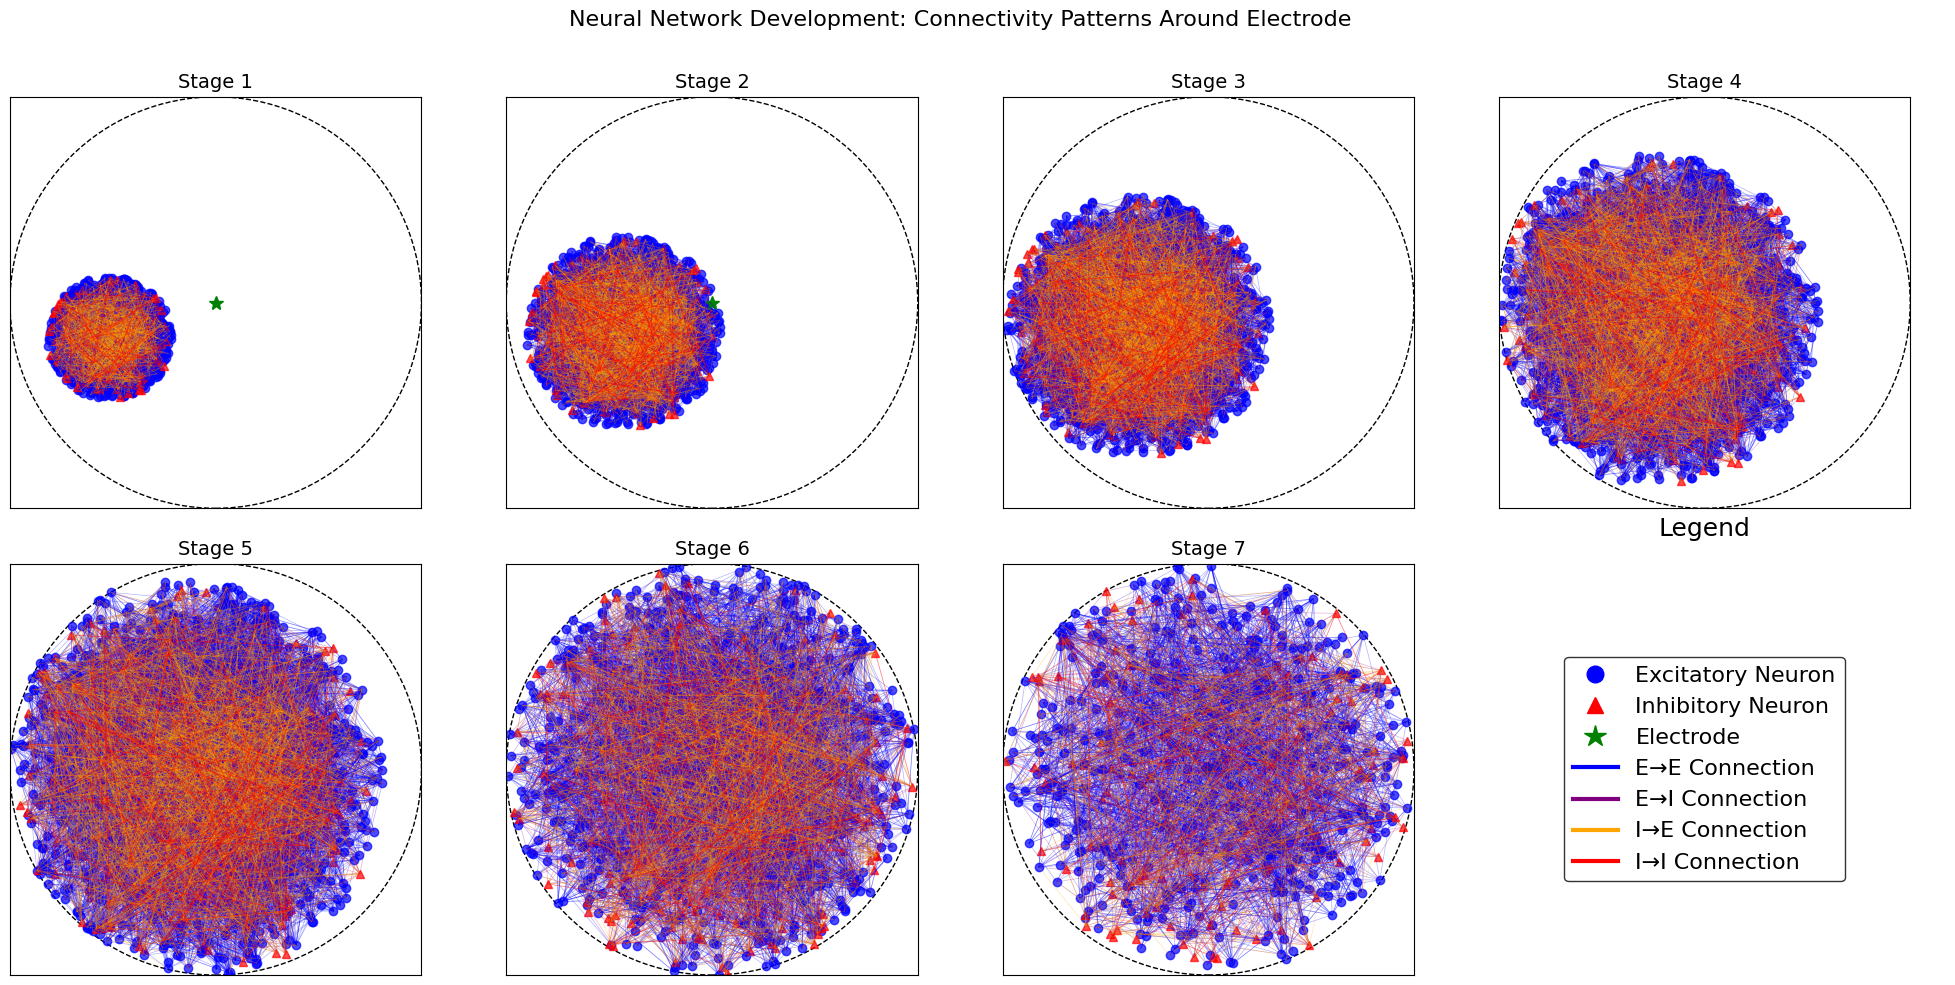

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.patches import Circle
import os

# Define the file paths for the 7 simulations
base_path = "/home/hkisic/projects/BEP/final_result_batch_1/Control_experiment/"
file_names = [
    "Control_experiment_data_0_20250501_154634.pkl",
    "Control_experiment_data_1_20250501_154634.pkl",
    "Control_experiment_data_2_20250501_154634.pkl",
    "Control_experiment_data_3_20250501_154634.pkl",
    "Control_experiment_data_4_20250501_154634.pkl",
    "Control_experiment_data_5_20250501_154634.pkl",
    "Control_experiment_data_6_20250501_154634.pkl"
]
file_paths = [os.path.join(base_path, file_name) for file_name in file_names]

# Function to load the data
def load_simulation_data(filepath):
    """Helper function to load and access the saved simulation data"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data

# Load all datasets
datasets = []
for file_path in file_paths:
    try:
        data = load_simulation_data(file_path)
        datasets.append(data)
        print(f"Successfully loaded: {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Extract neuron positions from the first dataset to determine electrode positions
# From the code, we know electrode positions were stored in variable Xe
# However, since we don't have direct access to Xe, we'll need to 
# estimate electrode positions from other available data

# Create a function to reconstruct neuron positions from the connectivity data
def reconstruct_neuron_positions(data):
    """Extract neuron positions from the connectivity data"""
    # Get EE synapse data (from excitatory to excitatory neurons)
    syn_EE = data['connectivity']['Syn_EE']
    
    # We need to extract the neuron positions based on the simulation parameters
    n_neurons = int(len(data['V_all']))  # Total number of neurons 
    n_exc = int(0.8 * n_neurons)  # 80% excitatory neurons based on the code
    n_inh = int(0.2 * n_neurons)  # 20% inhibitory neurons based on the code
    
    # We'll create placeholder arrays for the positions
    positions = np.zeros((n_neurons, 2))
    
    # Check if we can infer neuron positions
    gridsize = data['params'].get('d_max_c', 0.5)  # Default to 0.5 if not found
    
    # Generate random polar coordinates for excitatory neurons (as done in the simulation)
    np.random.seed(data['params'].get('seed', 12345))  # Use the same seed as in simulation
    
    # Generate positions as in the original simulation code
    R = gridsize  # radius of the circular grid
    
    # Generate random polar coordinates for excitatory neurons
    r_exc = R * np.sqrt(np.random.rand(n_exc))
    theta_exc = np.random.rand(n_exc) * 2 * np.pi
    
    # Convert polar to Cartesian coordinates
    X_position_exc = np.column_stack((r_exc * np.cos(theta_exc), r_exc * np.sin(theta_exc)))
    
    # Generate random polar coordinates for inhibitory neurons
    r_inh = R * np.sqrt(np.random.rand(n_inh))
    theta_inh = np.random.rand(n_inh) * 2 * np.pi
    
    # Convert polar to Cartesian coordinates
    X_position_inh = np.column_stack((r_inh * np.cos(theta_inh), r_inh * np.sin(theta_inh)))
    
    # Combine positions
    positions[:n_exc] = X_position_exc
    positions[n_exc:] = X_position_inh
    
    return positions, X_position_exc, X_position_inh

# Estimate electrode positions based on the code
def estimate_electrode_positions(gridsize):
    """Estimate electrode positions based on simulation code"""
    # From the code: coor1D = np.atleast_2d(np.linspace(border - gridsize/2, gridsize/2 - border, sqrtN))
    sqrtN = 4
    border = 0.1
    
    coor1D = np.atleast_2d(np.linspace(border - gridsize/2, gridsize/2 - border, sqrtN))
    Xe = np.array([(np.transpose(coor1D) * np.ones([1, sqrtN])).flatten(), 
                   (np.ones([sqrtN, 1]) * coor1D).flatten()])
    Xe = np.delete(Xe.T, [0, 3, 12, 15], axis=0)  # As in the original code
    
    return Xe

# Plot the neurons and synapses
def plot_neurons_and_synapses(datasets, electrode_idx=0, zoom_radius=0.1):
    """Plot neurons and synapses around a selected electrode"""
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.flatten()
    
    # We'll use the last subplot for a legend/explanation
    axs[-1].axis('off')
    
    # Add a title for the whole figure
    fig.suptitle('Neural Network Development: Connectivity Patterns Around Electrode', fontsize=16)
    
    for i, data in enumerate(datasets):
        if i >= 7:  # We only have 7 subplots available
            break
            
        # Reconstruct neuron positions
        all_positions, exc_positions, inh_positions = reconstruct_neuron_positions(data)
        
        # Get the number of excitatory and inhibitory neurons
        n_exc = len(exc_positions)
        n_neurons = len(all_positions)
        
        # Estimate electrode positions
        gridsize = data['params'].get('d_max_c', 0.5)
        electrode_positions = estimate_electrode_positions(gridsize)
        
        # Focus on the selected electrode
        focus_electrode = electrode_positions[electrode_idx]
        
        # Get synapse connectivity data
        syn_EE = data['connectivity']['Syn_EE']
        syn_EI = data['connectivity']['Syn_EI']
        syn_IE = data['connectivity']['Syn_IE']
        syn_II = data['connectivity']['Syn_II']
        
        # Set up the plot
        ax = axs[i]
        
        # Remove x and y axis annotations
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        # Plot neurons within the zoom radius of the selected electrode
        for j, pos in enumerate(all_positions):
            # Calculate distance to focus electrode
            dist = np.sqrt(np.sum((pos - focus_electrode)**2))
            
            if dist <= zoom_radius:
                # Excitatory neurons are circles, inhibitory are triangles
                if j < n_exc:  # Excitatory
                    ax.plot(pos[0], pos[1], 'o', color='blue', markersize=6, alpha=0.7)
                else:  # Inhibitory
                    ax.plot(pos[0], pos[1], '^', color='red', markersize=6, alpha=0.7)
        
        # Plot the focus electrode
        ax.plot(focus_electrode[0], focus_electrode[1], '*', color='green', markersize=10)
        
        # Plot synaptic connections within the zoom radius
        # EE connections
        for j in range(len(syn_EE['i'])):
            pre_idx = syn_EE['i'][j]
            post_idx = syn_EE['j'][j]
            
            # Check if either neuron is within zoom radius
            pre_pos = all_positions[pre_idx]
            post_pos = all_positions[post_idx]
            
            pre_dist = np.sqrt(np.sum((pre_pos - focus_electrode)**2))
            post_dist = np.sqrt(np.sum((post_pos - focus_electrode)**2))
            
            if pre_dist <= zoom_radius and post_dist <= zoom_radius:
                ax.plot([pre_pos[0], post_pos[0]], [pre_pos[1], post_pos[1]], 
                         '-', color='blue', linewidth=0.5, alpha=0.3)
        
        # Also plot other types of connections (EI, IE, II) similarly
        # EI connections (excitatory to inhibitory)
        for j in range(len(syn_EI['i'])):
            pre_idx = syn_EI['i'][j]
            post_idx = syn_EI['j'][j] + n_exc  # Offset by n_exc as these are inhibitory neurons
            
            pre_pos = all_positions[pre_idx]
            post_pos = all_positions[post_idx]
            
            pre_dist = np.sqrt(np.sum((pre_pos - focus_electrode)**2))
            post_dist = np.sqrt(np.sum((post_pos - focus_electrode)**2))
            
            if pre_dist <= zoom_radius and post_dist <= zoom_radius:
                ax.plot([pre_pos[0], post_pos[0]], [pre_pos[1], post_pos[1]], 
                         '-', color='purple', linewidth=0.5, alpha=0.3)
        
        # IE connections (inhibitory to excitatory)
        for j in range(len(syn_IE['i'])):
            pre_idx = syn_IE['i'][j] + n_exc  # Offset by n_exc as these are inhibitory neurons
            post_idx = syn_IE['j'][j]
            
            pre_pos = all_positions[pre_idx]
            post_pos = all_positions[post_idx]
            
            pre_dist = np.sqrt(np.sum((pre_pos - focus_electrode)**2))
            post_dist = np.sqrt(np.sum((post_pos - focus_electrode)**2))
            
            if pre_dist <= zoom_radius and post_dist <= zoom_radius:
                ax.plot([pre_pos[0], post_pos[0]], [pre_pos[1], post_pos[1]], 
                         '-', color='orange', linewidth=0.5, alpha=0.3)
        
        # II connections (inhibitory to inhibitory)
        for j in range(len(syn_II['i'])):
            pre_idx = syn_II['i'][j] + n_exc  # Offset by n_exc
            post_idx = syn_II['j'][j] + n_exc  # Offset by n_exc
            
            pre_pos = all_positions[pre_idx]
            post_pos = all_positions[post_idx]
            
            pre_dist = np.sqrt(np.sum((pre_pos - focus_electrode)**2))
            post_dist = np.sqrt(np.sum((post_pos - focus_electrode)**2))
            
            if pre_dist <= zoom_radius and post_dist <= zoom_radius:
                ax.plot([pre_pos[0], post_pos[0]], [pre_pos[1], post_pos[1]], 
                         '-', color='red', linewidth=0.5, alpha=0.3)
        
        # Plot a circle showing the zoom radius
        circle = Circle((focus_electrode[0], focus_electrode[1]), zoom_radius, 
                        fill=False, color='black', linestyle='--')
        ax.add_patch(circle)
        
        # Set plot limits to show just the zoomed area
        ax.set_xlim(focus_electrode[0] - zoom_radius, focus_electrode[0] + zoom_radius)
        ax.set_ylim(focus_electrode[1] - zoom_radius, focus_electrode[1] + zoom_radius)
        
        # Add a simplified title showing just the stage number
        ax.set_title(f'Stage {i+1}', fontsize=14)
        
        # Equal aspect ratio so circles look like circles
        ax.set_aspect('equal')
        
    # Add a much bigger legend in the last subplot
    legend_ax = axs[-1]
    legend_handles = [
        legend_ax.plot([], [], 'o', color='blue', markersize=12)[0],
        legend_ax.plot([], [], '^', color='red', markersize=12)[0],
        legend_ax.plot([], [], '*', color='green', markersize=16)[0],
        legend_ax.plot([], [], '-', color='blue', linewidth=3)[0],
        legend_ax.plot([], [], '-', color='purple', linewidth=3)[0],
        legend_ax.plot([], [], '-', color='orange', linewidth=3)[0],
        legend_ax.plot([], [], '-', color='red', linewidth=3)[0]
    ]
    legend_labels = [
        'Excitatory Neuron',
        'Inhibitory Neuron',
        'Electrode',
        'E→E Connection',
        'E→I Connection',
        'I→E Connection',
        'I→I Connection'
    ]
    
    # Create a much bigger legend
    legend = legend_ax.legend(
        handles=legend_handles,
        labels=legend_labels,
        loc='center',
        fontsize=16,
        frameon=True,
        framealpha=0.8,
        edgecolor='black'
    )
    
    # Make the legend title bigger
    legend_ax.set_title('Legend', fontsize=18, pad=20)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.savefig('neuronal_grid_development.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the visualization
plot_neurons_and_synapses(datasets, electrode_idx=0, zoom_radius=0.15)

In [2]:
# PLOTTING THE CONNECTIVITY
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import os

# Create the output directory if it doesn't exist
output_dir = "new_connectivity_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plot files will be saved in '{output_dir}' directory")

# Files to analyze
files = [
    "final_result_batch_1/Mutant_1_exp_3/Mutant_1_exp_3_data_3_20250501_154634.pkl",
    "final_result_batch_1/Mutant_2_exp_1/Mutant_2_exp_1_data_3_20250501_154634.pkl"
]

# Function to load data
def load_simulation_data(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data

# Function to get neuron positions
def get_neuron_positions(data, N_exc, N_inh):
    """Extract neuron positions from data if available, or generate based on coordinates"""
    print("\nAttempting to extract neuron positions...")
    
    # Try to find positions in StateMon objects
    if 'StateMon_exc' in data and 'StateMon_inh' in data:
        try:
            # Check if these have x1/x2 properties
            if hasattr(data['StateMon_exc'], 'x1') and hasattr(data['StateMon_exc'], 'x2'):
                x1_exc = np.array(data['StateMon_exc'].x1)
                x2_exc = np.array(data['StateMon_exc'].x2)
                x1_inh = np.array(data['StateMon_inh'].x1)
                x2_inh = np.array(data['StateMon_inh'].x2)
                
                print("Found positions in StateMon objects!")
                return np.vstack([
                    np.column_stack((x1_exc, x2_exc)),
                    np.column_stack((x1_inh, x2_inh))
                ])
        except:
            pass
    
    # If no positions found, create random positions as in your model
    print("Creating circular random positions for neurons")
    R = 0.5  # Radius of the circular grid
    
    # Generate random polar coordinates for excitatory neurons
    r_exc = R * np.sqrt(np.random.rand(N_exc))
    theta_exc = np.random.rand(N_exc) * 2 * np.pi
    
    # Convert polar to Cartesian coordinates
    X_position_exc = np.column_stack((r_exc * np.cos(theta_exc), r_exc * np.sin(theta_exc)))
    
    # Generate random polar coordinates for inhibitory neurons
    r_inh = R * np.sqrt(np.random.rand(N_inh))
    theta_inh = np.random.rand(N_inh) * 2 * np.pi
    
    # Convert polar to Cartesian coordinates
    X_position_inh = np.column_stack((r_inh * np.cos(theta_inh), r_inh * np.sin(theta_inh)))
    
    # Combine positions
    positions = np.vstack([X_position_exc, X_position_inh])
    return positions

# ---- FIRST PASS ANALYSIS TO DETERMINE GLOBAL MIN/MAX VALUES ----
def analyze_all_files_for_scale():
    """First analyze all files to determine global min/max values for consistent color scales"""
    print("Performing first pass analysis to determine global scales...")
    
    # Store values for scaling
    all_density_values = []
    all_spatial_density_values = [[] for _ in range(4)]  # For EE, EI, IE, II
    
    for file_path in files:
        try:
            print(f"Analyzing scale data for {file_path}...")
            
            # Load the data
            data = load_simulation_data(file_path)
            
            # Extract connectivity information
            connectivity = data['connectivity']
            
            # Get neuron counts
            max_exc_idx = max(np.max(connectivity['Syn_EE']['j']), np.max(connectivity['Syn_EE']['i']))
            N_exc = max_exc_idx + 1  # Add 1 because indices are 0-based
            
            max_inh_idx = max(np.max(connectivity['Syn_II']['j']), np.max(connectivity['Syn_II']['i']))
            N_inh = max_inh_idx + 1
            
            N_total = N_exc + N_inh
            
            # Create connectivity matrix
            conn_matrix = np.zeros((N_total, N_total), dtype=int)
            
            # Fill in connectivity matrix
            conn_matrix[connectivity['Syn_EE']['i'], connectivity['Syn_EE']['j']] = 1
            conn_matrix[connectivity['Syn_EI']['i'], connectivity['Syn_EI']['j'] + N_exc] = 1
            conn_matrix[connectivity['Syn_IE']['i'] + N_exc, connectivity['Syn_IE']['j']] = 1
            conn_matrix[connectivity['Syn_II']['i'] + N_exc, connectivity['Syn_II']['j'] + N_exc] = 1
            
            # Calculate density matrix
            bin_size = 10
            n_bins_x = N_total // bin_size + (1 if N_total % bin_size > 0 else 0)
            n_bins_y = n_bins_x
            
            # Initialize density matrix for connectivity heatmap
            density = np.zeros((n_bins_y, n_bins_x))
            
            # Calculate connection density for each bin
            for i in range(n_bins_y):
                for j in range(n_bins_x):
                    start_i = i * bin_size
                    end_i = min(start_i + bin_size, N_total)
                    start_j = j * bin_size
                    end_j = min(start_j + bin_size, N_total)
                    
                    # Count connections in this bin
                    bin_conns = np.sum(conn_matrix[start_i:end_i, start_j:end_j])
                    max_possible = (end_i - start_i) * (end_j - start_j)
                    density[i, j] = bin_conns / max_possible
            
            # Add to our collection for finding global min/max
            all_density_values.append(density)
            
            # Find neuron positions for spatial density analysis
            positions = get_neuron_positions(data, N_exc, N_inh)
            
            # Calculate spatial density
            grid_size = 20
            spatial_density = np.zeros((grid_size, grid_size, 4))  # EE, EI, IE, II
            
            # Get min/max coordinates for binning
            x_min, x_max = np.min(positions[:, 0]), np.max(positions[:, 0])
            y_min, y_max = np.min(positions[:, 1]), np.max(positions[:, 1])
            x_bins = np.linspace(x_min, x_max, grid_size + 1)
            y_bins = np.linspace(y_min, y_max, grid_size + 1)
            
            # Function to get bin indices for a neuron position
            def get_bin_indices(pos_x, pos_y):
                x_idx = np.digitize(pos_x, x_bins) - 1
                y_idx = np.digitize(pos_y, y_bins) - 1
                return min(x_idx, grid_size-1), min(y_idx, grid_size-1)
            
            # Count connections originating from each spatial bin
            for i, j in zip(connectivity['Syn_EE']['i'], connectivity['Syn_EE']['j']):
                x_idx, y_idx = get_bin_indices(positions[i, 0], positions[i, 1])
                spatial_density[y_idx, x_idx, 0] += 1
            
            for i, j in zip(connectivity['Syn_EI']['i'], connectivity['Syn_EI']['j']):
                x_idx, y_idx = get_bin_indices(positions[i, 0], positions[i, 1])
                spatial_density[y_idx, x_idx, 1] += 1
            
            for i, j in zip(connectivity['Syn_IE']['i'], connectivity['Syn_IE']['j']):
                x_idx, y_idx = get_bin_indices(positions[i + N_exc, 0], positions[i + N_exc, 1])
                spatial_density[y_idx, x_idx, 2] += 1
            
            for i, j in zip(connectivity['Syn_II']['i'], connectivity['Syn_II']['j']):
                x_idx, y_idx = get_bin_indices(positions[i + N_exc, 0], positions[i + N_exc, 1])
                spatial_density[y_idx, x_idx, 3] += 1
            
            # Collect spatial density values for each connection type
            for idx in range(4):
                all_spatial_density_values[idx].append(spatial_density[:, :, idx])
                
        except Exception as e:
            print(f"Error during scale analysis for {file_path}: {e}")
    
    # Calculate global min/max for both types of plots
    global_density_min = min(np.min(arr) for arr in all_density_values)
    global_density_max = max(np.max(arr) for arr in all_density_values)
    
    global_spatial_min = [np.inf] * 4
    global_spatial_max = [0] * 4
    
    for idx in range(4):
        if all_spatial_density_values[idx]:
            global_spatial_min[idx] = min(np.min(arr) for arr in all_spatial_density_values[idx])
            global_spatial_max[idx] = max(np.max(arr) for arr in all_spatial_density_values[idx])
    
    return {
        'density': (global_density_min, global_density_max),
        'spatial': [(global_spatial_min[i], global_spatial_max[i]) for i in range(4)]
    }

# Function to plot density heatmap with fixed scale
def plot_density_heatmap(conn_matrix, N_exc, N_inh, bin_size=10, experiment_name="", vmin=0, vmax=1):
    """Create a density heatmap of the entire connectivity matrix with fixed color scale"""
    print("Generating density heatmap for", experiment_name)
    
    N_total = N_exc + N_inh
    n_bins_x = N_total // bin_size + (1 if N_total % bin_size > 0 else 0)
    n_bins_y = n_bins_x
    
    # Initialize density matrix
    density = np.zeros((n_bins_y, n_bins_x))
    
    # Calculate connection density for each bin
    for i in range(n_bins_y):
        for j in range(n_bins_x):
            start_i = i * bin_size
            end_i = min(start_i + bin_size, N_total)
            start_j = j * bin_size
            end_j = min(start_j + bin_size, N_total)
            
            # Count connections in this bin
            bin_conns = np.sum(conn_matrix[start_i:end_i, start_j:end_j])
            max_possible = (end_i - start_i) * (end_j - start_j)
            density[i, j] = bin_conns / max_possible
    
    # Create a custom colormap from black to bright colors
    cmap = LinearSegmentedColormap.from_list('connection_density', 
                                           ['black', 'navy', 'blue', 'cyan', 'yellow', 'red'])
    
    plt.figure(figsize=(12, 10))
    # Use the provided vmin and vmax for consistent color scale
    im = plt.imshow(density, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Connection Density')
    
    # Add lines to separate E and I populations
    plt.axhline(y=N_exc/bin_size - 0.5, color='white', linestyle='-', linewidth=1)
    plt.axvline(x=N_exc/bin_size - 0.5, color='white', linestyle='-', linewidth=1)
    
    # Add labels for each quadrant
    exc_mid = N_exc / (2 * bin_size)
    inh_mid = N_exc/bin_size + N_inh/(2 * bin_size)
    
    plt.text(exc_mid, exc_mid, 'EE', color='white', ha='center', va='center', fontsize=20)
    plt.text(inh_mid, exc_mid, 'EI', color='white', ha='center', va='center', fontsize=20)
    plt.text(exc_mid, inh_mid, 'IE', color='white', ha='center', va='center', fontsize=20)
    plt.text(inh_mid, inh_mid, 'II', color='white', ha='center', va='center', fontsize=20)
    
    plt.title(f'Neural Connection Density ({experiment_name})')
    plt.xlabel('Post-synaptic Neuron Bins')
    plt.ylabel('Pre-synaptic Neuron Bins')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{experiment_name}_connectivity_density_heatmap.png'), dpi=300)
    plt.close()

# Function to plot spatial connection density with fixed scale
def plot_spatial_connection_density(connectivity, positions, N_exc, N_inh, experiment_name="", vmins=None, vmaxs=None):
    """Create a visualization showing the spatial distribution of connections with fixed color scales"""
    print("Generating spatial connection density for", experiment_name)
    
    # Create a 2D histogram of neuron positions
    grid_size = 20
    spatial_density = np.zeros((grid_size, grid_size, 4))  # EE, EI, IE, II
    
    # Get min/max coordinates for binning
    x_min, x_max = np.min(positions[:, 0]), np.max(positions[:, 0])
    y_min, y_max = np.min(positions[:, 1]), np.max(positions[:, 1])
    x_bins = np.linspace(x_min, x_max, grid_size + 1)
    y_bins = np.linspace(y_min, y_max, grid_size + 1)
    
    # Function to get bin indices for a neuron position
    def get_bin_indices(pos_x, pos_y):
        x_idx = np.digitize(pos_x, x_bins) - 1
        y_idx = np.digitize(pos_y, y_bins) - 1
        return min(x_idx, grid_size-1), min(y_idx, grid_size-1)
    
    # Count connections originating from each spatial bin
    for i, j in zip(connectivity['Syn_EE']['i'], connectivity['Syn_EE']['j']):
        x_idx, y_idx = get_bin_indices(positions[i, 0], positions[i, 1])
        spatial_density[y_idx, x_idx, 0] += 1
    
    for i, j in zip(connectivity['Syn_EI']['i'], connectivity['Syn_EI']['j']):
        x_idx, y_idx = get_bin_indices(positions[i, 0], positions[i, 1])
        spatial_density[y_idx, x_idx, 1] += 1
    
    for i, j in zip(connectivity['Syn_IE']['i'], connectivity['Syn_IE']['j']):
        x_idx, y_idx = get_bin_indices(positions[i + N_exc, 0], positions[i + N_exc, 1])
        spatial_density[y_idx, x_idx, 2] += 1
    
    for i, j in zip(connectivity['Syn_II']['i'], connectivity['Syn_II']['j']):
        x_idx, y_idx = get_bin_indices(positions[i + N_exc, 0], positions[i + N_exc, 1])
        spatial_density[y_idx, x_idx, 3] += 1
    
    # Create a 2x2 plot for different connection types
    fig, axs = plt.subplots(2, 2, figsize=(16, 14), sharex=True, sharey=True)
    titles = ['EE Connection Density', 'EI Connection Density', 
              'IE Connection Density', 'II Connection Density']
    
    for idx, ax in enumerate(axs.flat):
        im = ax.imshow(spatial_density[:, :, idx], origin='lower', cmap='hot',
                      extent=[x_min, x_max, y_min, y_max],
                      vmin=vmins[idx], vmax=vmaxs[idx])  # Use consistent scales
        ax.set_title(titles[idx])
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        fig.colorbar(im, ax=ax, label='Connection Count')
    
    plt.suptitle(f'Spatial Connection Density ({experiment_name})', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{experiment_name}_spatial_connection_density.png'), dpi=300)
    plt.close()

# Function to analyze connectivity statistics
def analyze_connectivity_statistics(connectivity, N_exc, N_inh, experiment_name=""):
    """Calculate detailed statistics about connectivity"""
    print("\nCalculating connectivity statistics for", experiment_name)
    
    N_total = N_exc + N_inh
    
    # Initialize arrays for inputs and outputs per neuron
    e_inputs = np.zeros(N_total)  # excitatory inputs
    i_inputs = np.zeros(N_total)  # inhibitory inputs
    e_outputs = np.zeros(N_total)  # excitatory outputs
    i_outputs = np.zeros(N_total)  # inhibitory outputs
    
    # Excitatory to excitatory (input and output count)
    for i, j in zip(connectivity['Syn_EE']['i'], connectivity['Syn_EE']['j']):
        e_inputs[j] += 1       # Neuron j receives excitatory input
        e_outputs[i] += 1      # Neuron i sends excitatory output
    
    # Excitatory to inhibitory (input and output count)
    for i, j in zip(connectivity['Syn_EI']['i'], connectivity['Syn_EI']['j']):
        e_inputs[j + N_exc] += 1  # Inhibitory neuron j receives excitatory input
        e_outputs[i] += 1         # Neuron i sends excitatory output
    
    # Inhibitory to excitatory (input and output count)
    for i, j in zip(connectivity['Syn_IE']['i'], connectivity['Syn_IE']['j']):
        i_inputs[j] += 1          # Neuron j receives inhibitory input
        i_outputs[i + N_exc] += 1 # Neuron i sends inhibitory output
    
    # Inhibitory to inhibitory (input and output count)
    for i, j in zip(connectivity['Syn_II']['i'], connectivity['Syn_II']['j']):
        i_inputs[j + N_exc] += 1  # Inhibitory neuron j receives inhibitory input
        i_outputs[i + N_exc] += 1 # Inhibitory neuron i sends inhibitory output
    
    # Calculate total inputs and outputs
    total_inputs = e_inputs + i_inputs
    total_outputs = e_outputs + i_outputs
    
    # Calculate statistics
    e_to_e_inputs_avg = np.mean(e_inputs[:N_exc])
    i_to_e_inputs_avg = np.mean(i_inputs[:N_exc])
    e_to_i_inputs_avg = np.mean(e_inputs[N_exc:])
    i_to_i_inputs_avg = np.mean(i_inputs[N_exc:])
    
    e_from_e_outputs_avg = np.mean(e_outputs[:N_exc])
    e_from_i_outputs_avg = np.mean(e_outputs[N_exc:])
    i_from_e_outputs_avg = np.mean(i_outputs[:N_exc])
    i_from_i_outputs_avg = np.mean(i_outputs[N_exc:])
    
    # Print statistics
    print("\nAverage Connectivity Statistics:")
    print("\nInputs received per neuron:")
    print(f"  E neurons receive: {e_to_e_inputs_avg:.2f} E inputs, {i_to_e_inputs_avg:.2f} I inputs")
    print(f"  I neurons receive: {e_to_i_inputs_avg:.2f} E inputs, {i_to_i_inputs_avg:.2f} I inputs")
    
    print("\nOutputs sent per neuron:")
    print(f"  E neurons send: {e_from_e_outputs_avg:.2f} E outputs, {i_from_e_outputs_avg:.2f} I outputs")
    print(f"  I neurons send: {e_from_i_outputs_avg:.2f} E outputs, {i_from_i_outputs_avg:.2f} I outputs")
    
    print("\nAverage EI balance (E/I ratio):")
    print(f"  E neurons ratio: {e_to_e_inputs_avg/max(i_to_e_inputs_avg, 1e-10):.2f}")
    print(f"  I neurons ratio: {e_to_i_inputs_avg/max(i_to_i_inputs_avg, 1e-10):.2f}")
    
    # Plot input distribution - this is the most informative one
    plt.figure(figsize=(15, 10))
    
    # Excitatory neuron inputs
    plt.subplot(2, 2, 1)
    plt.hist(e_inputs[:N_exc], bins=30, alpha=0.7, color='blue', label='E inputs')
    plt.hist(i_inputs[:N_exc], bins=30, alpha=0.7, color='red', label='I inputs')
    plt.title('Inputs to Excitatory Neurons')
    plt.xlabel('Number of Inputs')
    plt.ylabel('Neuron Count')
    plt.legend()
    
    # Inhibitory neuron inputs
    plt.subplot(2, 2, 2)
    plt.hist(e_inputs[N_exc:], bins=30, alpha=0.7, color='blue', label='E inputs')
    plt.hist(i_inputs[N_exc:], bins=30, alpha=0.7, color='red', label='I inputs')
    plt.title('Inputs to Inhibitory Neurons')
    plt.xlabel('Number of Inputs')
    plt.legend()
    
    # Excitatory neuron outputs
    plt.subplot(2, 2, 3)
    plt.hist(e_outputs[:N_exc], bins=30, alpha=0.7, color='blue', label='E outputs')
    plt.hist(i_outputs[:N_exc], bins=30, alpha=0.7, color='red', label='I outputs')
    plt.title('Outputs from Excitatory Neurons')
    plt.xlabel('Number of Outputs')
    plt.ylabel('Neuron Count')
    plt.legend()
    
    # Inhibitory neuron outputs
    plt.subplot(2, 2, 4)
    plt.hist(e_outputs[N_exc:], bins=30, alpha=0.7, color='blue', label='E outputs')
    plt.hist(i_outputs[N_exc:], bins=30, alpha=0.7, color='red', label='I outputs')
    plt.title('Outputs from Inhibitory Neurons')
    plt.xlabel('Number of Outputs')
    plt.legend()
    
    plt.suptitle(f'Synaptic Input-Output Distribution ({experiment_name})', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{experiment_name}_synaptic_input_output_distribution.png'), dpi=300)
    plt.close()
    
    return {
        'e_inputs': e_inputs,
        'i_inputs': i_inputs,
        'e_outputs': e_outputs,
        'i_outputs': i_outputs,
        'total_inputs': total_inputs,
        'total_outputs': total_outputs,
    }

# Create summary table
def create_summary_table(data, connectivity, N_exc, N_inh, experiment_name=""):
    """Create a summary table of key statistics"""
    
    # Calculate total connections
    total_connections = len(connectivity['Syn_EE']['i']) + len(connectivity['Syn_EI']['i']) + \
                        len(connectivity['Syn_IE']['i']) + len(connectivity['Syn_II']['i'])
    
    # Calculate connection probabilities
    ee_prob = len(connectivity['Syn_EE']['i']) / (N_exc * (N_exc - 1))  # Excluding self-connections
    ei_prob = len(connectivity['Syn_EI']['i']) / (N_exc * N_inh)
    ie_prob = len(connectivity['Syn_IE']['i']) / (N_inh * N_exc)
    ii_prob = len(connectivity['Syn_II']['i']) / (N_inh * (N_inh - 1))  # Excluding self-connections
    
    # Create a summary dictionary
    summary = {
        "Total Neurons": N_exc + N_inh,
        "Excitatory Neurons": N_exc,
        "Inhibitory Neurons": N_inh,
        "Total Connections": total_connections,
        "EE Connections": len(connectivity['Syn_EE']['i']),
        "EI Connections": len(connectivity['Syn_EI']['i']),
        "IE Connections": len(connectivity['Syn_IE']['i']),
        "II Connections": len(connectivity['Syn_II']['i']),
        "EE Connection Probability": ee_prob,
        "EI Connection Probability": ei_prob,
        "IE Connection Probability": ie_prob,
        "II Connection Probability": ii_prob,
    }
    
    # Print the summary table
    print("\nSummary Statistics for", experiment_name)
    print("=" * 60)
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"{key:30s}: {value:.6f}")
        else:
            print(f"{key:30s}: {value}")
    print("=" * 60)
    
    return summary

# Main processing function
def main():
    # First analyze all files to determine global scaling values
    global_scales = analyze_all_files_for_scale()
    
    # Unpack global min/max values
    density_min, density_max = global_scales['density']
    spatial_mins = [pair[0] for pair in global_scales['spatial']]
    spatial_maxs = [pair[1] for pair in global_scales['spatial']]
    
    print("\nGlobal density scale:", density_min, "to", density_max)
    print("Global spatial scales:")
    for i, (min_val, max_val) in enumerate(zip(spatial_mins, spatial_maxs)):
        print(f"  Type {i} (EE/EI/IE/II): {min_val} to {max_val}")
    
    # Process each file with consistent scales
    for file_path in files:
        try:
            # Extract experiment name from the file path
            experiment_name = file_path.split('/')[-1].replace('.pkl', '')
            print(f"\nProcessing {experiment_name}...")
            
            # Load the data
            data = load_simulation_data(file_path)
            print("Data loaded successfully!")
            
            # Extract connectivity information
            connectivity = data['connectivity']
            
            # Get neuron counts
            max_exc_idx = max(np.max(connectivity['Syn_EE']['j']), np.max(connectivity['Syn_EE']['i']))
            N_exc = max_exc_idx + 1  # Add 1 because indices are 0-based
            
            max_inh_idx = max(np.max(connectivity['Syn_II']['j']), np.max(connectivity['Syn_II']['i']))
            N_inh = max_inh_idx + 1
            
            N_total = N_exc + N_inh
            print(f"Total neurons: {N_total} (Excitatory: {N_exc}, Inhibitory: {N_inh})")
            
            # Connection counts
            ee_conns = len(connectivity['Syn_EE']['i'])
            ei_conns = len(connectivity['Syn_EI']['i'])
            ie_conns = len(connectivity['Syn_IE']['i'])
            ii_conns = len(connectivity['Syn_II']['i'])
            
            print(f"EE connections: {ee_conns}")
            print(f"EI connections: {ei_conns}")
            print(f"IE connections: {ie_conns}")
            print(f"II connections: {ii_conns}")
            print(f"Total connections: {ee_conns + ei_conns + ie_conns + ii_conns}")
            
            # Create connectivity matrix
            conn_matrix = np.zeros((N_total, N_total), dtype=int)
            
            # Fill in connectivity matrix
            conn_matrix[connectivity['Syn_EE']['i'], connectivity['Syn_EE']['j']] = 1
            conn_matrix[connectivity['Syn_EI']['i'], connectivity['Syn_EI']['j'] + N_exc] = 1
            conn_matrix[connectivity['Syn_IE']['i'] + N_exc, connectivity['Syn_IE']['j']] = 1
            conn_matrix[connectivity['Syn_II']['i'] + N_exc, connectivity['Syn_II']['j'] + N_exc] = 1
            
            # Find neuron positions
            positions = get_neuron_positions(data, N_exc, N_inh)
            print(f"Position data shape: {positions.shape}")
            
            # Run the visualizations with consistent scales
            plot_density_heatmap(conn_matrix, N_exc, N_inh, bin_size=10, 
                               experiment_name=experiment_name,
                               vmin=density_min, vmax=density_max)
            
            plot_spatial_connection_density(connectivity, positions, N_exc, N_inh, 
                                          experiment_name=experiment_name,
                                          vmins=spatial_mins, vmaxs=spatial_maxs)
            
            # Run the analysis functions
            connectivity_stats = analyze_connectivity_statistics(connectivity, N_exc, N_inh, experiment_name=experiment_name)
            summary = create_summary_table(data, connectivity, N_exc, N_inh, experiment_name=experiment_name)
            
            print(f"Analysis complete for {experiment_name}!")
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    print("\nAll analyses complete!")

# Run the main function
if __name__ == "__main__":
    main()

Plot files will be saved in 'new_connectivity_plots' directory
Performing first pass analysis to determine global scales...
Analyzing scale data for final_result_batch_1/Mutant_1_exp_3/Mutant_1_exp_3_data_3_20250501_154634.pkl...

Attempting to extract neuron positions...
Creating circular random positions for neurons
Analyzing scale data for final_result_batch_1/Mutant_2_exp_1/Mutant_2_exp_1_data_3_20250501_154634.pkl...

Attempting to extract neuron positions...
Creating circular random positions for neurons

Global density scale: 0.0 to 0.09
Global spatial scales:
  Type 0 (EE/EI/IE/II): 0.0 to 136.0
  Type 1 (EE/EI/IE/II): 0.0 to 33.0
  Type 2 (EE/EI/IE/II): 0.0 to 62.0
  Type 3 (EE/EI/IE/II): 0.0 to 17.0

Processing Mutant_1_exp_3_data_3_20250501_154634...
Data loaded successfully!
Total neurons: 1000 (Excitatory: 800, Inhibitory: 200)
EE connections: 12478
EI connections: 3000
IE connections: 3076
II connections: 783
Total connections: 19337

Attempting to extract neuron position